  # Autoencoder - Inference

# Setup

In [1]:
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import argparse
import csv
import json
import time
import types
import pprint
import logging 
import re
import shutil
import yaml
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)

import wandb
import glob
from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
pd.options.display.width = 132
pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

insert ./src
insert ../..


In [3]:
from KevinsRoutines.utils.utils_wandb import init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle
from KevinsRoutines.utils.utils_gpu import get_device, set_device
import snnl.utils as utils
from snnl.utils import parse_args, load_configuration, set_global_seed
from snnl.utils import save_checkpoint_v5, load_checkpoint_v5
from snnl.utils import define_autoencoder_model, init_resume_training
from snnl.utils import display_model_summary, display_model_hyperparameters, display_model_gradients, display_model_parameters
from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
from snnl.utils import display_epoch_metrics, display_cellpainting_batch, display_model_state_dict
from snnl.utils import display_regr_metrics, display_dist_metrics, get_sample_indices, get_sample_data
from snnl.utils import plot_R2_rmse_scores, plot_distances

import sklearn.metrics as skm
import scipy
import scipy.stats as sps
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
import seaborn as sb

In [4]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)
logger.info(f" Excution started : {timestamp} ")
logger.info(f" Python version   : {sys.version} ")
logger.info(f" Pytorch version  : {torch.__version__}  \t\t Number of threads: {torch.get_num_threads()}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" WandB version    : {wandb.__version__}  \t\t Pandas version: {pd.__version__}  ")
# logger.info(f" Search path      : {sys.path}")

2024-12-05 14:56:53,621 - __main__ - INFO: -  Excution started : 2024_12_05_14:56:53 
2024-12-05 14:56:53,622 - __main__ - INFO: -  Python version   : 3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:27:40) [GCC 11.3.0] 
2024-12-05 14:56:53,623 - __main__ - INFO: -  Pytorch version  : 2.2.2  		 Number of threads: 7
2024-12-05 14:56:53,624 - __main__ - INFO: -  Scipy version    : 1.12.0  		 Numpy version : 1.26.4
2024-12-05 14:56:53,625 - __main__ - INFO: -  WandB version    : 0.17.4  		 Pandas version: 2.2.2  


  ### Helper routines

In [5]:
def plot_R2_rmse_scores(reg_metrics):
    fig, axs = plt.subplots(1,2, sharey=False, tight_layout=True, figsize=(10,5))
    reg_metrics_grouping = reg_metrics["all"].groupby('ds')
    for grp in reg_metrics_grouping:
        _ = grp[1].plot(x = 'epoch', y='rmse_score', kind='line', subplots=False, title = f"RMSE for AE with {LATENT_DIM} dim embedding layer", label = grp[0], ax = axs[0])
        _ = grp[1].plot(x = 'epoch', y='R2_score', kind='line', subplots=False, title = f"R2 score for AE with {LATENT_DIM} dim embedding layer", label = grp[0], ax = axs[1])
# df_reg_metrics["all"].plot(x = 'epochs', y=['rmse_score_train','rmse_score_val','rmse_score_test',], kind='line', subplots=False, title = f"RMSE for AE with {LATENT_DIM} dim embedding layer")

def plot_distances(dist_metrics, layer = None, verbose = False):
    assert layer in ['inp','emb', 'out'], f" Invalid layer {layer} valid vlaues: {{'inp', 'emb', 'out'}}"
    fig, axs = plt.subplots(1,3, sharey=False, tight_layout=True, figsize=(15,5))
    # fig, axs = plt.subplots(1,2, sharey=False, tight_layout=True, figsize=(10,5))
    if layer == 'emb':
        layer_str = f'embedding layer (dim{LATENT_DIM})'
    elif layer == 'inp':
        layer_str = 'input layer'
    else:
        layer_str = 'output layer'

    sample_set_columns = ['epoch'] + [f'{layer}_all_avg', f'{layer}_same_avg', f'{layer}_diff_avg']
    sample_set_columns
    for id, ds in enumerate(['train','val','test']):
        sample_set = (dist_metrics[ds][dist_metrics[ds]['epoch'] > 0])[sample_set_columns]
        if verbose:
            print(ds, sample_set)
        _ = sample_set.plot(x = 'epoch', y = f'{layer}_all_avg', kind='line',  label = 'All Samples', subplots=False, ax = axs[id])
        _ = sample_set.plot(x = 'epoch', y = f'{layer}_same_avg', kind='line', label = 'Same Cmpnds', subplots=False, ax = axs[id])
        _ = sample_set.plot(x = 'epoch', y = f'{layer}_diff_avg', kind='line', label = 'Diff Cmpnds', subplots=False, ax = axs[id])
        axs[id].set_title(f"Avg Sample distances on {layer_str} - {ds} data", fontsize = 9)

  ### Arguments and input parameters

In [6]:
INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/"
LATENT_DIM    = 250
# LATENT_DIM    = 150
HIDDEN_1      = 512
EPOCHS        = 100
COMPOUNDS_PER_BATCH = 600
RUNMODE       = 'baseline'
# RUNMODE       = 'snnl'
# config_file = 'baseline' if RUNMODE == 'baseline' else 'snglopt'
# WANDB_ACTIVE  = False
# HIDDEN_2      = ''
# LEARNING_RATE = 1.00e-04
# TEMP          = 0.05
# TEMP_LR       = 1.00e-05
# DATE          = 'yyyymmdd-hhmm'
# CHECKPT       = f"AE_snnl_dcpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt"
# CHECKPT       = "AE_snnl_dcpb200_150Ltnt_512_20240709_2235_LAST_ep_700.pt"
# RUN_ID        = "jzt6ecjz"

In [7]:
# if __name__ == "__main__":
cli_args = f" --runmode             {RUNMODE} " \
            f" --config            ./hyperparameters/ae_{RUNMODE}_{LATENT_DIM}_{HIDDEN_1}_cpb.yaml" \
            f" --epochs             {EPOCHS} " \
            f" --cpb                {COMPOUNDS_PER_BATCH}" \
            f" --seed               4321" \
            f" --gpu_id             0  "  \
            f" "
# f" --configuration      ./hyperparameters/ae_snglopt_150_512_cpb.yaml" \

# f" --config             ./hyperparameters/ae_sn_{LATENT_DIM}_{HIDDEN_1}_cpb.yaml" \
# f" --prim_opt           "\
# f" --temp_lr            {TEMP_LR}"\
# f" --lr                 {LEARNING_RATE} "\
# f" --temp               {TEMP} "\
# f" --temp_annealing     "\
# f" --wandb              "\
# f" --run_id             {RUN_ID}  "\
# f" --ckpt               {CHECKPT} " \
# f" --temp_opt " \
# f" --ckpt               AE_snnl_dcpb200_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt " \
# f" --ckpt               AE_baseline_{DATE}_snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}_ep_{LOAD_EPOCH}.pt " \
# f" --configuration      hyperparameters/ae_sn_{LATENT_DIM:03d}{HIDDEN_1}{HIDDEN_2}_cpb.yaml" \
# f" --configuration      ./hyperparameters/ae_sn_150_512_cpb.yaml" \

In [9]:
cli_args_split = parse_args(cli_args.split())
cli_args_split

Namespace(configuration='./hyperparameters/ae_baseline_250_512_cpb.yaml', ckpt=None, cpb=600, exp_title=None, epochs=100, gpu_id=0, learning_rate=None, exp_id=None, runmode='baseline', random_seed=4321, use_prim_optimizer=True, use_temp_optimizer=False, use_annealing=False, anneal_patience=15, use_single_loss=False, temperature=None, adam_weight_decay=None, loss_factor=None, snnl_factor=None, temperatureLR=None, WANDB_ACTIVE=False)

In [10]:
args = load_configuration(cli_args_split)

2024-12-05 14:58:05,817 - snnl.utils.utils_ptsnnl - INFO: -  command line param configuration             : [./hyperparameters/ae_baseline_250_512_cpb.yaml]
2024-12-05 14:58:05,818 - snnl.utils.utils_ptsnnl - INFO: -  command line param ckpt                      : [None]
2024-12-05 14:58:05,819 - snnl.utils.utils_ptsnnl - INFO: -  command line param cpb                       : [600]
2024-12-05 14:58:05,820 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_title                 : [None]
2024-12-05 14:58:05,820 - snnl.utils.utils_ptsnnl - INFO: -  command line param epochs                    : [100]
2024-12-05 14:58:05,821 - snnl.utils.utils_ptsnnl - INFO: -  command line param gpu_id                    : [0]
2024-12-05 14:58:05,821 - snnl.utils.utils_ptsnnl - INFO: -  command line param learning_rate             : [None]
2024-12-05 14:58:05,822 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_id                    : [None]
2024-12-05 14:58:05,823 - snnl.utils.utils_

In [11]:
set_global_seed(args.random_seed)
if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f"Checkpoint {args.ckpt} found")
        logger.info(f"Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f"*** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

if args.gpu_id is not None:
    _ = get_device(verbose=True)
    # print(f"Current device is : {current_device}")
    args.current_device = set_device(args.gpu_id)

Dev Id   Device Name                    Total Memory                     InUse                            Free Memory 
   0     Quadro GV100                   34,069,872,640 B/ (31.73 GB)  	 325,058,560 B / (0.30 GB)  	 33,744,814,080 B / (31.43 GB)   *** CURRENT DEVICE *** 
   1     Quadro GV100                   34,069,872,640 B/ (31.73 GB)  	 325,058,560 B / (0.30 GB)  	 33,744,814,080 B / (31.43 GB)  
   2     NVIDIA TITAN Xp                12,774,539,264 B/ (11.90 GB)  	 7,495,352,320 B / (6.98 GB)  	 5,279,186,944 B / (4.92 GB)  

 Current CUDA Device is:  "cuda:0"  Device Name: Quadro GV100
 Switched to: "cuda:0"   Device Name: Quadro GV100                  


# Load Cell Painting Dataset

In [12]:
# TRAIN_INPUT_FILE = f"3sample_profiles_1482_HashOrder_training.csv"
# VAL_INPUT_FILE   = f"3sample_profiles_1482_HashOrder_training_sub_val.csv"
# TEST_INPUT_FILE  = f"3sample_profiles_1482_HashOrder_training_sub_test.csv"
# # TEST_INPUT_FILE  = f"3sample_profiles_1482_HashOrder_test.csv"
# # ALL_INPUT_FILE   = f"3sample_profiles_1482_HashOrder_all.csv"

# TRAIN_INPUT = os.path.join(INPUT_PATH, TRAIN_INPUT_FILE)
# VAL_INPUT   = os.path.join(INPUT_PATH, VAL_INPUT_FILE)
# TEST_INPUT  = os.path.join(INPUT_PATH, TEST_INPUT_FILE)
# print(f" TRAIN_INPUT:  {TRAIN_INPUT}")
# print(f" VAL_INPUT  :  {VAL_INPUT }")
# print(f" TEST_INPUT :  {TEST_INPUT }")

# ## total rows = 346,542
# ## Rows on 3sample_profiles_1482_HashOrder_training.csv: 312,000
# ## Split to:
# ##     Train      : 277,200     (312,000 - (21,600+12,600+600))
# ##     Validation :  21,600
# ##     Test       :  12,600
# ##     left over  :     600

# args.cellpainting_args['training_path']   = TRAIN_INPUT
# args.cellpainting_args['validation_path'] = VAL_INPUT
# args.cellpainting_args['test_path']       = TEST_INPUT

# args.cellpainting_args['train_start'] = 0
# args.cellpainting_args['train_end']   = 12_600   # was 277,200
# args.cellpainting_args['val_start']   = 0
# args.cellpainting_args['val_end']     = 12,600   # was 21,600 
# args.cellpainting_args['test_start']  = 0
# args.cellpainting_args['test_end']    = 12,600   # was 312,000
# args.cellpainting_args

In [20]:
TRAIN_INPUT_FILE = f"3sample_profiles_1482_HashOrder_training.csv"
VAL_INPUT_FILE   = f"3sample_profiles_1482_HashOrder_test.csv"
TEST_INPUT_FILE  = f"3sample_profiles_1482_HashOrder_test.csv"

TRAIN_INPUT = os.path.join(INPUT_PATH, TRAIN_INPUT_FILE)
VAL_INPUT   = os.path.join(INPUT_PATH, VAL_INPUT_FILE)
TEST_INPUT  = os.path.join(INPUT_PATH, TEST_INPUT_FILE)

print(f" TRAIN_INPUT:  {TRAIN_INPUT}")
print(f" VAL_INPUT  :  {VAL_INPUT }")
print(f" TEST_INPUT :  {TEST_INPUT }")

## total rows = 346,542
## Validation : 24,000
## Test: 12,000
## Train : 312,000 - (24,000+12,000) = 276,000

args.cellpainting_args['training_path']   = TRAIN_INPUT
args.cellpainting_args['validation_path'] = VAL_INPUT
args.cellpainting_args['test_path']       = TEST_INPUT

args.cellpainting_args['train_start'] = 24_000
args.cellpainting_args['train_end']   = 27_600
args.cellpainting_args['val_start']   = 0
args.cellpainting_args['val_end']     = 3_600
args.cellpainting_args['test_start']  = 30_000
args.cellpainting_args['test_end']    = 33_600
args.cellpainting_args

 TRAIN_INPUT:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_training.csv
 VAL_INPUT  :  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
 TEST_INPUT :  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv


{'sample_size': 3,
 'batch_size': 1,
 'compounds_per_batch': 600,
 'training_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_training.csv',
 'validation_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv',
 'test_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv',
 'train_start': 24000,
 'train_end': 27600,
 'val_start': 0,
 'val_end': 3600,
 'test_start': 30000,
 'test_end': 33600,
 'chunksize': None,
 'conversions': None,
 'iterator': True}

In [21]:
#### Load CellPainting Dataset
data_loaders = utils.build_dataloaders(args, data = ['train', 'val', 'test'])
data_loaders.keys()

2024-09-22 20:28:58,936 - root - INFO: -  load cellpainting
2024-09-22 20:28:58,937 - snnl.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-09-22 20:28:58,937 - snnl.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_training.csv
2024-09-22 20:28:58,938 - snnl.utils.dataloader - INFO: -  type    :  train
2024-09-22 20:28:58,939 - snnl.utils.dataloader - INFO: -  start   :  24000
2024-09-22 20:28:58,939 - snnl.utils.dataloader - INFO: -  end     :  27600
2024-09-22 20:28:58,940 - snnl.utils.dataloader - INFO: -  numrows :  3600
2024-09-22 20:28:58,940 - snnl.utils.dataloader - INFO: -  names   :  None     usecols :  None
2024-09-22 20:28:58,941 - snnl.utils.dataloader - INFO: -  batch_size  :  1
2024-09-22 20:28:58,941 - snnl.utils.dataloader - INFO: -  sample_size :  3
2024-09-22 20:28:58,942 - snnl.utils.dataloader - INFO: -  compounds_per_batch :  600
2024-09-22

 load cellpainting
 Dataset size: 3600   rows per batch: 1800
 Dataset size: 3600   rows per batch: 1800
 Dataset size: 3600   rows per batch: 1800


dict_keys(['train', 'val', 'test'])

In [22]:
for idx, batch in enumerate(data_loaders['test']):
    print(f"{idx:4d}, {batch[0].shape}, {batch[1].shape},{batch[2].shape},{batch[3].shape},{batch[4].shape}, {batch[3][:3]}, {batch[3][-3:]}")
#     utils.display_cellpainting_batch(idx, batch)
    if idx >= 0:
        break

   0, torch.Size([1800, 1471]), torch.Size([1800]),(1800, 4),(1800,),(1800, 2), ['JCP2022_040132' 'JCP2022_040132' 'JCP2022_040132'], ['JCP2022_057249' 'JCP2022_057249' 'JCP2022_057249']


# Define Autoencoder Model

### Override arguments

In [23]:
args.runmode
model = utils.define_autoencoder_model(args, verbose = True)
print(args.current_device, model.device)

'baseline'

2024-09-22 20:29:07,964 - snnl.utils.utils_notebook - INFO: - Defining model in baseline mode
2024-09-22 20:29:07,966 - snnl.models.autoencoder - INFO: -     layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
2024-09-22 20:29:07,981 - snnl.models.autoencoder - INFO: -     layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-22 20:29:07,981 - snnl.models.autoencoder - INFO: -     layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
2024-09-22 20:29:07,986 - snnl.models.autoencoder - INFO: -     layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-22 20:29:07,987 - snnl.models.autoencoder - INFO: -     layer pair:    4  type:linear           input:    512  output:    250    weights: [250, 512]   
2024-09-22 20:29:07,989 - snnl.models.autoencoder - INFO: -     layer pair:    5  type:linear           input: 

 EMBEDDING LAYER: 4
 Device cuda:0 will be used

------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              autoencoding
    Model_init()_    -- Unsupervised :     True
    Model_init()_    -- Support for unsupervised training  in 'autoencoding' mode is True
    Model_init()_    -- Criterion:         MSELoss()
    Model_init()_    -- use_snnl :         False
    Model_init()_    -- temperature :      0
    Model_init()_    -- temperature LR:    0.0

------------------------------------------------------------
 Building Autoencoder from NOTEBOOK
------------------------------------------------------------
setup_prim_optimizer()
    AE init() -- mode               : autoencoding
    AE init() -- unsupervised       : True
    AE init() -- layer_types        : ['linear', 'relu', 'linear', 'relu', 'linear', 'linear', 'relu', 'linear', 'relu', 'linear']

In [24]:
# list_namespace(args)
display_model_hyperparameters(model, args)

Model Hyperparameters
----------------------
 Current device         : cuda:0
 Model device           : cuda:0
 Model epoch/batch      : -1 / -1
 Model embedding_layer  : 4
 loss_factor            : 1.0
 monitor_grads_layer    : None
 Use Single Loss        : True
 Use Prim Optimizer     : True
 Use Prim Scheduler     : True

 Main Optimizer Params  : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)
 Scheduler              : <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f65930b6c50> 
    factor: 0.5  
    min_lrs: [0]  
    patience: 50  
    verbose: False  
    cooldown: 10  
    cooldown_counter: 0  
    mode: min  
    threshold: 1e-06  
    threshold_mode: rel  
    best: inf  
    num_bad_epochs: 0  
    mode_worse: inf  
    eps: 1e-08  
    last_epoch: 0  

 SNN Loss 
----------
 Use SNN Loss   

In [25]:
# if args.runmode == 'baseline':
#     args.load_checkpoint = utils.load_checkpoint_v4
#     args.save_checkpoint = utils.save_checkpoint_v4
# else:
#     args.load_checkpoint = utils.load_checkpoint_v5
#     args.save_checkpoint = utils.save_checkpoint_v5

args.load_checkpoint = utils.load_checkpoint_v5
args.save_checkpoint = utils.save_checkpoint_v5
# args.ckpt

# Load Model from saved checkpoint

In [26]:
print(f" {args.runmode}")
if args.runmode == 'baseline':
    indicator = 's'
    ex_runmode = 'base'
    # ex_datetime = "20240709_1950"
    # ex_datetime = "20240830_2302"      # wd = 0.0
    # ex_datetime = "20240903_1930"      # wd = 0.1
    # ex_datetime = "20240827_1938"      # wd = 0.01
    # ex_datetime = "20240904_2349"      # wd = 0.001
    ex_datetime = "20240917_2017"        # wd=0.001 Latent dim = 250
else:
    indicator = 'd'
    ex_runmode = 'snnl'
    # ex_datetime = "20240718_1956"
    # ex_datetime = "20240830_2244"    # snn factor = 3,   wd=0.0
    # ex_datetime = "20240903_1936"    # snn factor = 3,   wd=0.1
    # ex_datetime = "20240829_1712"    # snn factor = 3,   wd=0.01
    # ex_datetime = "20240904_2352"    # snn factor = 3,   wd=0.001
    ex_datetime = "20240917_2004"      # snn factor = 3,   wd=0.001 Latent dim = 250

    # ex_datetime = "20240830_2251"    # snn factor = 30,  wd=0.0
    # ex_datetime = "20240903_1938"    # snn factor = 30,  wd=0.1
    # ex_datetime = "20240829_1639"    # snn factor = 30,  wd=0.01
    # ex_datetime = "20240904_2356"    # snn factor = 30,  wd=0.001
    pass

# --------------------------
# ex_title=f"snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}"
# ex_title="snglOpt_100Ltnt"
# ex_datetime = "20240605"
# ex_cpb = args.cpb
# ex_runmode = 'baseline'
# ex_epochs = 200
# filename = f"{model.name}_{ex_runmode}_{ex_datetime}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# filename = f"{model.name}_{ex_runmode}_{ex_datetime}_{ex_title}_ep_{epochs:03d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_datetime}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"

filename = f"{model.name}_{ex_runmode}_{indicator}cpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}_{ex_datetime}.pt"
file_pattern = f"{model.name}_{ex_runmode}_{indicator}cpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}_{ex_datetime}*.pt"
print(f" file name   : {filename}")
print(f" file pattern: {file_pattern}")


 baseline
 file name   : AE_base_scpb600_250Ltnt_512_20240917_2017.pt
 file pattern: AE_base_scpb600_250Ltnt_512_20240917_2017*.pt


In [27]:
# filelist = glob.glob(os.path.join('ckpts',file_pattern))
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
for i, f in enumerate(filelist):
    print(f" {i:3d} :  {f}")
# epochlist =sorted([int(x[-6:-3]) for x in filelist])
# epochlist
# epochlist = [350]

   0 :  AE_base_scpb600_250Ltnt_512_20240917_2017_BEST.pt
   1 :  AE_base_scpb600_250Ltnt_512_20240917_2017_LAST_ep_500.pt
   2 :  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_050.pt
   3 :  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_100.pt
   4 :  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_150.pt
   5 :  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_200.pt
   6 :  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_250.pt
   7 :  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_300.pt
   8 :  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_350.pt
   9 :  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_400.pt
  10 :  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_450.pt
  11 :  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_500.pt


### Test model loading

In [28]:
# from  snnl.utils.utils_ptsnnl import check_checkpoints
# check_checkpoints(filelist)

In [30]:
args.ckpt = filelist[3]
print(f" Weight Decay parameter is : {model.optimizers['prim'].param_groups[0]['weight_decay']}", flush = True)

resume_training = True
model_copy, last_epoch = args.load_checkpoint(model, args.ckpt, verbose = False)
_ = model_copy.train();
model_copy.device = args.current_device
model_copy = model_copy .cuda(device=args.current_device)
logging.info(f" Loaded Model device {model_copy.device} -  Last completed epoch : {last_epoch}")

print(f" Weight Decay parameter is : {model_copy.optimizers['prim'].param_groups[0]['weight_decay']}", flush = True)    
args.current_device, model.device, model_copy.device
del model_copy

 Weight Decay parameter is : 0.01


2024-09-22 20:31:15,750 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_100.pt
2024-09-22 20:31:15,805 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_100.pt successfully. last epoch on checkpoint: 100
2024-09-22 20:31:15,806 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.609396 - epoch: 98
2024-09-22 20:31:15,806 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.684247 - epoch: 72
2024-09-22 20:31:15,812 - root - INFO: -  Loaded Model device cuda:0 -  Last completed epoch : 100


 Weight Decay parameter is : 0.001


('cuda:0', 'cuda:0', 'cuda:0')

# Run data through model

In [66]:
# try:
#     del df_dist_metrics,df_metrics,df_dst_metrics, df_reg_metrics, df_regr_metrics
# except:
#     print('del failed')
# mdl_outputs = utils.run_model_on_test_data(model, test_loader, embedding_layer = 4)

In [31]:
if args.runmode == 'baseline':
    # filenums = [0,5,9,13,17,21,25,29,33]                        # <--- files for baseline "20240709_1950"
    # filenums = [0,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33]  # <--- files for baseline "20240709_1950"
    # filenums = [0,4,5,6,7]                                        # <--- files for baseline "20240709_1950"
    # filenums = [0, 2, 3, 4, 5,6,7]            # <---- files for snnl "20240830_2302"
    # filenums = [0, 2, 3, 4, 5]            # <---- files for snnl "20240830_2302"
    # filenums = [0, 2, 3, ]            # <---- files for snnl "20240830_2302"
    filenums = [0,2,3,4,5,6,7,8,9,10,11]  # <---- files for snnl "20240917_2017"
else:
    # filenums = [0,5,6,7,8,9,10,11,12,13]  # <---- files for snnl "20240718_1956"
    # filenums = [0, 2, 3, 4, 5]            # <---- files for snnl "20240829_1639"
    filenums = [0, 2, 3, 4, 5, 6 ]            # <---- files for snnl "20240829_1712"
print(f" {args.runmode} - {filenums}")

NUM_SAMPLES = 40

verify_integrity = True
metric = 'cosine'
# metric = 'euclidian'
# metric = 'correlation'

sample_compounds = dict()
reg_metrics = dict()
group_metrics = dict()
sample_metrics = dict()
grp_level_dict = dict()

df_ALL_REG_METRICS = pd.DataFrame()
df_reg_metrics = {}
df_group_metrics = {}
df_sample_metrics = {}
mdl_embeddings = {}

for ds in ['train', 'val', 'test']:
    # print(f" dataloader {ds} - length of data loader: {len(data_loaders[ds])}")
    sample_compounds[ds] = get_sample_indices(data_loaders[ds], num_samples = NUM_SAMPLES, seed = 1236, verbose = True)

    df_reg_metrics[ds] = pd.DataFrame()
    df_group_metrics[ds] = pd.DataFrame()
    df_sample_metrics[ds] = pd.DataFrame()
    reg_metrics[ds] = {}
    group_metrics[ds] = {}
    sample_metrics[ds] = {}
    grp_level_dict[ds] = {}

 baseline - [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
 Sampled indices sorted - shape:   (40,) - [  57   93  195  276  351  402  549  930  957  969  993 1005 1041 1140 1149 1443 1620 1683 1701 1785 1836 1851 1992 2139 2268 2412 2484 2532 2655
 2670 2682 2754 2814 2916 2973 2973 3003 3045 3564 3576]
 Sampled indices sorted - shape:   (40,) - [  57   93  195  276  351  402  549  930  957  969  993 1005 1041 1140 1149 1443 1620 1683 1701 1785 1836 1851 1992 2139 2268 2412 2484 2532 2655
 2670 2682 2754 2814 2916 2973 2973 3003 3045 3564 3576]
 Sampled indices sorted - shape:   (40,) - [  57   93  195  276  351  402  549  930  957  969  993 1005 1041 1140 1149 1443 1620 1683 1701 1785 1836 1851 1992 2139 2268 2412 2484 2532 2655
 2670 2682 2754 2814 2916 2973 2973 3003 3045 3564 3576]


In [32]:
# for filename in filelist:
for file_idx in filenums:
    filename = filelist[file_idx]

    model, epoch = utils.load_model_from_ckpt(model, args, filename = filename, cuda_device = model.device, verbose = False)
    _ = model.eval()
    print(f" Weight Decay: {model.optimizers['prim'].param_groups[0]['weight_decay']}  SNNL Factor: {model.snnl_factor}", flush = True)
    if model is None:
        print(f"model is none")
        break

    for ds in ['train', 'val', 'test']:
        mdl_outputs = utils.run_model_on_test_data(model, data_loaders[ds], embedding_layer = 4, verbose = False)
        mdl_outputs.epoch = epoch
        # mdl_embeddings[epoch] = mdl_outputs.latent_embedding
        print(f" Process checkpoint {filename} - epoch {epoch} for {ds} data ", flush = True)
        # print(f" {ds} : Compute Regression metrics for epoch {epoch}")
        tmp_reg_metrics  = utils.compute_regression_metrics(mdl_outputs)
        # display_regr_metrics(reg_metrics[ds])

        # print(f" {ds} : Compute Distance {metric} distance metrics for epoch {epochs}") 
        data_samples = get_sample_data(mdl_outputs, sample_compounds[ds], spc  =3 )
        tmp_group_metrics, tmp_sample_metrics, tmp_grp_dist_raw = utils.compute_distance_metrics(data_samples, epochs = epoch, metric = metric,display = False )
        # display_dist_metrics(tmp_group_metrics, tmp_sample_metrics, epochs, metric)

        ix = f"{ds}_{epoch:04d}"
        # print(f" {ds} : Add data for epoch {epoch} to dataframes - key: {ix}")
        try:
            df_reg_metrics[ds] = pd.concat((df_reg_metrics[ds], pd.DataFrame([{'ds' : ds} | tmp_reg_metrics], index = [ix]) ), verify_integrity = verify_integrity)
            df_group_metrics[ds] = pd.concat((df_group_metrics[ds], pd.DataFrame([{'ds' : ds, 'epoch' : epoch} | tmp_group_metrics], index = [ix]) ), verify_integrity = verify_integrity)
            df_sample_metrics[ds] = pd.concat((df_sample_metrics[ds], pd.DataFrame([{'ds' : ds, 'epoch' : epoch} | tmp_sample_metrics], index = [ix]) ), verify_integrity = verify_integrity)
        except ValueError:
            print(f" {epoch} already exists in df_reg_metrics - not added")


        # print(f" {ds} : Add data for epoch {epochs} to dictionaries ")
        try:
            reg_metrics[ds][epoch] = tmp_reg_metrics
            group_metrics[ds][epoch]  = tmp_group_metrics
            sample_metrics[ds][epoch] = tmp_sample_metrics
            grp_level_dict[ds][epoch] = tmp_grp_dist_raw
        except ValueError:
            print(f" {epochs} already exists - not added")

2024-09-22 20:32:11,243 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_BEST.pt
2024-09-22 20:32:11,287 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_BEST.pt successfully. last epoch on checkpoint: 482
2024-09-22 20:32:11,288 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.658708 - epoch: 254
2024-09-22 20:32:11,289 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.695129 - epoch: 482
2024-09-22 20:32:11,304 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device     : cuda:0


 Weight Decay: 0.001  SNNL Factor: 0.0
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_BEST.pt - epoch 482 for train data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_BEST.pt - epoch 482 for val data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_BEST.pt - epoch 482 for test data 


2024-09-22 20:32:21,740 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_050.pt
2024-09-22 20:32:21,770 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_050.pt successfully. last epoch on checkpoint: 50
2024-09-22 20:32:21,771 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.596695 - epoch: 44
2024-09-22 20:32:21,772 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.680410 - epoch: 49
2024-09-22 20:32:21,774 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device     : cuda:0


 Weight Decay: 0.001  SNNL Factor: 0.0
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_050.pt - epoch 50 for train data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_050.pt - epoch 50 for val data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_050.pt - epoch 50 for test data 


2024-09-22 20:32:31,932 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_100.pt
2024-09-22 20:32:31,962 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_100.pt successfully. last epoch on checkpoint: 100
2024-09-22 20:32:31,963 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.609396 - epoch: 98
2024-09-22 20:32:31,964 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.684247 - epoch: 72
2024-09-22 20:32:31,966 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device     : cuda:0


 Weight Decay: 0.001  SNNL Factor: 0.0
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_100.pt - epoch 100 for train data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_100.pt - epoch 100 for val data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_100.pt - epoch 100 for test data 


2024-09-22 20:32:42,079 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_150.pt
2024-09-22 20:32:42,108 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_150.pt successfully. last epoch on checkpoint: 150
2024-09-22 20:32:42,108 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.614043 - epoch: 120
2024-09-22 20:32:42,109 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.684247 - epoch: 72
2024-09-22 20:32:42,111 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device     : cuda:0


 Weight Decay: 0.001  SNNL Factor: 0.0
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_150.pt - epoch 150 for train data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_150.pt - epoch 150 for val data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_150.pt - epoch 150 for test data 


2024-09-22 20:32:52,294 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_200.pt
2024-09-22 20:32:52,323 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_200.pt successfully. last epoch on checkpoint: 200
2024-09-22 20:32:52,324 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.614494 - epoch: 178
2024-09-22 20:32:52,325 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.684247 - epoch: 72
2024-09-22 20:32:52,327 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device     : cuda:0


 Weight Decay: 0.001  SNNL Factor: 0.0
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_200.pt - epoch 200 for train data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_200.pt - epoch 200 for val data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_200.pt - epoch 200 for test data 


2024-09-22 20:33:02,435 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_250.pt
2024-09-22 20:33:02,466 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_250.pt successfully. last epoch on checkpoint: 250
2024-09-22 20:33:02,467 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.618206 - epoch: 226
2024-09-22 20:33:02,468 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.684247 - epoch: 72
2024-09-22 20:33:02,470 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device     : cuda:0


 Weight Decay: 0.001  SNNL Factor: 0.0
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_250.pt - epoch 250 for train data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_250.pt - epoch 250 for val data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_250.pt - epoch 250 for test data 


2024-09-22 20:33:12,408 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_300.pt
2024-09-22 20:33:12,440 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_300.pt successfully. last epoch on checkpoint: 300
2024-09-22 20:33:12,441 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.658708 - epoch: 254
2024-09-22 20:33:12,441 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.694470 - epoch: 268
2024-09-22 20:33:12,443 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device     : cuda:0


 Weight Decay: 0.001  SNNL Factor: 0.0
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_300.pt - epoch 300 for train data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_300.pt - epoch 300 for val data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_300.pt - epoch 300 for test data 


2024-09-22 20:33:22,342 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_350.pt
2024-09-22 20:33:22,372 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_350.pt successfully. last epoch on checkpoint: 350
2024-09-22 20:33:22,373 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.658708 - epoch: 254
2024-09-22 20:33:22,374 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.694470 - epoch: 268
2024-09-22 20:33:22,376 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device     : cuda:0


 Weight Decay: 0.001  SNNL Factor: 0.0
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_350.pt - epoch 350 for train data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_350.pt - epoch 350 for val data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_350.pt - epoch 350 for test data 


2024-09-22 20:33:32,277 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_400.pt
2024-09-22 20:33:32,307 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_400.pt successfully. last epoch on checkpoint: 400
2024-09-22 20:33:32,308 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.658708 - epoch: 254
2024-09-22 20:33:32,308 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.694470 - epoch: 268
2024-09-22 20:33:32,311 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device     : cuda:0


 Weight Decay: 0.001  SNNL Factor: 0.0
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_400.pt - epoch 400 for train data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_400.pt - epoch 400 for val data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_400.pt - epoch 400 for test data 


2024-09-22 20:33:42,182 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_450.pt
2024-09-22 20:33:42,209 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_450.pt successfully. last epoch on checkpoint: 450
2024-09-22 20:33:42,210 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.658708 - epoch: 254
2024-09-22 20:33:42,211 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.694470 - epoch: 268
2024-09-22 20:33:42,213 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device     : cuda:0


 Weight Decay: 0.001  SNNL Factor: 0.0
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_450.pt - epoch 450 for train data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_450.pt - epoch 450 for val data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_450.pt - epoch 450 for test data 


2024-09-22 20:33:52,221 - root - INFO: - Load model checkpoint from  AE_base_scpb600_250Ltnt_512_20240917_2017_ep_500.pt
2024-09-22 20:33:52,250 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_500.pt successfully. last epoch on checkpoint: 500
2024-09-22 20:33:52,251 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.658708 - epoch: 254
2024-09-22 20:33:52,251 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.695129 - epoch: 482
2024-09-22 20:33:52,254 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device     : cuda:0


 Weight Decay: 0.001  SNNL Factor: 0.0
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_500.pt - epoch 500 for train data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_500.pt - epoch 500 for val data 
 Process checkpoint AE_base_scpb600_250Ltnt_512_20240917_2017_ep_500.pt - epoch 500 for test data 


## Process Generated Metrics and Distance dataframes

In [33]:
df_reg_metrics.keys(), df_group_metrics.keys(), df_sample_metrics.keys(), grp_level_dict.keys()
df_group_metrics['train'].keys()

(dict_keys(['train', 'val', 'test']),
 dict_keys(['train', 'val', 'test']),
 dict_keys(['train', 'val', 'test']),
 dict_keys(['train', 'val', 'test']))

Index(['ds', 'epoch', 'inp_all_min', 'inp_all_max', 'inp_all_avg', 'inp_all_std', 'inp_same_min', 'inp_same_max', 'inp_same_avg',
       'inp_same_std', 'inp_diff_min', 'inp_diff_max', 'inp_diff_avg', 'inp_diff_std', 'emb_all_min', 'emb_all_max', 'emb_all_avg',
       'emb_all_std', 'emb_same_min', 'emb_same_max', 'emb_same_avg', 'emb_same_std', 'emb_diff_min', 'emb_diff_max',
       'emb_diff_avg', 'emb_diff_std', 'out_all_min', 'out_all_max', 'out_all_avg', 'out_all_std', 'out_same_min', 'out_same_max',
       'out_same_avg', 'out_same_std', 'out_diff_min', 'out_diff_max', 'out_diff_avg', 'out_diff_std'],
      dtype='object')

 ### Sort dataframes by data type and epoch & merge into single dataframe

In [34]:
for ds in ['test', 'train', 'val']:
    df_sample_metrics[ds].sort_index(inplace=True)
    # df_sample_metrics[ds]
    df_group_metrics[ds].sort_index(inplace=True)
    # df_group_metrics[ds]
    df_reg_metrics[ds].sort_index(inplace=True)
    # df_reg_metrics[ds]
    # pass

In [35]:
df_reg_metrics['all'] = pd.DataFrame()
for ds in ['train', 'val', 'test']:
    df_reg_metrics['all'] = pd.concat((df_reg_metrics['all'], df_reg_metrics[ds]) )
# df_reg_metrics['all']

## Write to picklefile

In [36]:
save_data = {
    "df_reg_metrics" : df_reg_metrics,
    "df_group_metrics" : df_group_metrics,
    "df_sample_metrics" : df_sample_metrics,
    "grp_level_dict" :  grp_level_dict,
}

In [37]:
ex_wd = model.optimizers['prim'].param_groups[0]['weight_decay']
print(f" Weight Decay parameter is : {ex_wd}  snnl factor: {model.snnl_factor:.0f} " )
sub_folder = f"WD_{ex_wd}"
print(sub_folder)

 Weight Decay parameter is : 0.001  snnl factor: 0 
WD_0.001


In [38]:
file_timestamp = datetime.now().strftime('%Y%m%d_%H%M')
# file_timestamp = "20240831_1930"
file_timestamp = '20240905_2135'

if ex_runmode == 'base':
    disc = f"wd_{ex_wd}"
else:
    disc = f"wd_{ex_wd}_snnlfactor_{model.snnl_factor:.0f}"

pickle_filename = f"{model.name}_{ex_runmode}_{ex_datetime}_{disc}_distmtrcs_{NUM_SAMPLES}_samples_{file_timestamp}.pkl"

file_timestamp
pickle_filename
os.path.join(args.paths['result_dir'],sub_folder)

'20240905_2135'

'AE_base_20240917_2017_wd_0.001_distmtrcs_40_samples_20240905_2135.pkl'

'./results/WD_0.001'

In [39]:
save_to_pickle(save_data, os.path.join(args.paths['result_dir'],sub_folder), pickle_filename, verbose = True )

 save_to_pickle(): save data to ./results/WD_0.001/AE_base_20240917_2017_wd_0.001_distmtrcs_40_samples_20240905_2135.pkl


In [53]:
# dist_metric_columns = df_group_metrics['train'].columns.to_list()
# # dist_metric_columns

# pattern1 = re.compile(r"(inp|emb|out)_(all|same|diff)_(avg)")
# pattern3 = re.compile(r"(inp|out)_(all|same|diff)_(avg)")
# pattern2 = re.compile(r"(emb)_(all|same|diff)_(avg)")
# # # cols0 = ['epochs', 'R2_score', 'rmse_score', 'mse_score','mae_score']
# cols1 = ['epoch'] +[col for col in dist_metric_columns if pattern1.match(col) ]
# cols2 = ['epoch'] +[col for col in dist_metric_columns if pattern2.match(col) ]
# cols3 = ['epoch'] +[col for col in dist_metric_columns if pattern3.match(col) ]
# cols1
# cols2
# cols3

# df_metrics['train']
# df_metrics['train'][cols0]
# df_metrics['val'][cols0]
# df_metrics['test'][cols0]

# Results for experiments with Weight Decay = 0.1

## Baseline Model with Weight Decay  = 0.1

In [178]:
# load_filename = 'AE_base_20240903_1930_wd_0.1_distmtrcs_40_samples_20240904_0010.pkl'
load_filename = 'AE_base_20240903_1930_wd_0.1_distmtrcs_40_samples_20240905_1841.pkl'
loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.1'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

 load_metrics(): load  data from ./results/WD_0.1/AE_base_20240903_1930_wd_0.1_distmtrcs_40_samples_20240905_1841.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

### Baseline - Plot R2 and RMSE score 

Autoencoder with NO SBBL regularization , embedding dim 150 

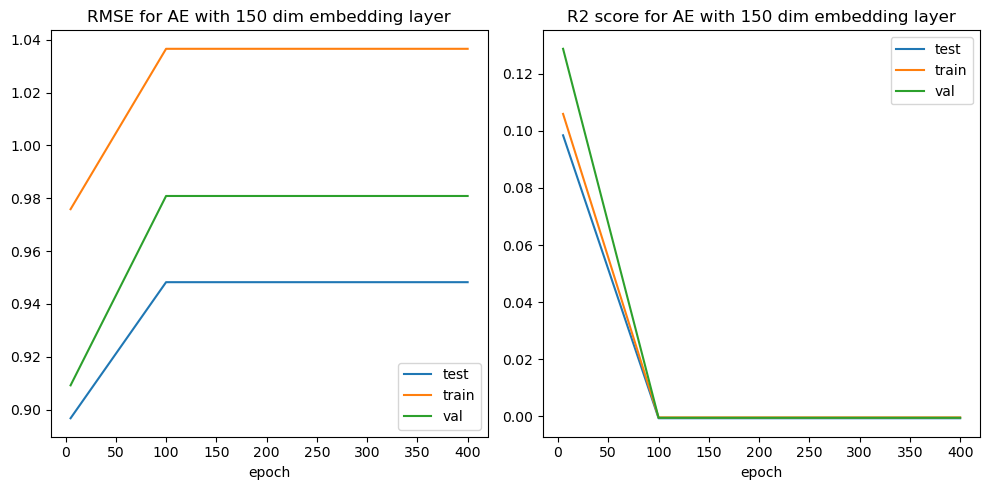

In [179]:
plot_R2_rmse_scores(reg_metrics)

### Baseline - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

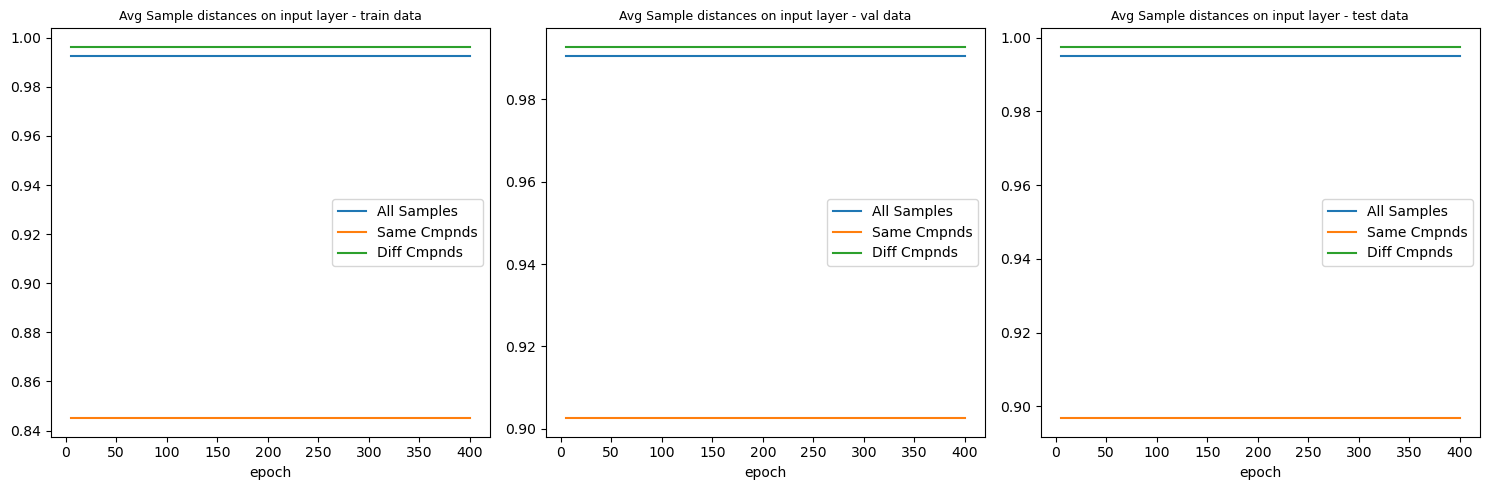

In [180]:
plot_distances(group_metrics, layer = 'inp')

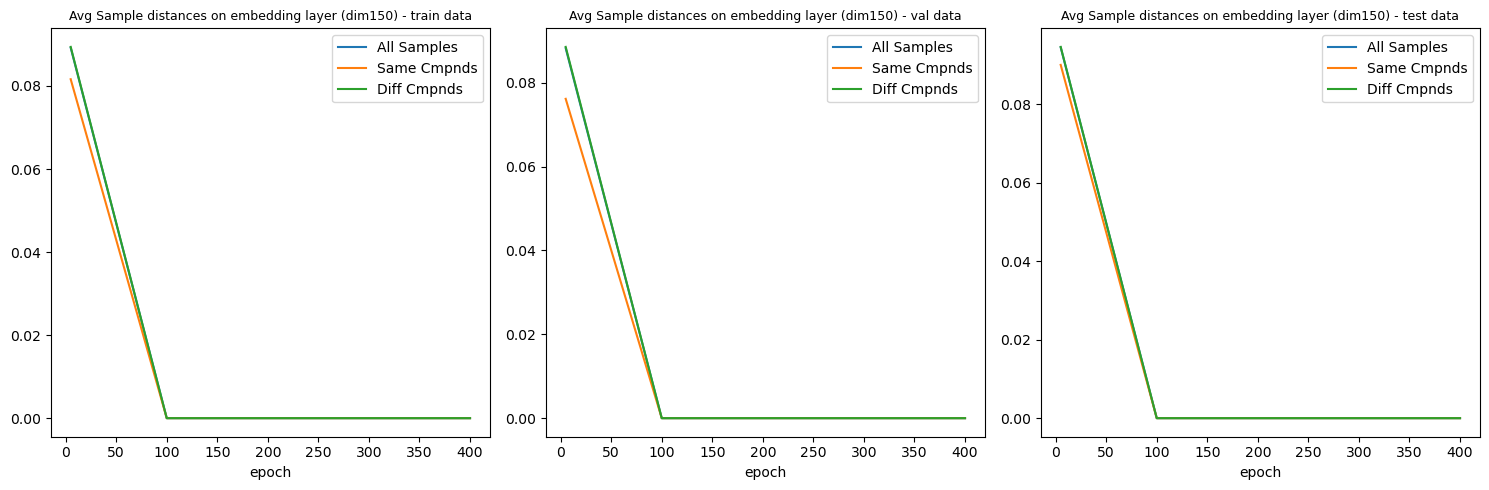

In [181]:
plot_distances(group_metrics, layer = 'emb')

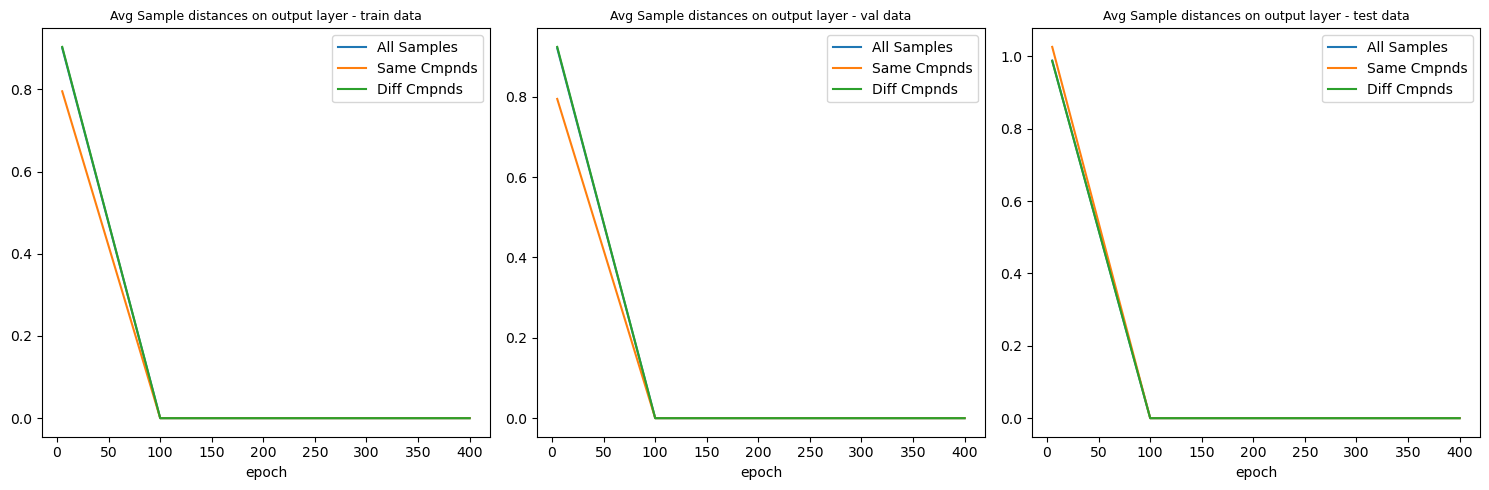

In [182]:
plot_distances(group_metrics, layer = 'out')

### Plot Pairwise distance matrix 

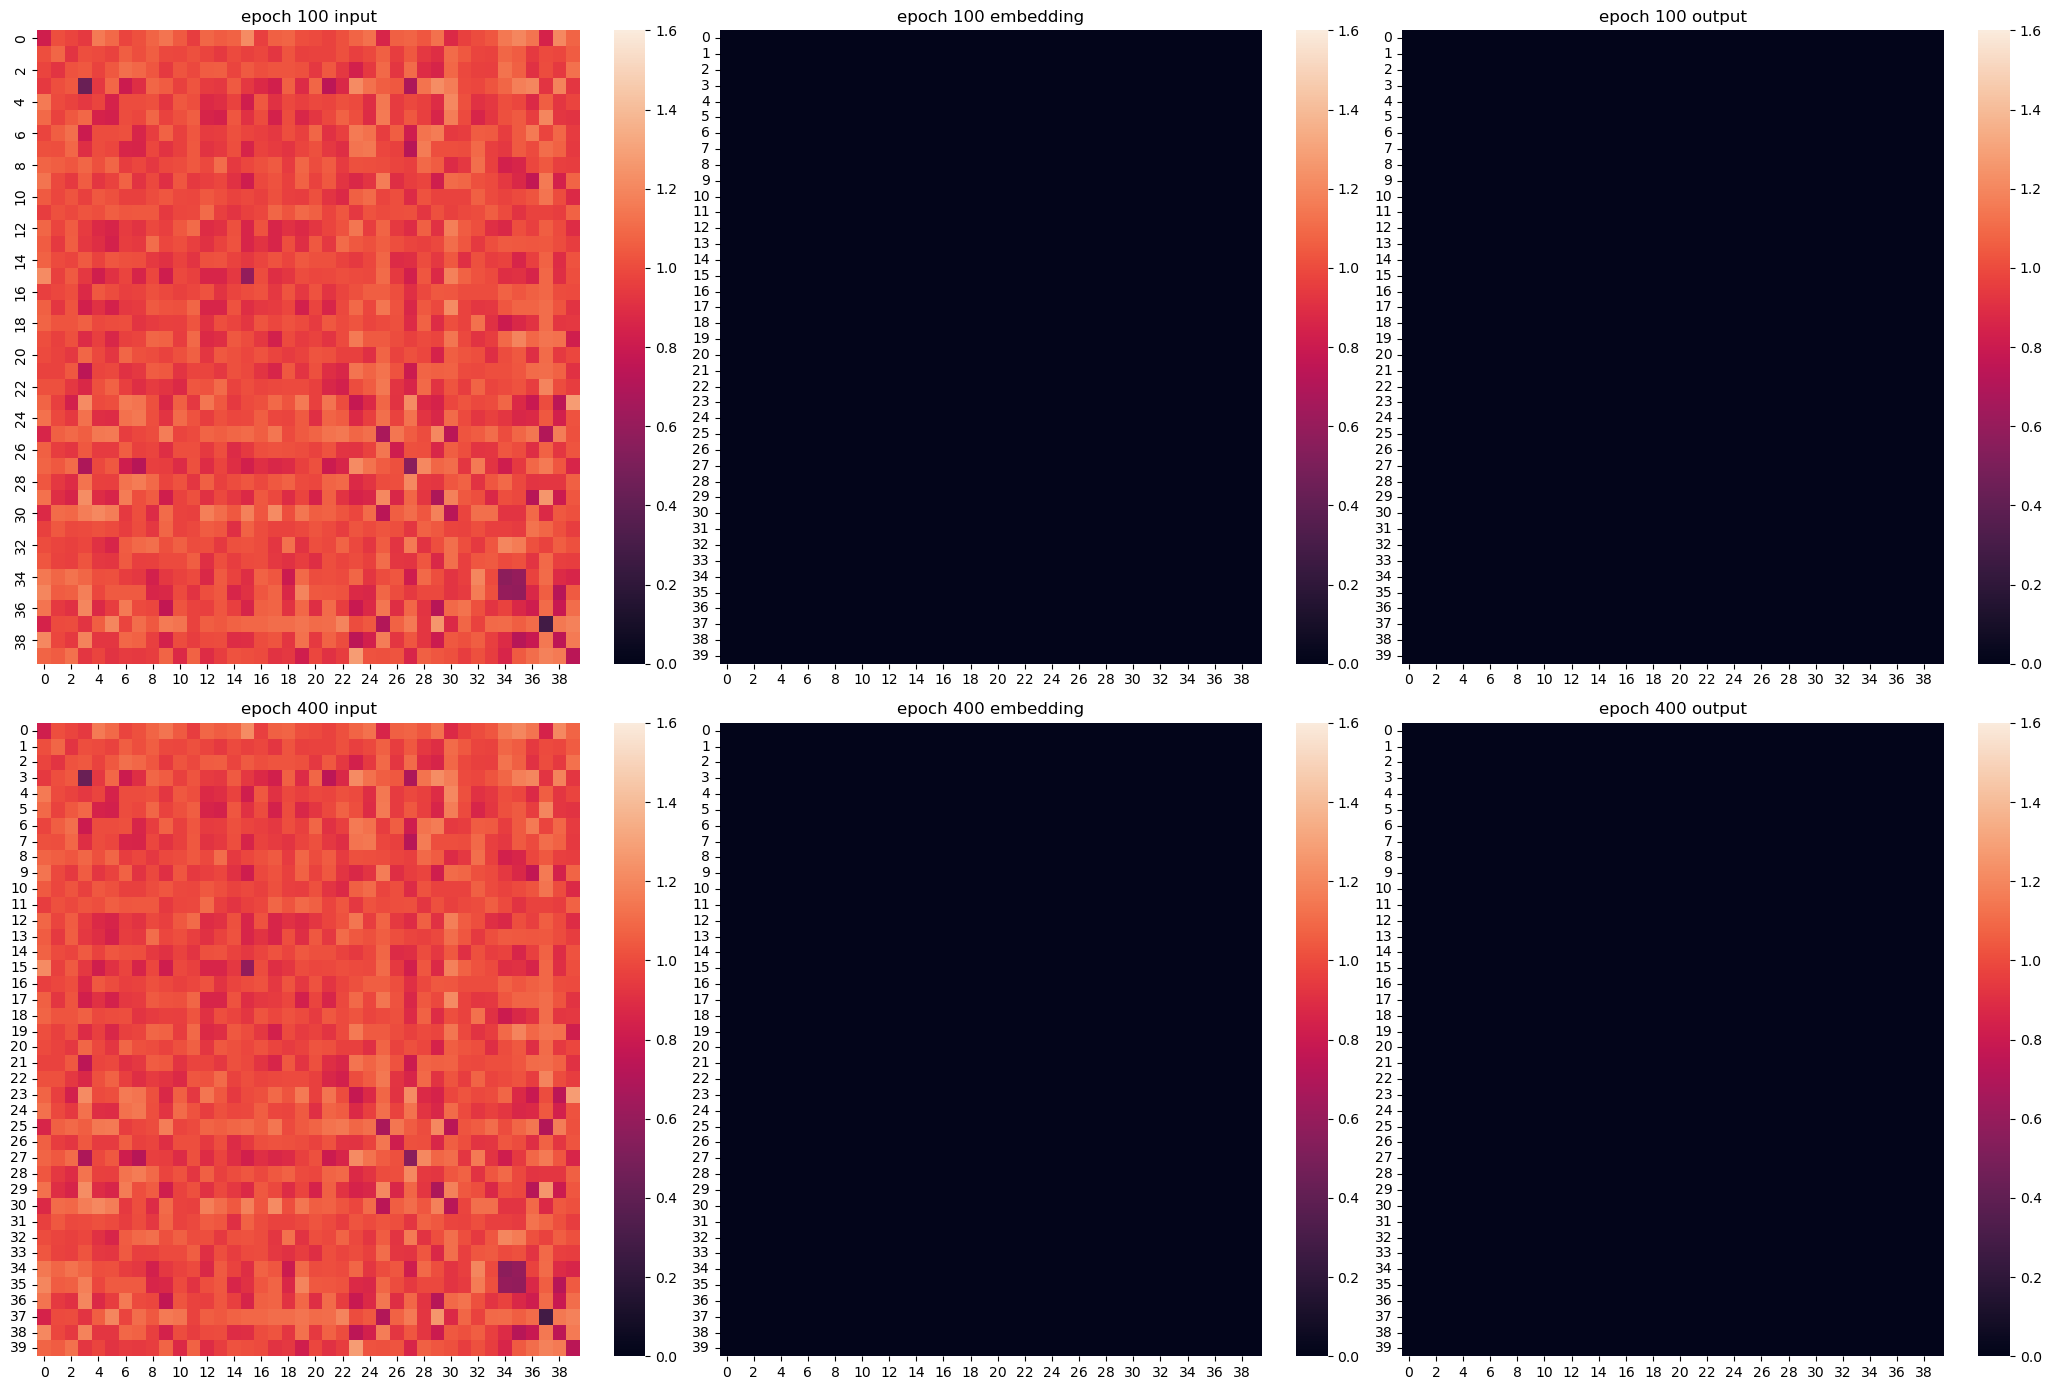

In [183]:
plot_epochs = [100, 400]
utils.plot_distance_matrices(grp_level_dict, data= 'train', epochs = plot_epochs, annot = False)

## SNNL Model with weight Decay = 0.1, SNNL Factor = 3

In [184]:
# load_filename = 'AE_snnl_20240903_1936_wd_0.1_snnlfactor_3_distmtrcs_40_samples_20240904_0010.pkl'
load_filename = 'AE_snnl_20240903_1936_wd_0.1_snnlfactor_3_distmtrcs_40_samples_20240905_1841.pkl'
loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.1'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

 load_metrics(): load  data from ./results/WD_0.1/AE_snnl_20240903_1936_wd_0.1_snnlfactor_3_distmtrcs_40_samples_20240905_1841.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

### SNNL - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

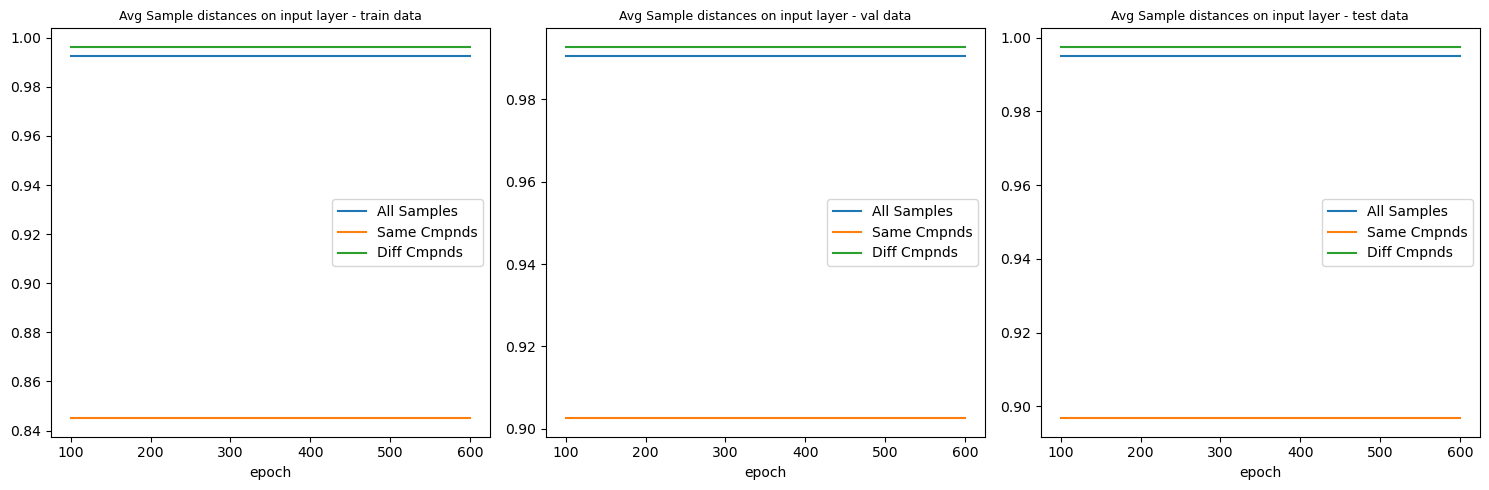

In [185]:
plot_distances(group_metrics, layer = 'inp')

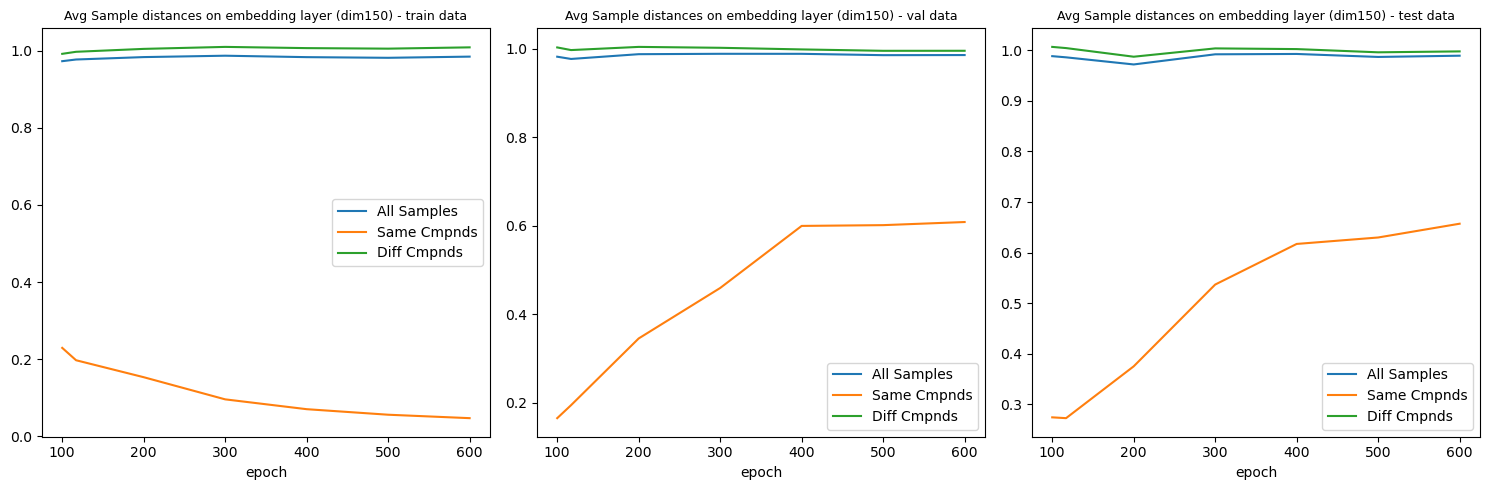

In [186]:
plot_distances(group_metrics, layer = 'emb')

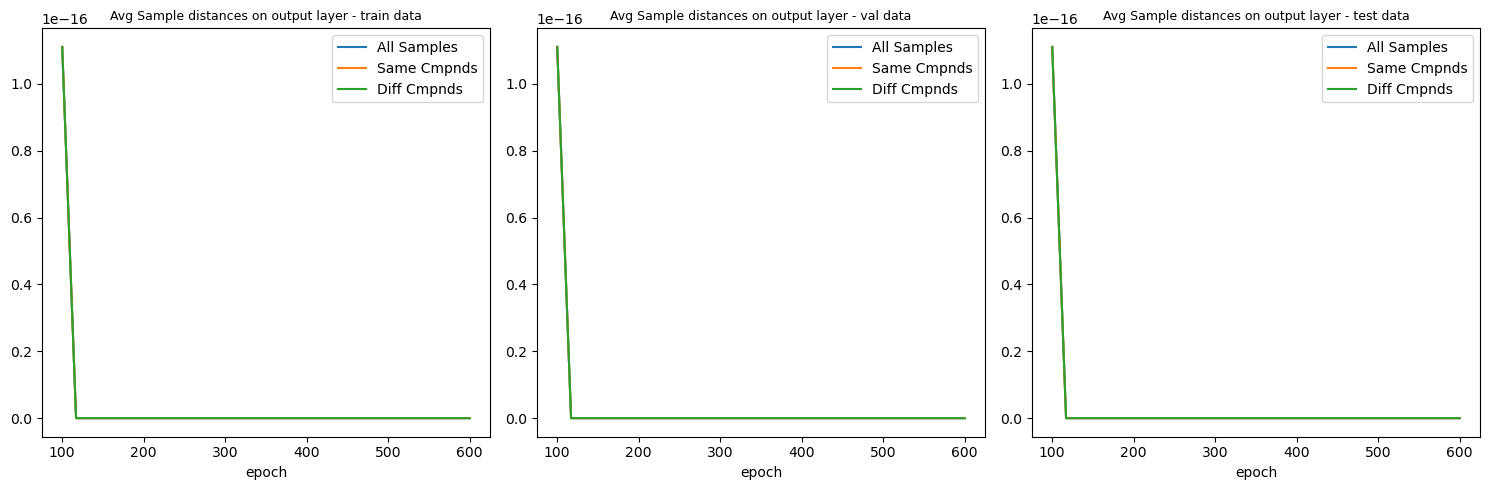

In [187]:
plot_distances(group_metrics, layer = 'out')

### SNNL  - Plot R2 and RMSE score 

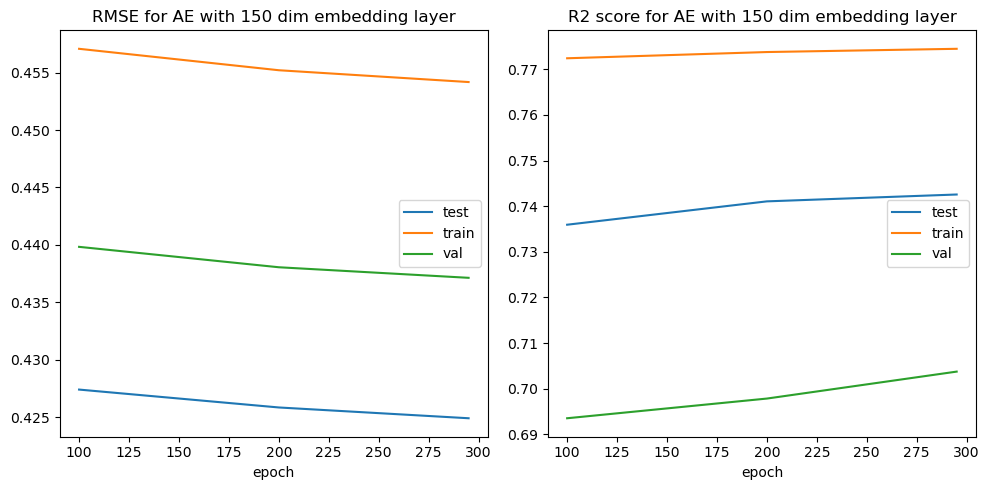

In [188]:
plot_R2_rmse_scores(baseline_reg_metrics)

### Plot Pairwise distance matrix 

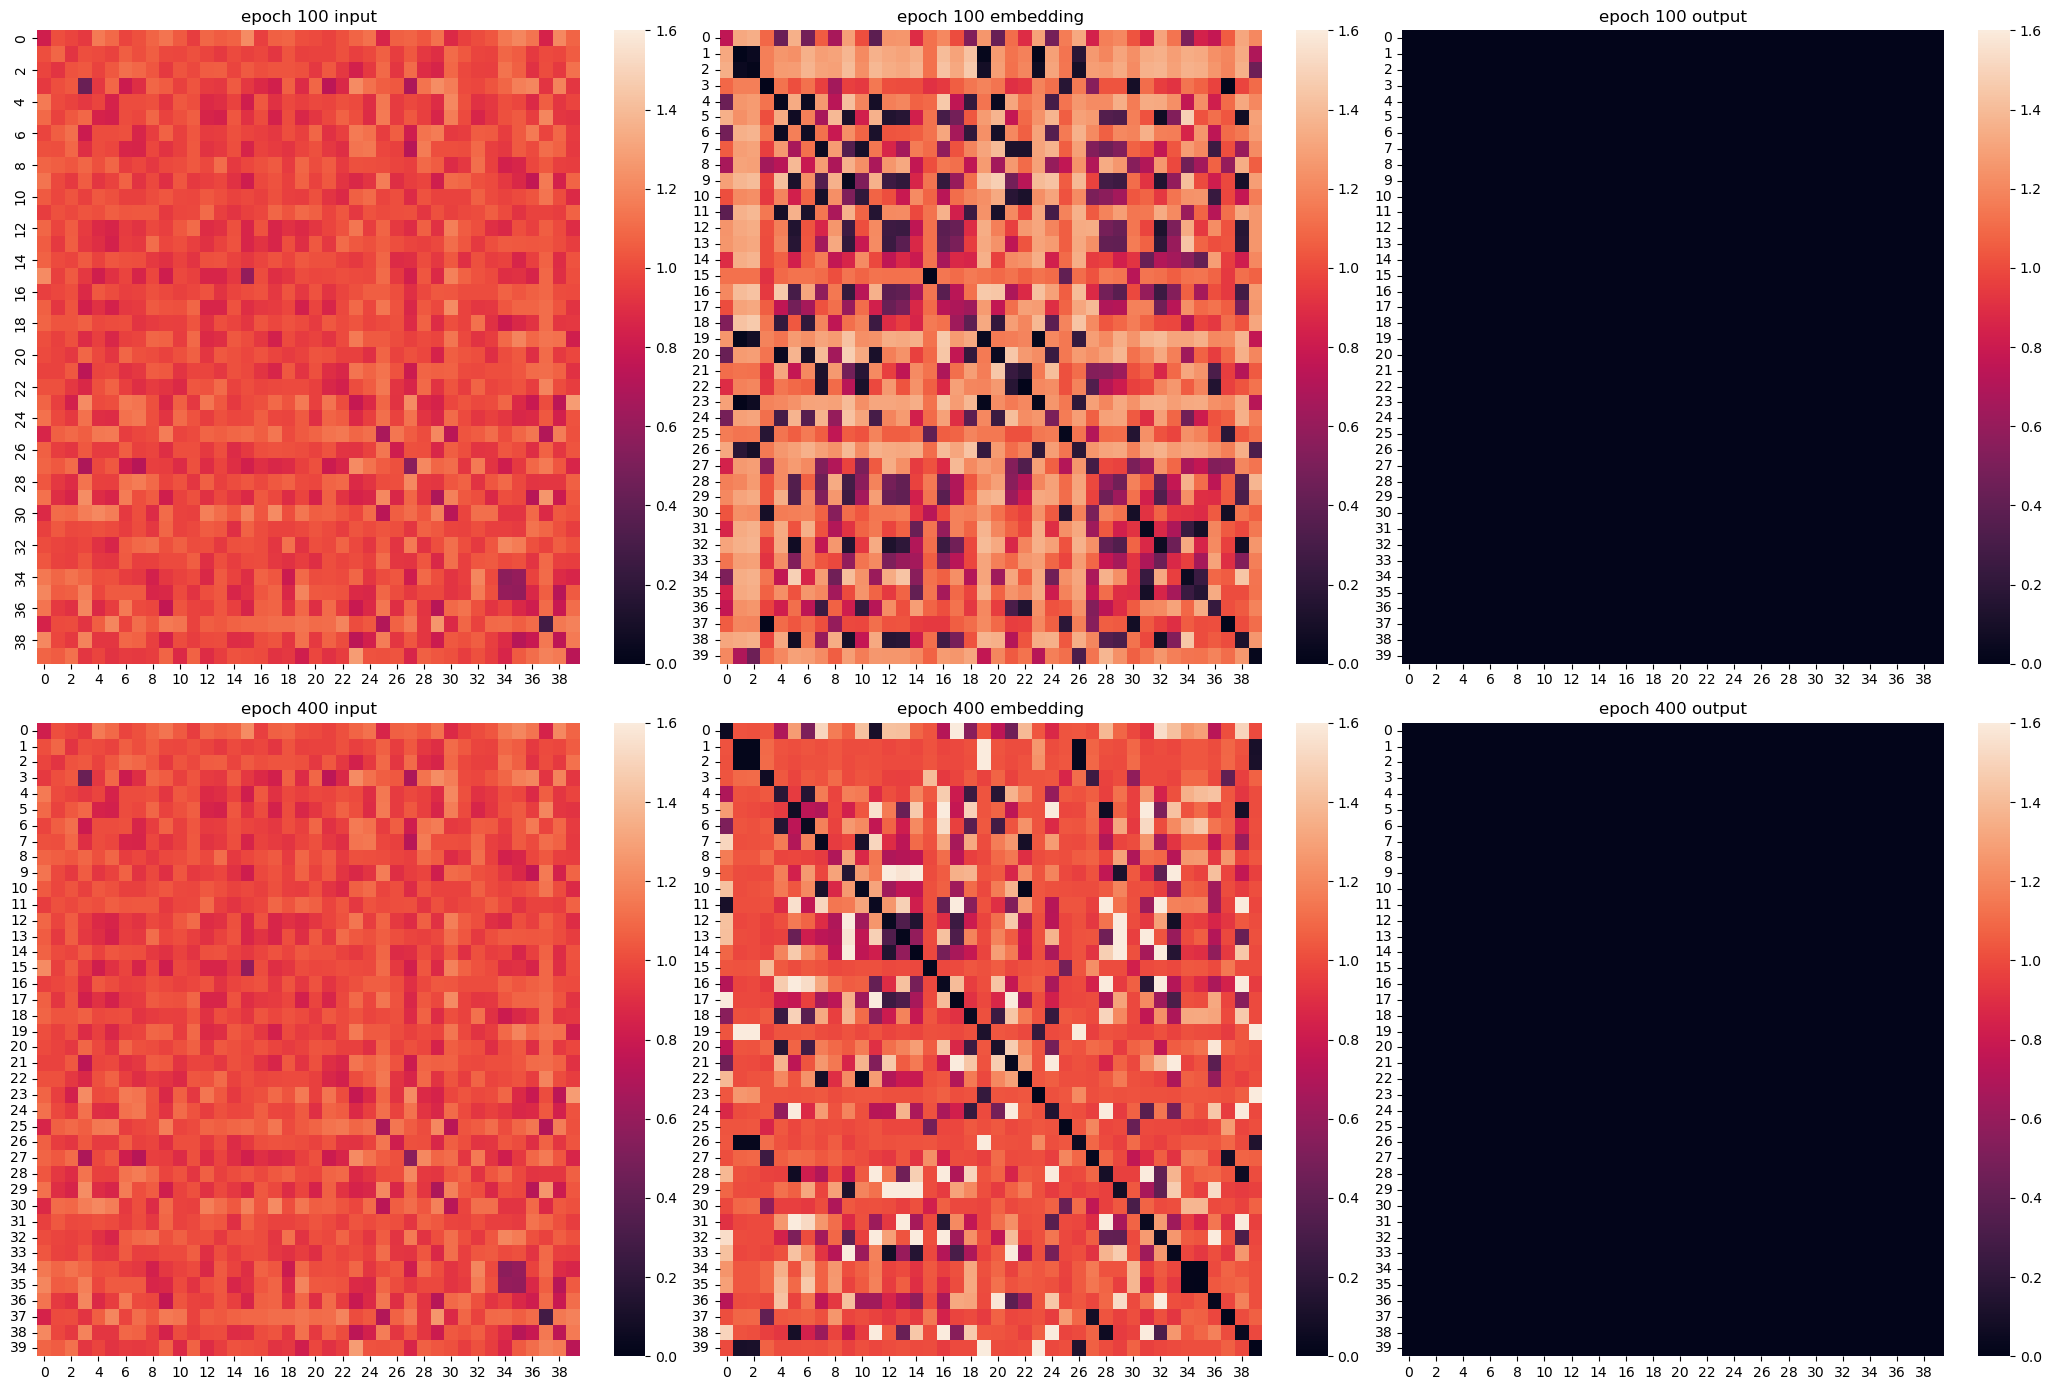

In [189]:
plot_epochs = [100, 400]
utils.plot_distance_matrices(grp_level_dict, data= 'train', epochs = plot_epochs, annot = False)

## SNNL Model with weight Decay = 0.1, SNNL Factor = 30

In [171]:
# load_filename = 'AE_snnl_20240829_1639_wd_0.01_snnlfactor_30_distmtrcs_20_samples_20240830_2115.pkl'
# load_filename = 'AE_snnl_20240903_1938_wd_0.1_snnlfactor_30_distmtrcs_40_samples_20240904_0010.pkl'
load_filename = 'AE_snnl_20240903_1938_wd_0.1_snnlfactor_30_distmtrcs_40_samples_20240905_1841.pkl'
loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.1'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data


 load_metrics(): load  data from ./results/WD_0.1/AE_snnl_20240903_1938_wd_0.1_snnlfactor_30_distmtrcs_40_samples_20240905_1841.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

### SNNL - Plot Distances 

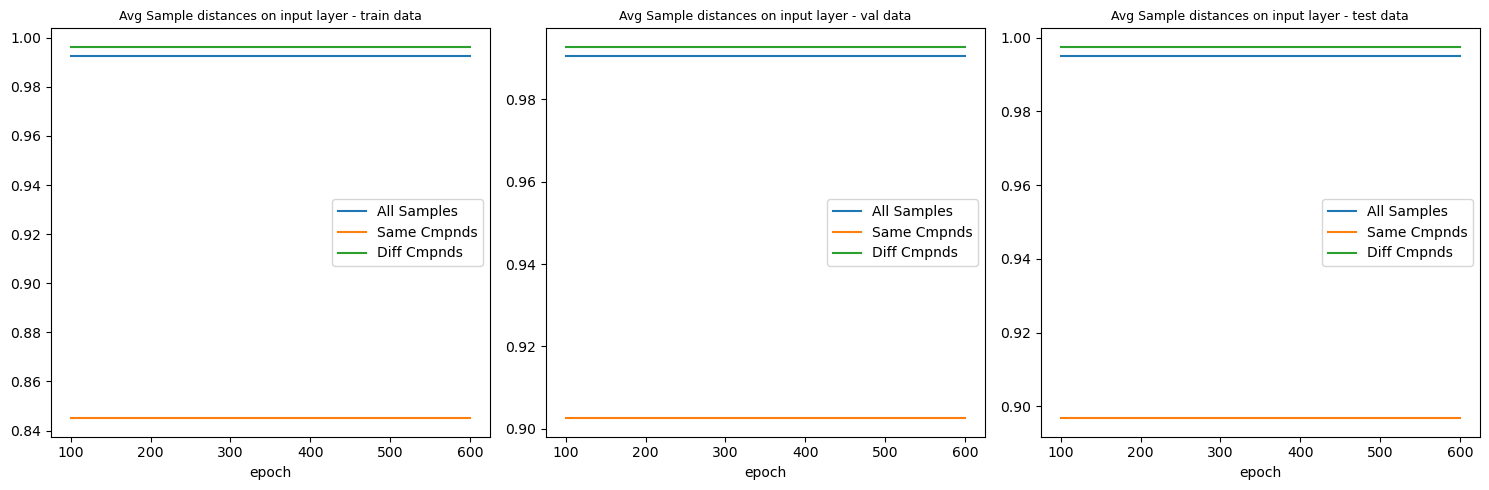

In [172]:
plot_distances(group_metrics, layer = 'inp')

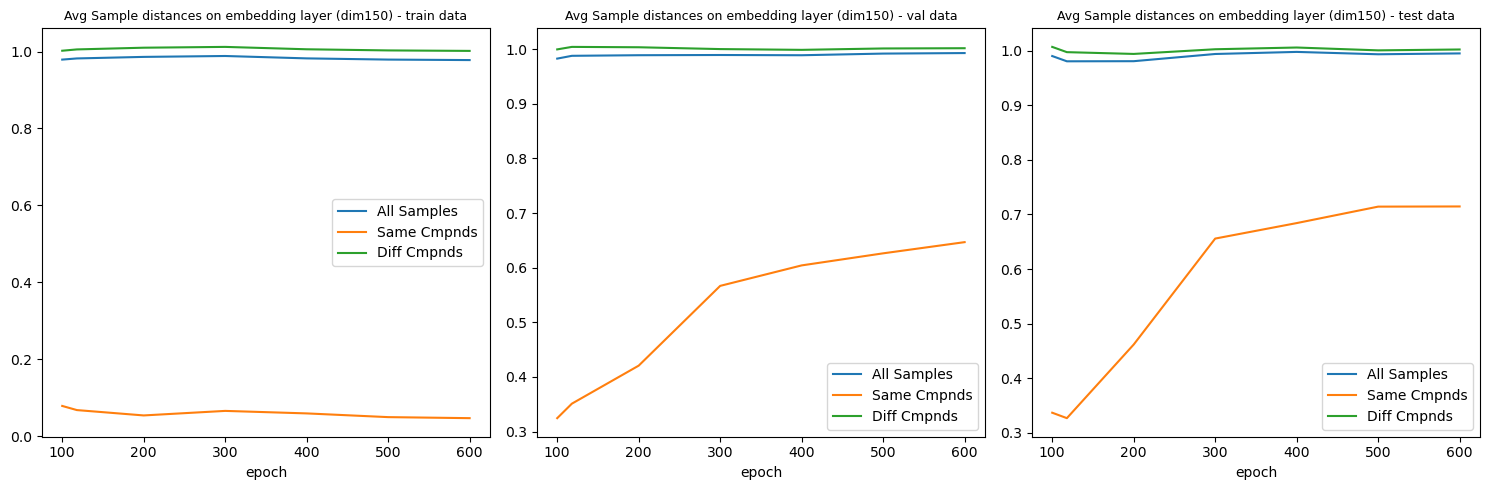

In [173]:
plot_distances(group_metrics, layer = 'emb')

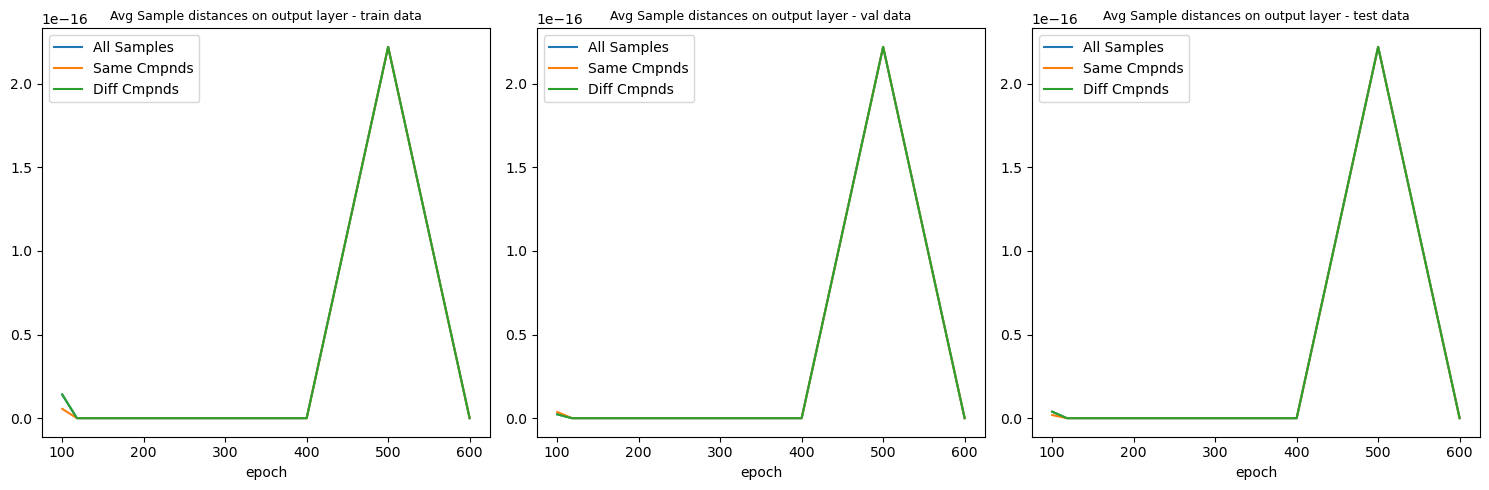

In [174]:
plot_distances(group_metrics, layer = 'out')

### SNNL  - Plot R2 and RMSE score 

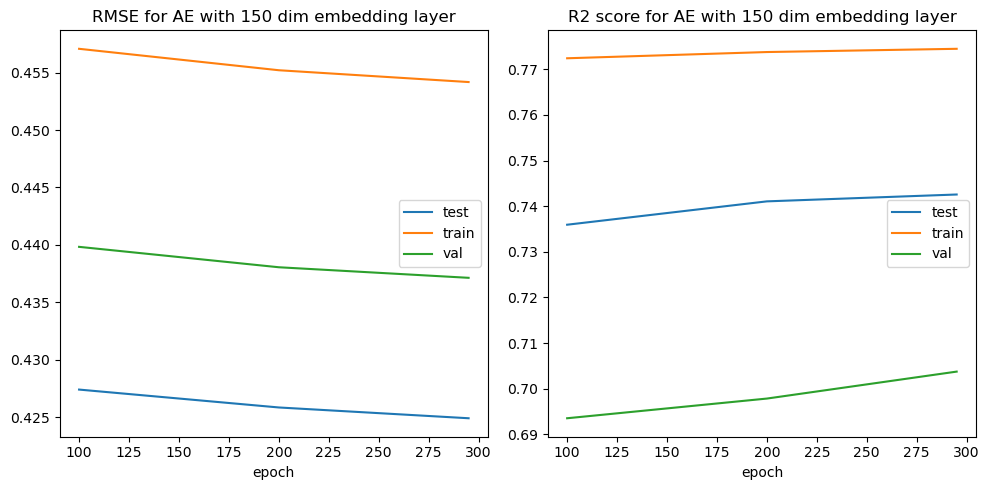

In [175]:
plot_R2_rmse_scores(baseline_reg_metrics)

### Plot Pairwise distance matrix 

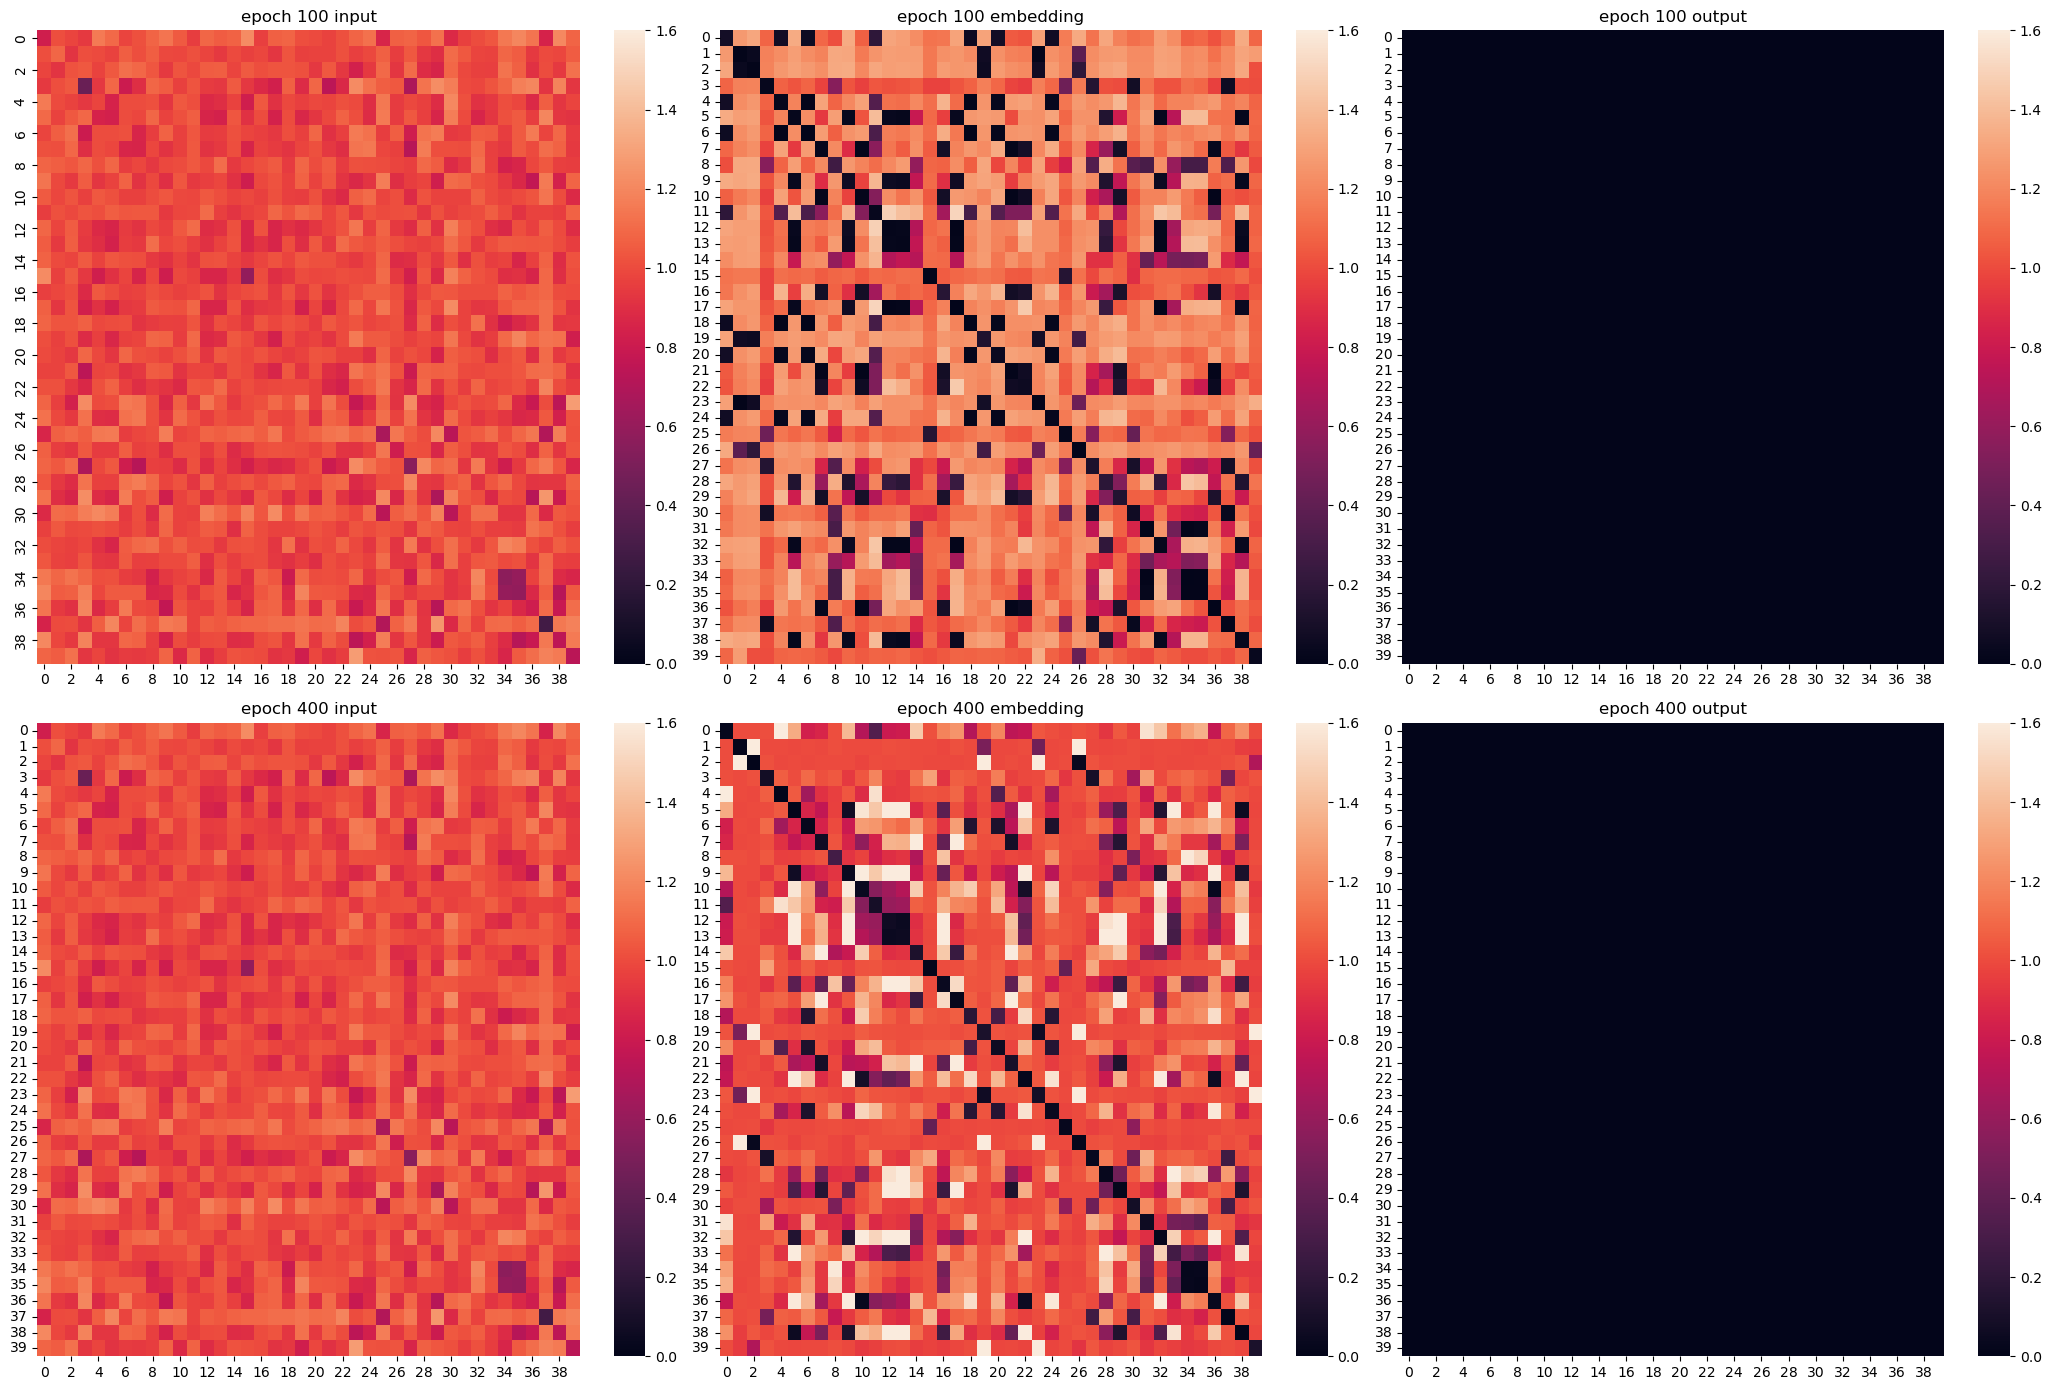

In [176]:
plot_epochs = [100, 400]
utils.plot_distance_matrices(grp_level_dict, data= 'train', epochs = plot_epochs, annot = False)

# Results for experiments with Weight Decay = 0.01

## Baseline Model with Weight Decay  = 0.01

In [13]:
# load_filename = 'AE_base_20240709_1950_distance_metrics_20240826_2141.pkl'
# load_filename = 'AE_base_20240709_1950_distance_metrics_20_samples_20240826_2220.pkl'
load_filename = 'AE_base_20240827_1938_wd_0.01_distmtrcs_40_samples_20240905_2135.pkl'
loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.01'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

 load_metrics(): load  data from ./results/WD_0.01/AE_base_20240827_1938_wd_0.01_distmtrcs_40_samples_20240905_2135.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

### Baseline - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

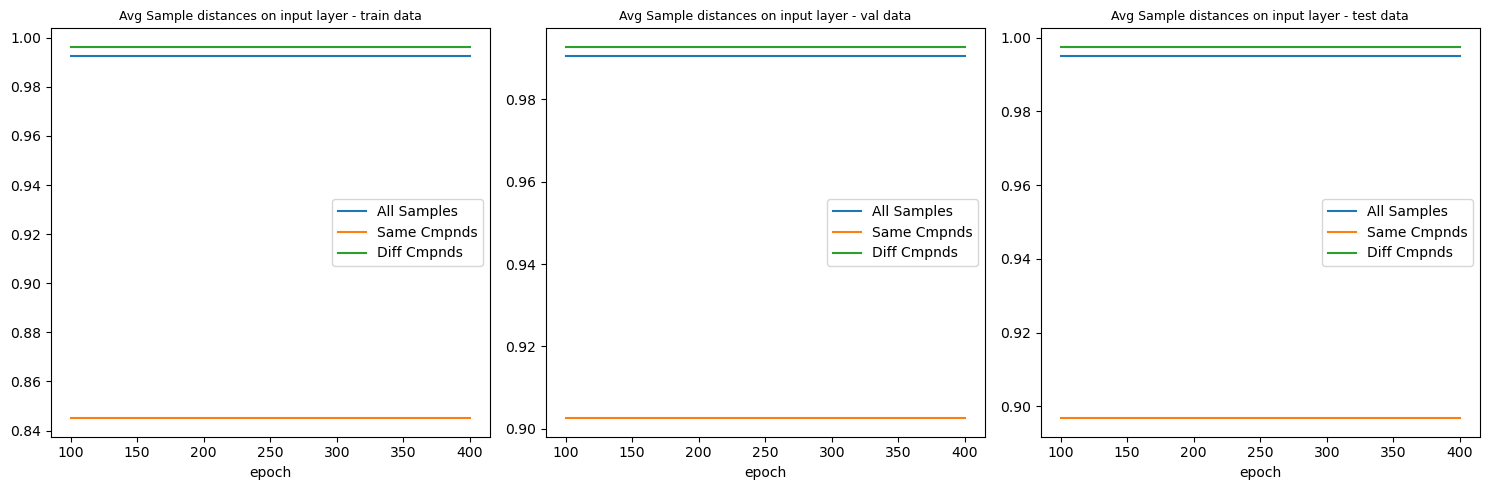

In [14]:
plot_distances(group_metrics, layer = 'inp')

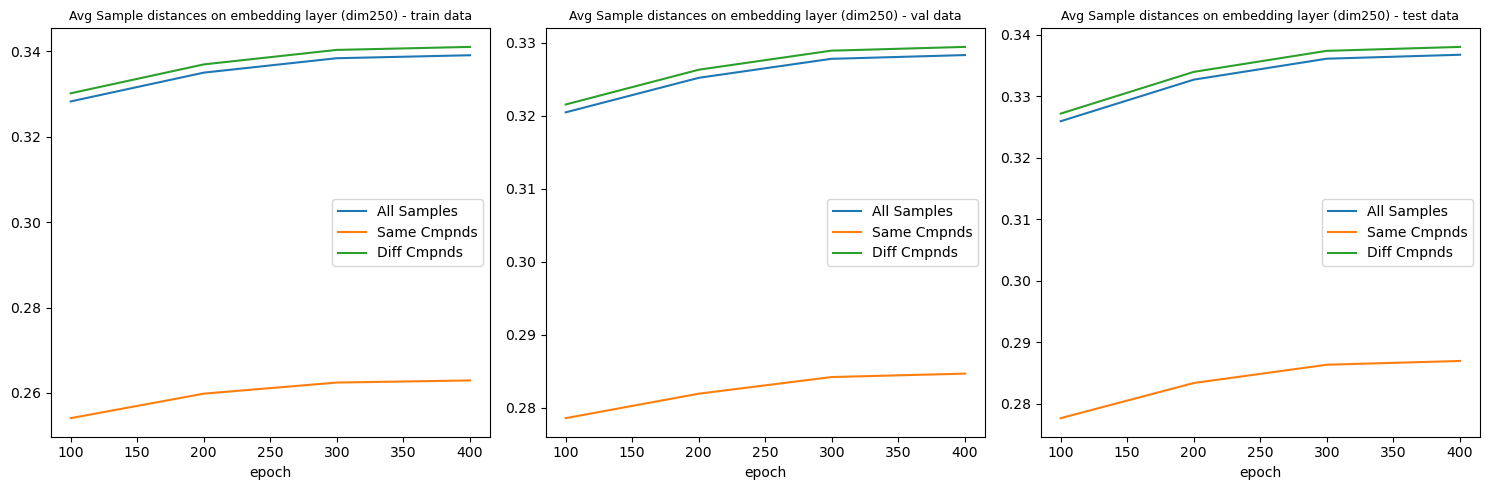

In [15]:
plot_distances(group_metrics, layer = 'emb')

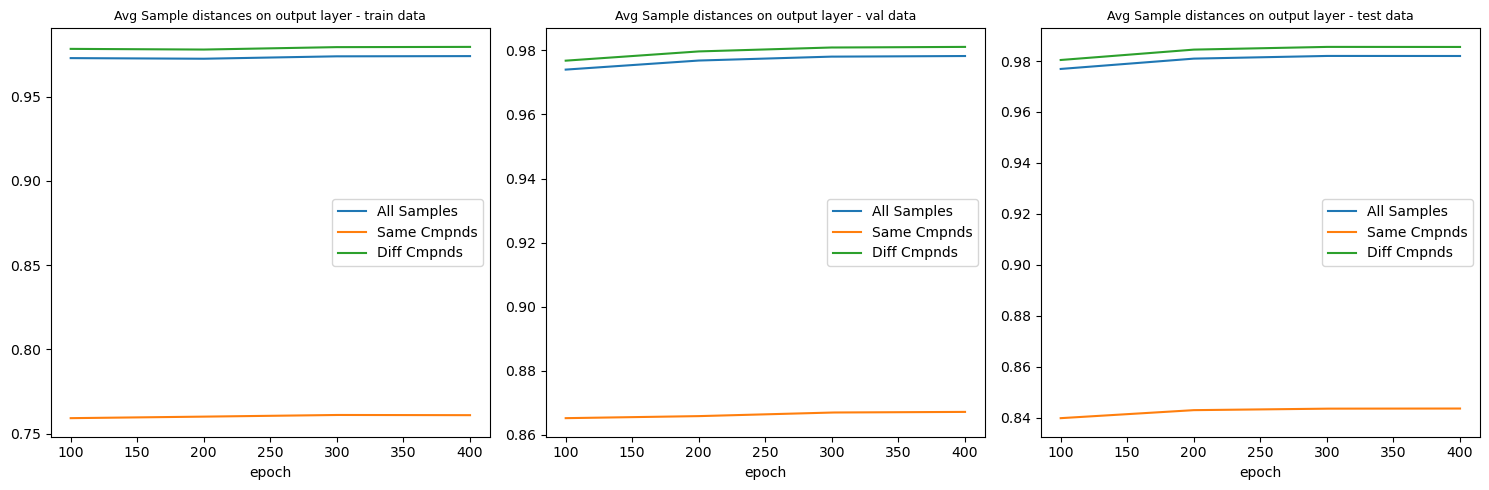

In [16]:
plot_distances(group_metrics, layer = 'out')

### Baseline - Plot R2 and RMSE score 

Autoencoder with NO SBBL regularization , embedding dim 150 

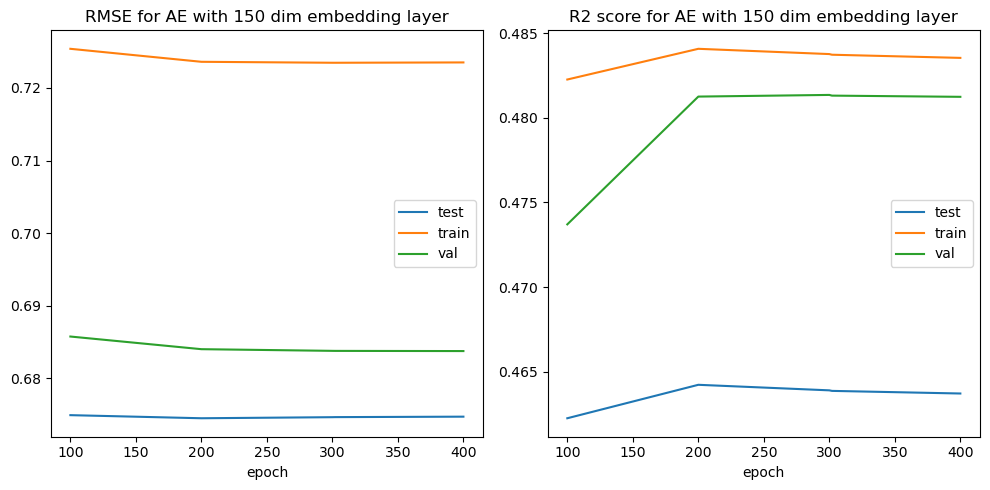

In [52]:
plot_R2_rmse_scores(reg_metrics)

### Plot Pairwise distance matrix 

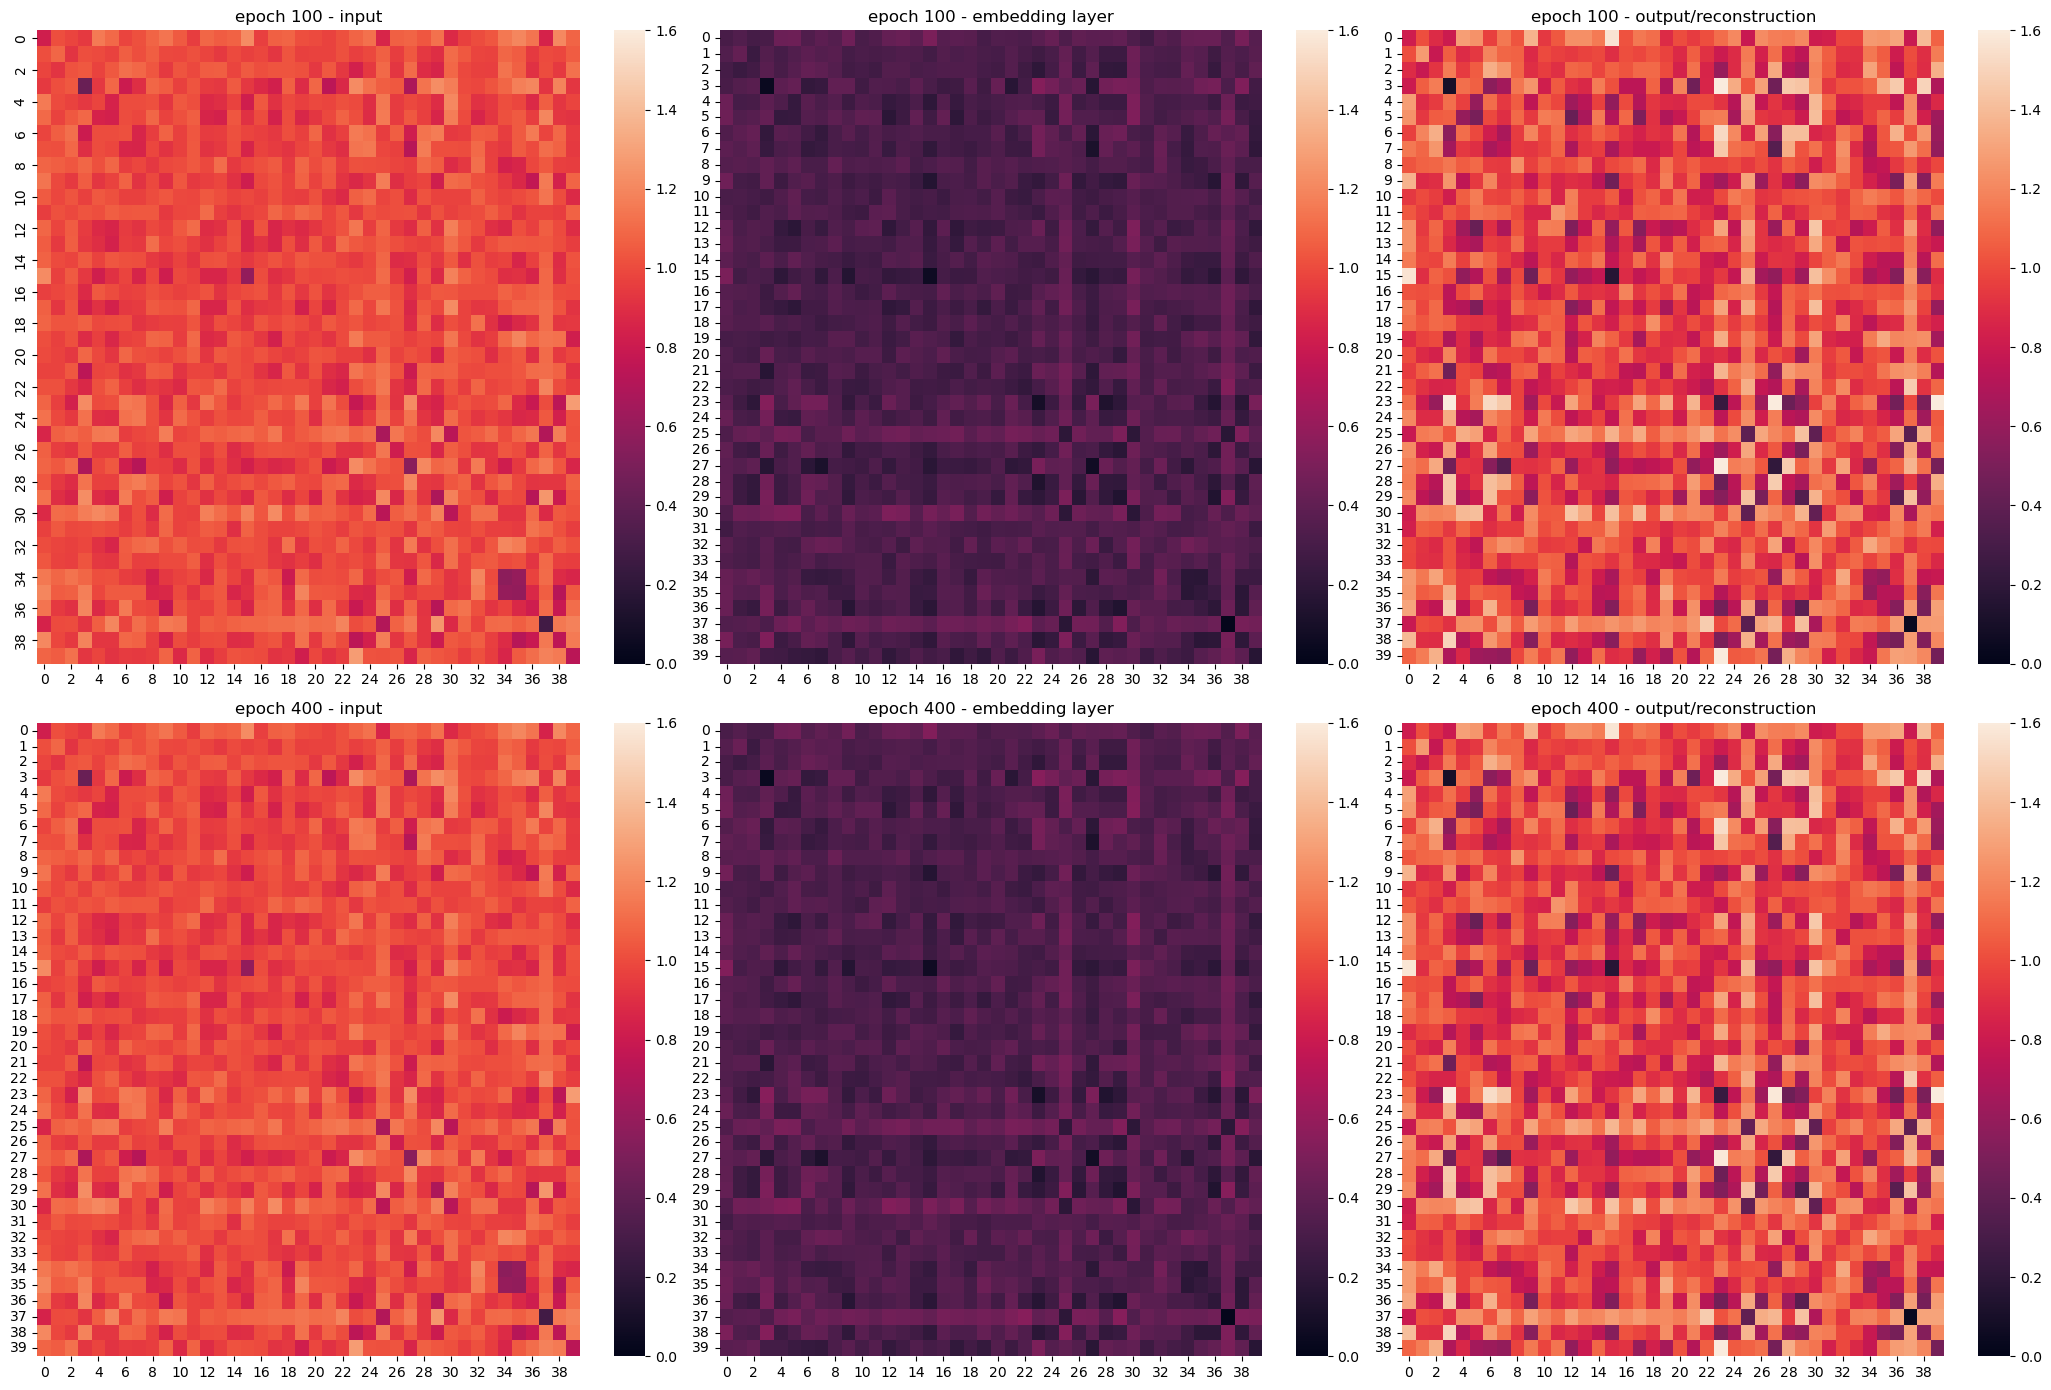

In [53]:
plot_epochs = [100, 400]
utils.plot_distance_matrices(grp_level_dict, data = 'train', epochs = plot_epochs, annot = False)

## SNNL Model with weight Decay = 0.01, SNNL Factor = 3

In [54]:
# load_filename = 'AE_snnl_20240829_1712_wd_0.01_snnlfactor_3_distmtrcs_20_samples_20240830_2134.pkl'
load_filename = 'AE_snnl_20240829_1712_wd_0.01_snnlfactor_3_distmtrcs_40_samples_20240905_2135.pkl'
loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.01'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

 load_metrics(): load  data from ./results/WD_0.01/AE_snnl_20240829_1712_wd_0.01_snnlfactor_3_distmtrcs_40_samples_20240905_2135.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

### SNNL - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

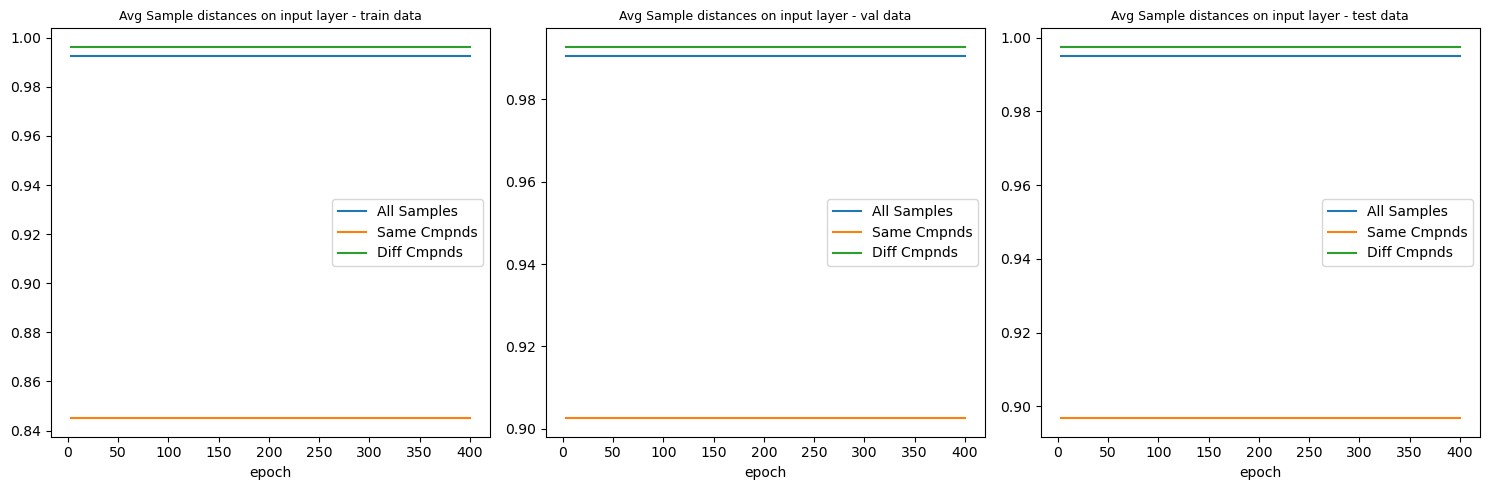

In [55]:
plot_distances(group_metrics, layer = 'inp')

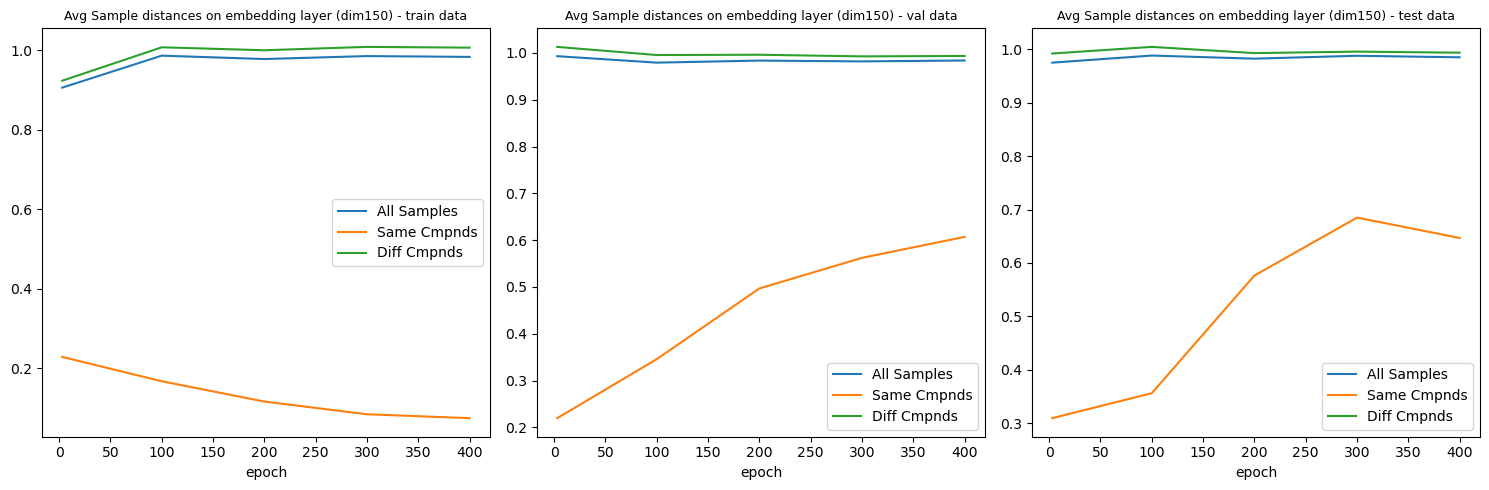

In [56]:
plot_distances(group_metrics, layer = 'emb')

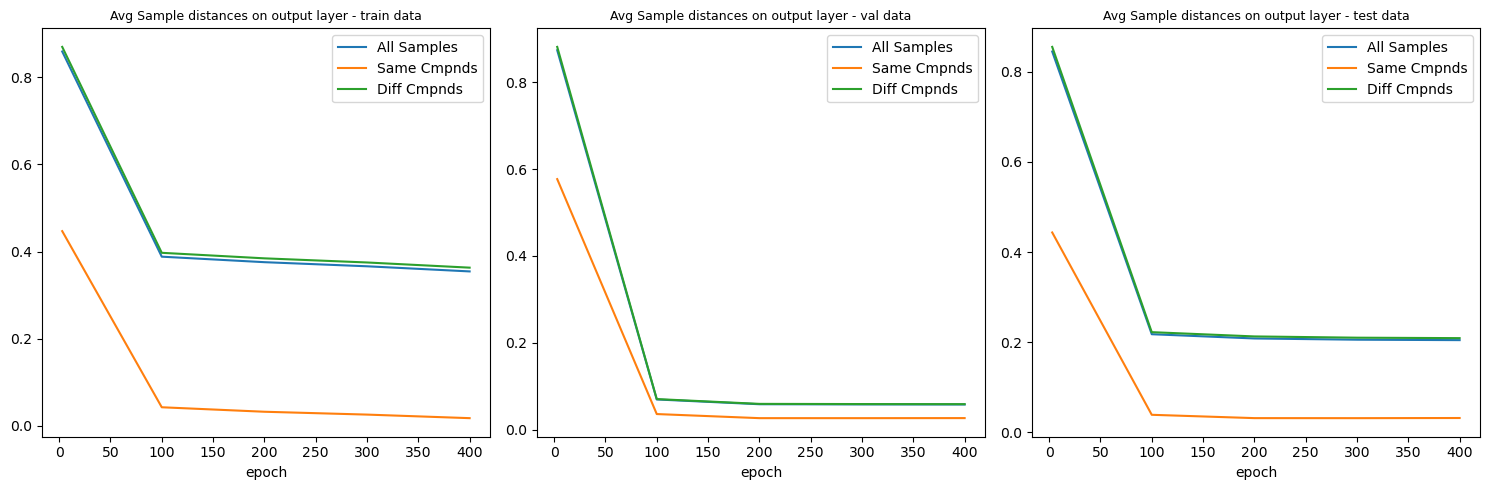

In [57]:
plot_distances(group_metrics, layer = 'out')

  ### SNNL  - Plot R2 and RMSE score 

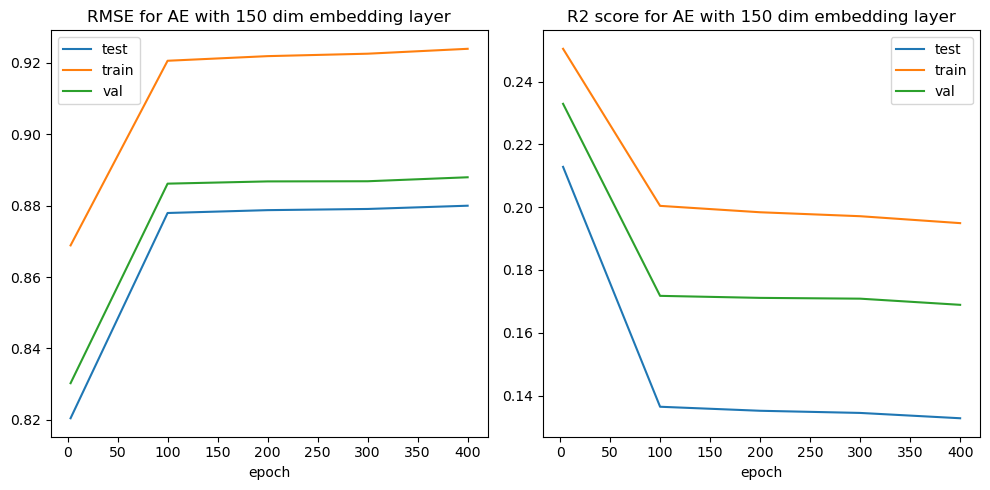

In [59]:
plot_R2_rmse_scores(reg_metrics)

### Plot Pairwise distance matrix 

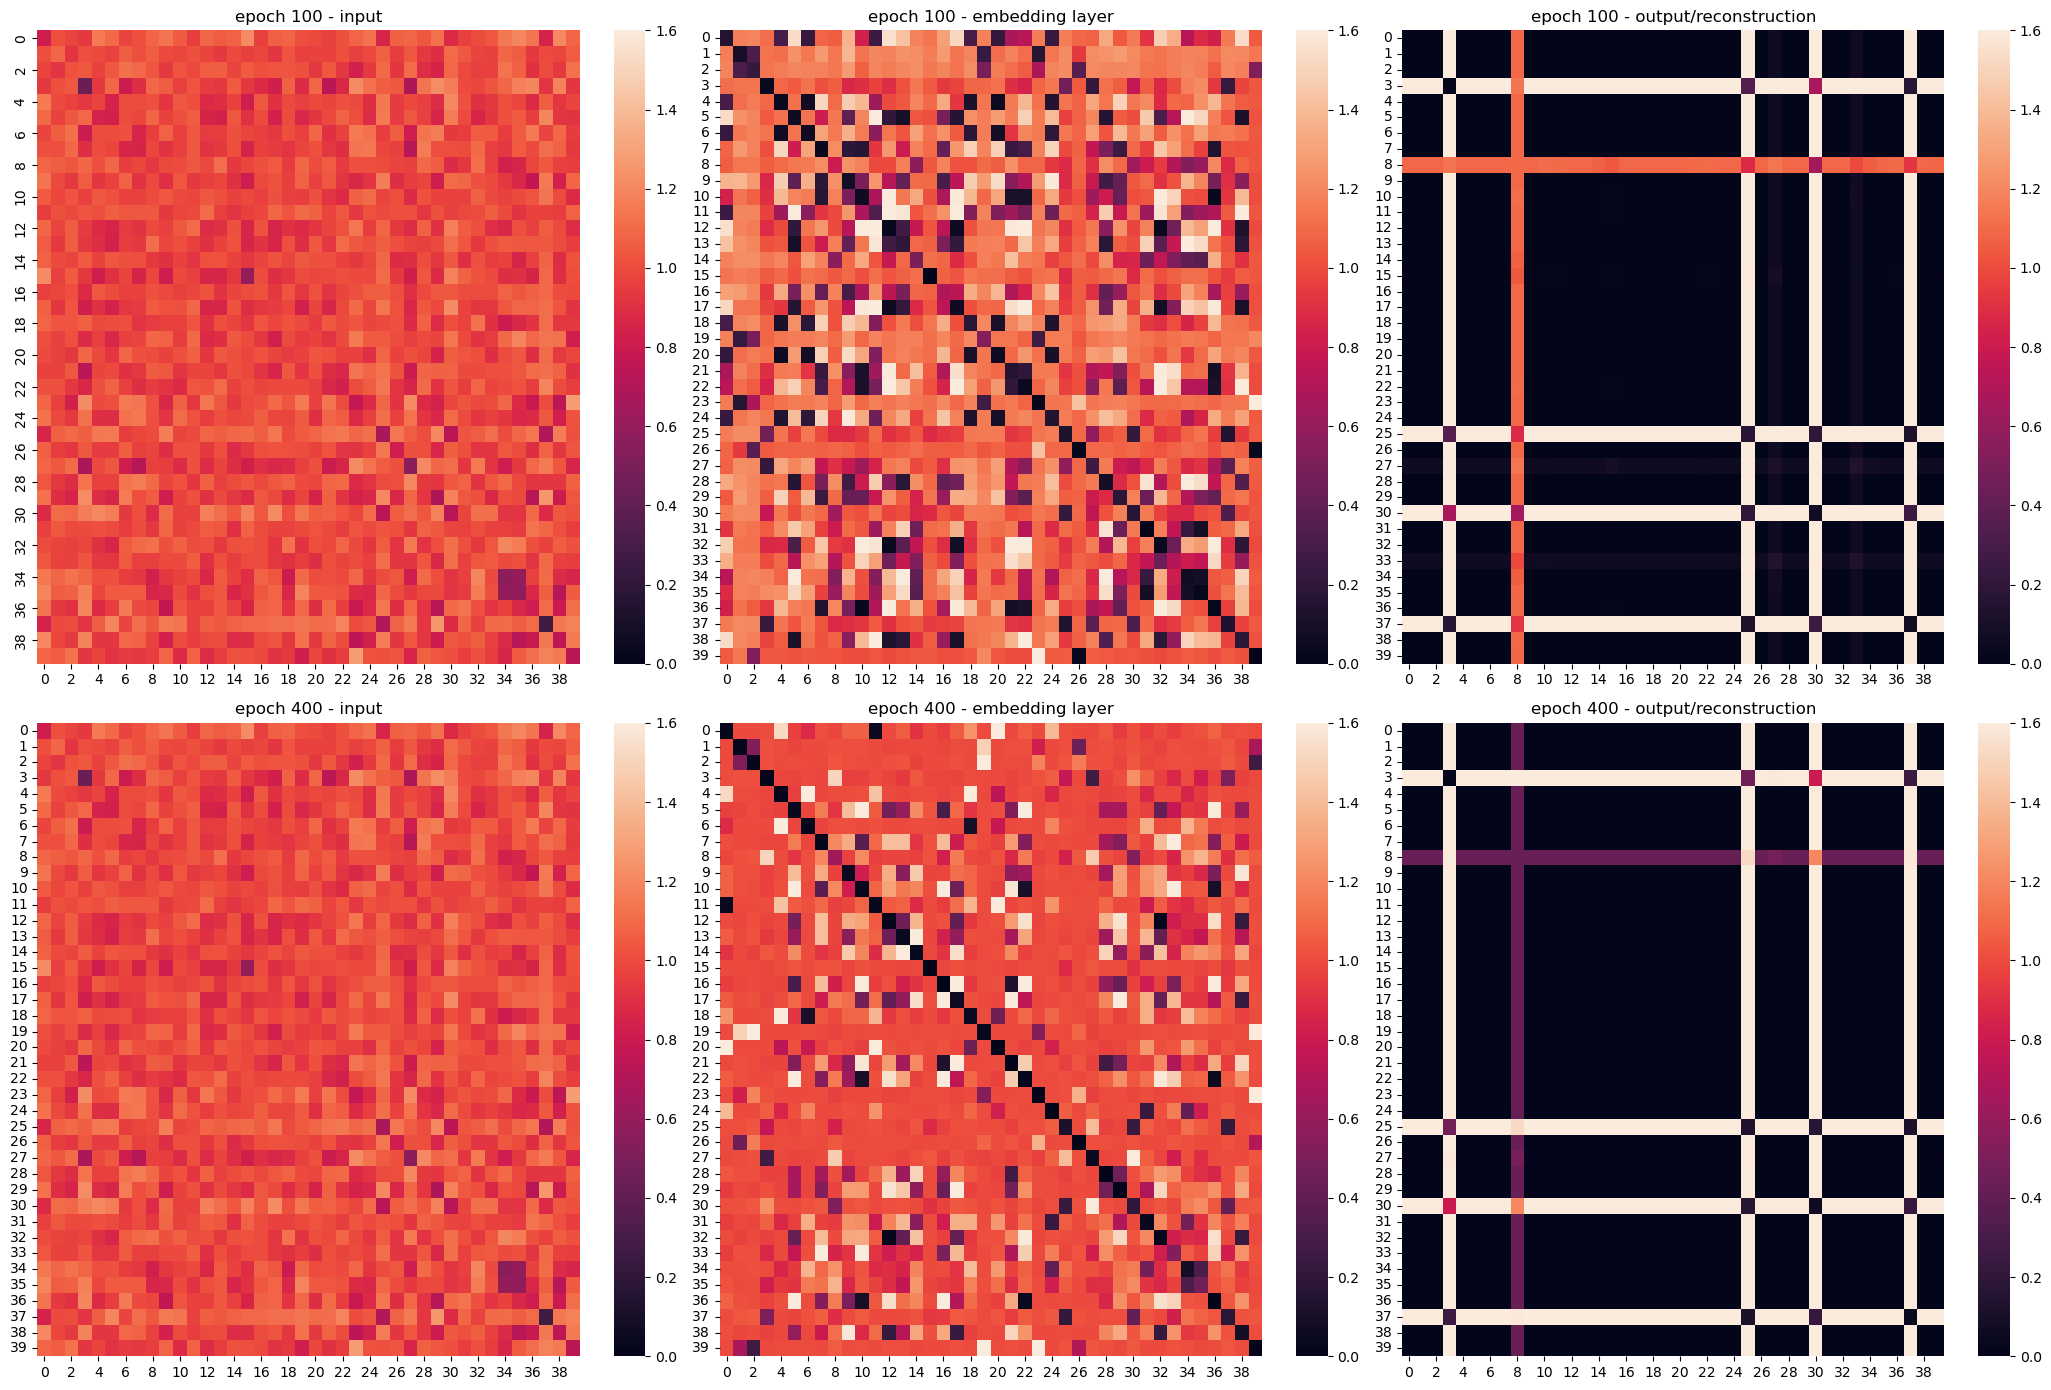

In [60]:
plot_epochs = [100, 400]
utils.plot_distance_matrices(grp_level_dict, data = 'train', epochs = plot_epochs, annot = False)

## SNNL Model with weight Decay = 0.01, SNNL Factor = 30

In [61]:
# load_filename = 'AE_snnl_20240829_1639_wd_0.01_snnlfactor_30_distmtrcs_20_samples_20240830_2115.pkl'
load_filename = 'AE_snnl_20240829_1639_wd_0.01_snnlfactor_30_distmtrcs_40_samples_20240905_2135.pkl'
loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.01'), load_filename, verbose = True)
loaded_data.keys()
reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

 load_metrics(): load  data from ./results/WD_0.01/AE_snnl_20240829_1639_wd_0.01_snnlfactor_30_distmtrcs_40_samples_20240905_2135.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

### SNNL - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

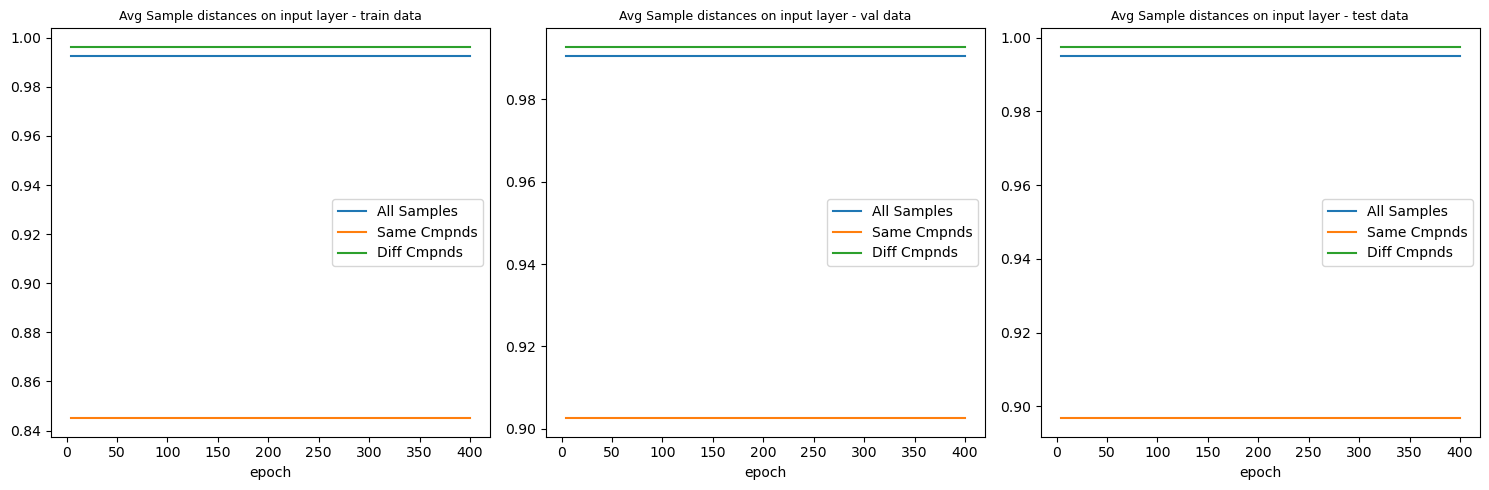

In [62]:
plot_distances(group_metrics, layer = 'inp')

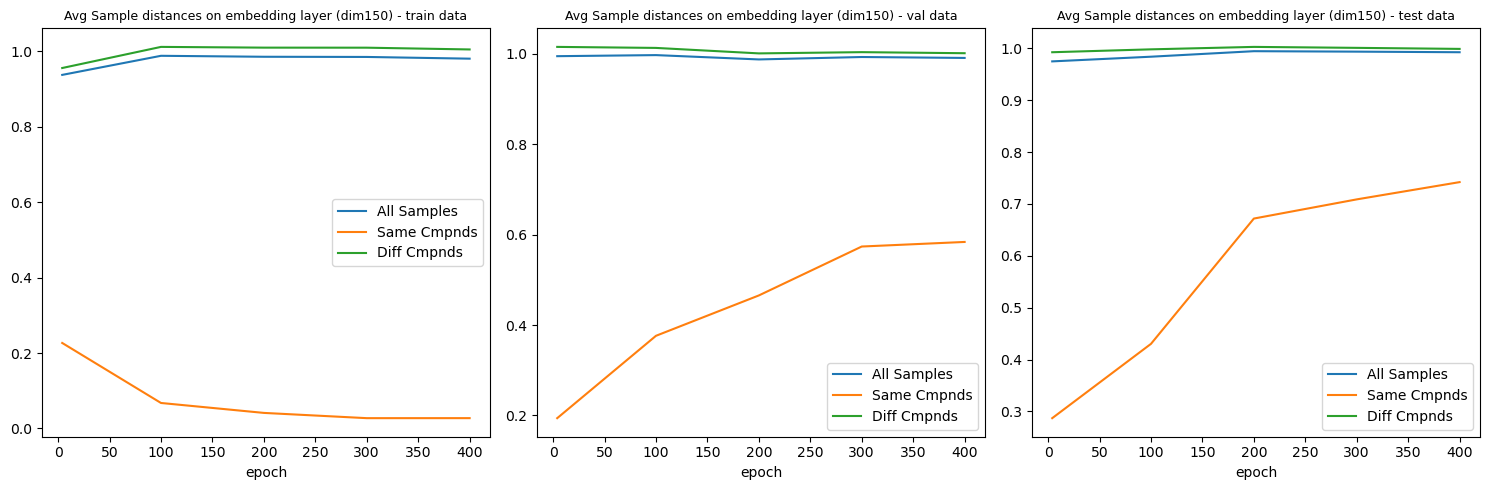

In [63]:
plot_distances(group_metrics, layer = 'emb')

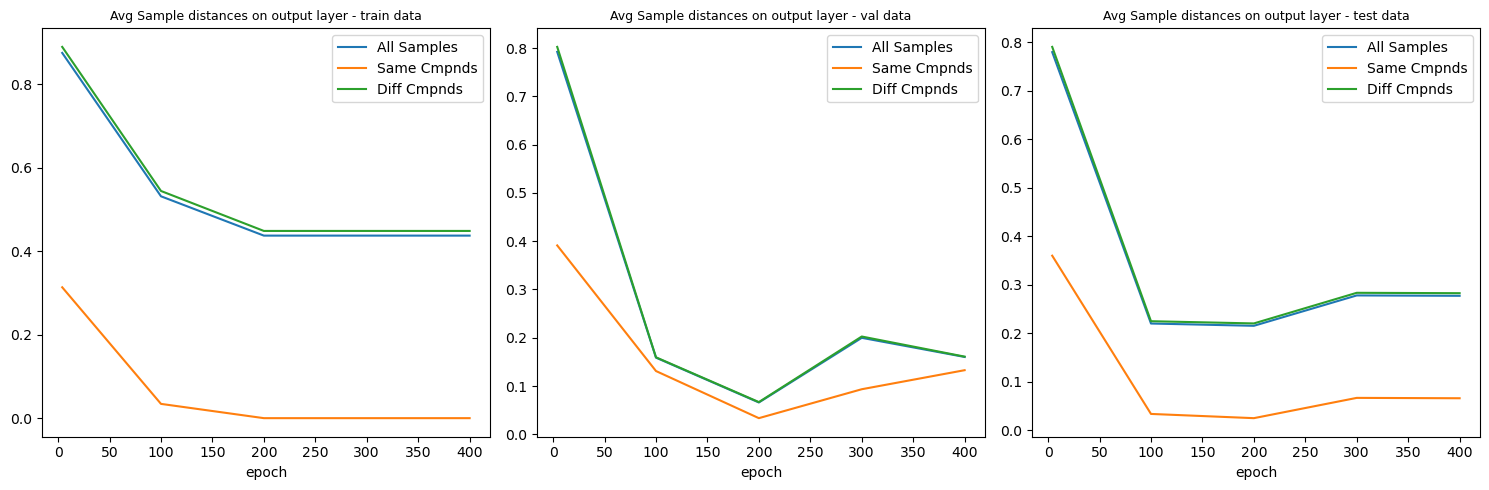

In [64]:
plot_distances(group_metrics, layer = 'out')

  ### SNNL  - Plot R2 and RMSE score 

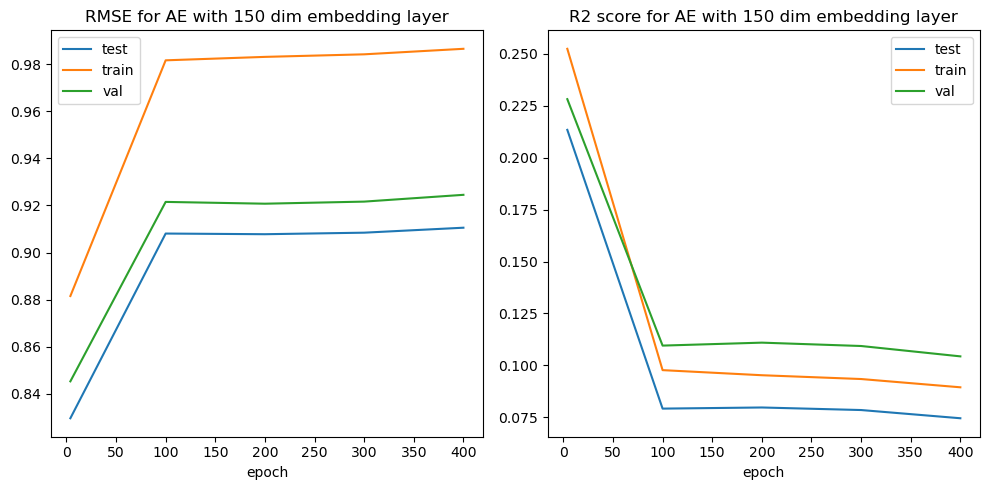

In [72]:
plot_R2_rmse_scores(reg_metrics)

### Plot Pairwise distance matrix 

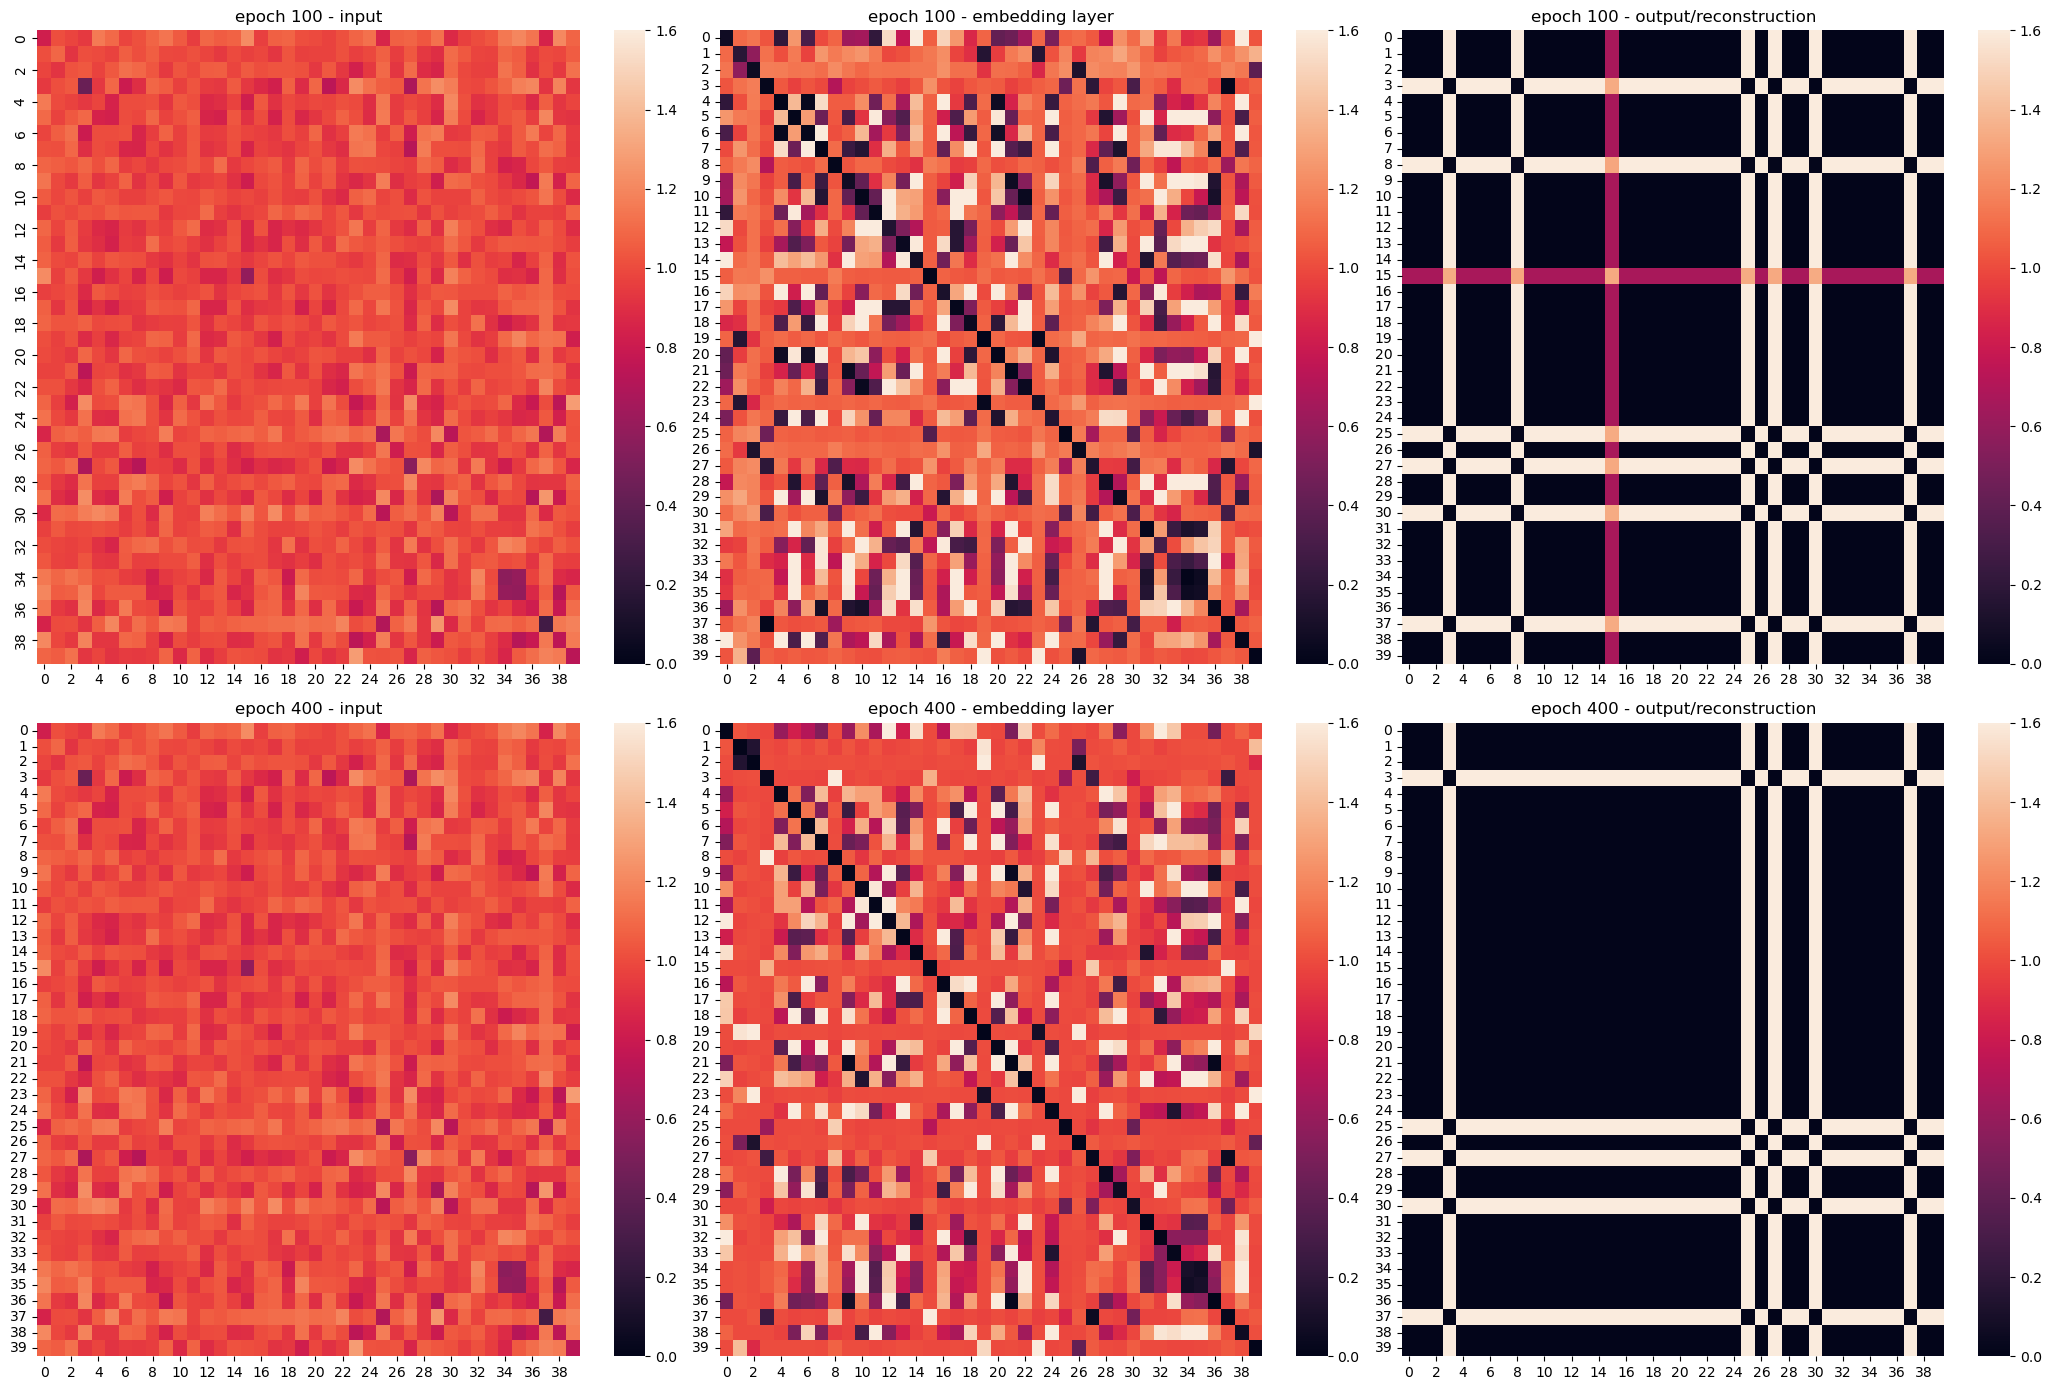

In [65]:
plot_epochs = [100, 400]
utils.plot_distance_matrices(grp_level_dict, data = 'train', epochs = plot_epochs, annot = False)

# Results for experiments with Weight Decay = 0.001

## Baseline Model with Weight Decay  = 0.001

In [89]:
load_filename = 'AE_base_20240904_2349_wd_0.001_distmtrcs_40_samples_20240905_1931.pkl'
loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.001'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

 load_metrics(): load  data from ./results/WD_0.001/AE_base_20240904_2349_wd_0.001_distmtrcs_40_samples_20240905_1931.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

### Baseline - Plot R2 and RMSE score 

Autoencoder with NO SBBL regularization , embedding dim 150 

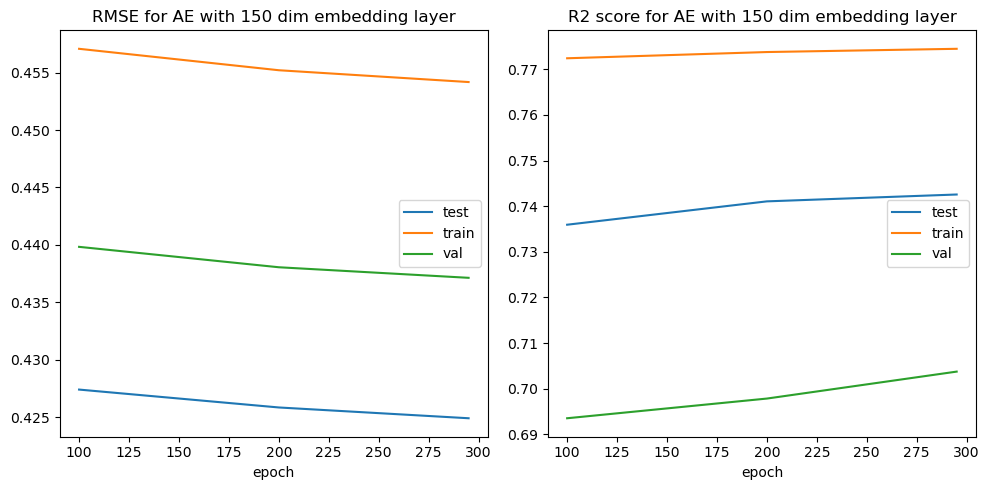

In [90]:
plot_R2_rmse_scores(reg_metrics)

### Baseline - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

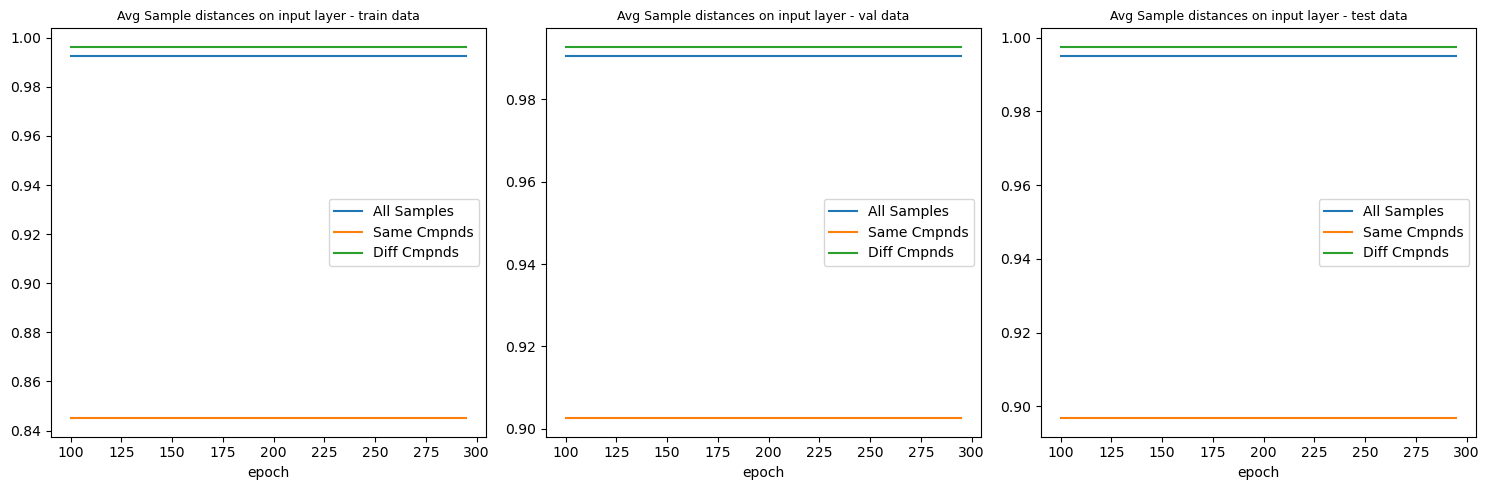

In [91]:
plot_distances(group_metrics, layer = 'inp')

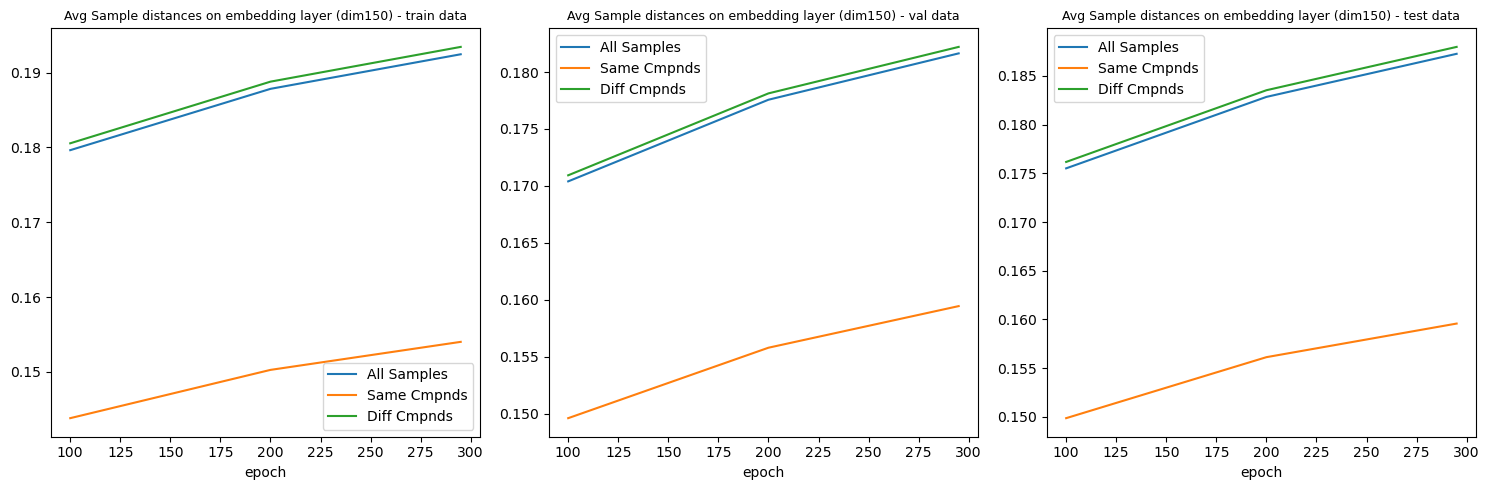

In [92]:
plot_distances(group_metrics, layer = 'emb')

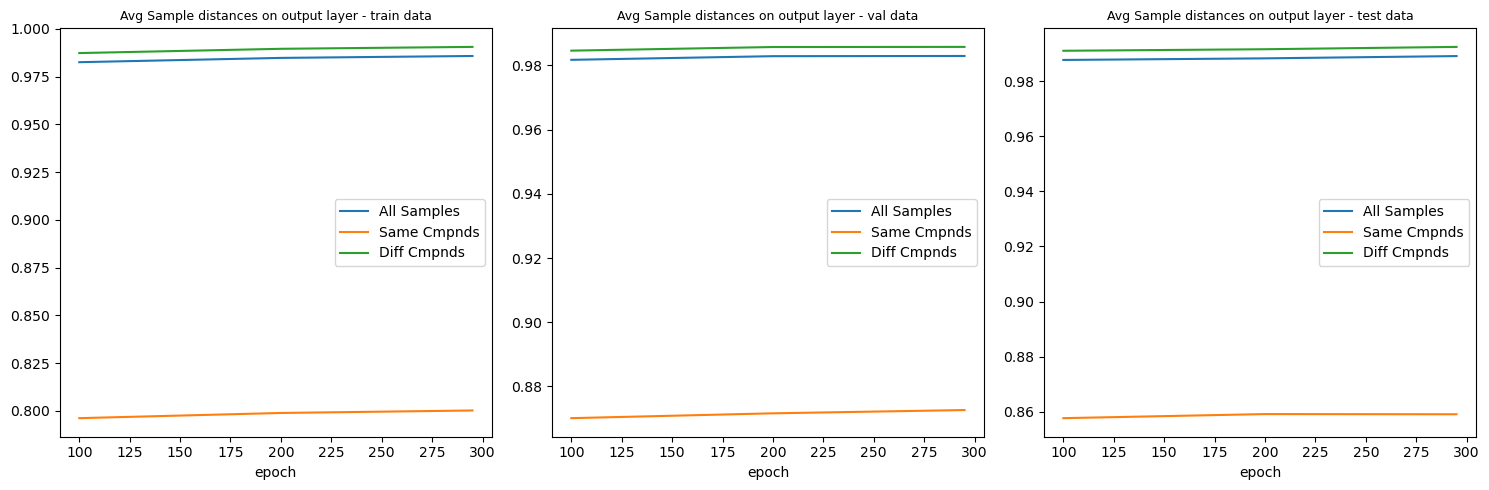

In [93]:
plot_distances(group_metrics, layer = 'out')

### Plot Pairwise distance matrix 

<class 'numpy.ndarray'>


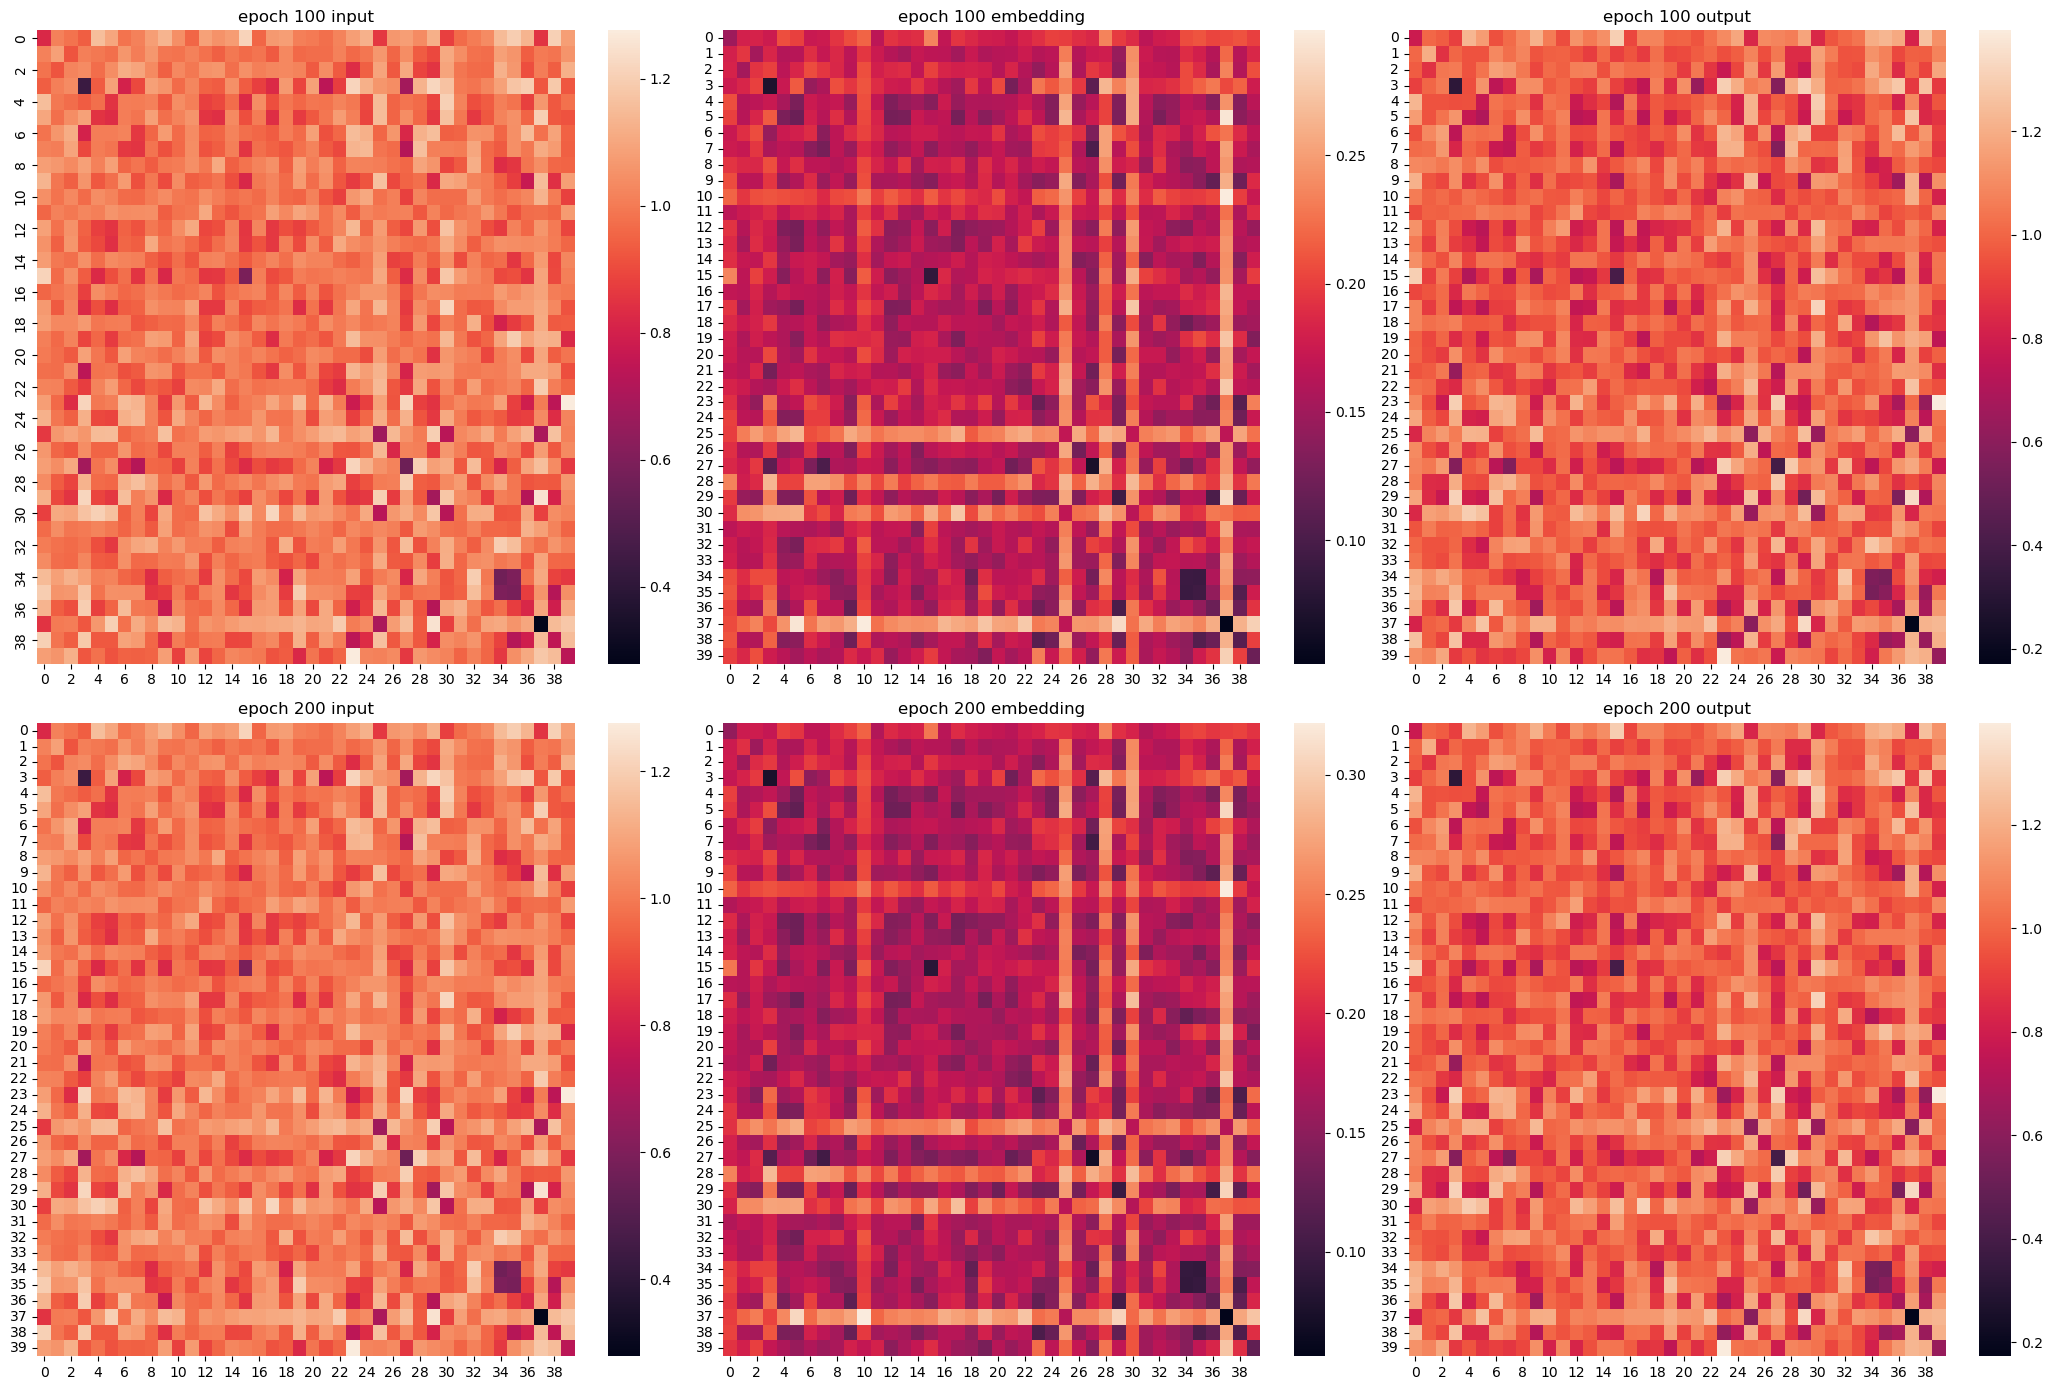

In [95]:
plot_epochs = [100, 200]
utils.plot_distance_matrices(grp_level_dict, data = 'train', epochs = plot_epochs, annot = False)

## SNNL Model with weight Decay = 0.001, SNNL Factor = 3

### files

In [100]:
load_filename = 'AE_snnl_20240904_2352_wd_0.001_snnlfactor_3_cpb_400_distmtrcs_40_samples_20240905_1931.pkl'
loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.001'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

 load_metrics(): load  data from ./results/WD_0.001/AE_snnl_20240904_2352_wd_0.001_snnlfactor_3_cpb_400_distmtrcs_40_samples_20240905_1931.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

### SNNL - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

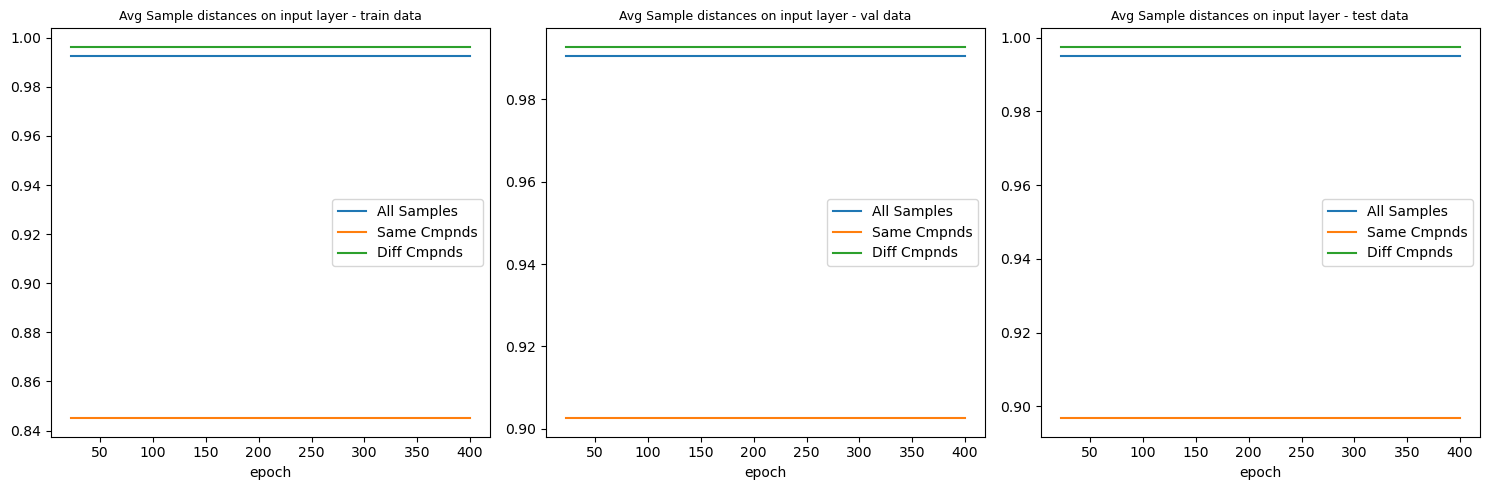

In [101]:
plot_distances(group_metrics, layer = 'inp')

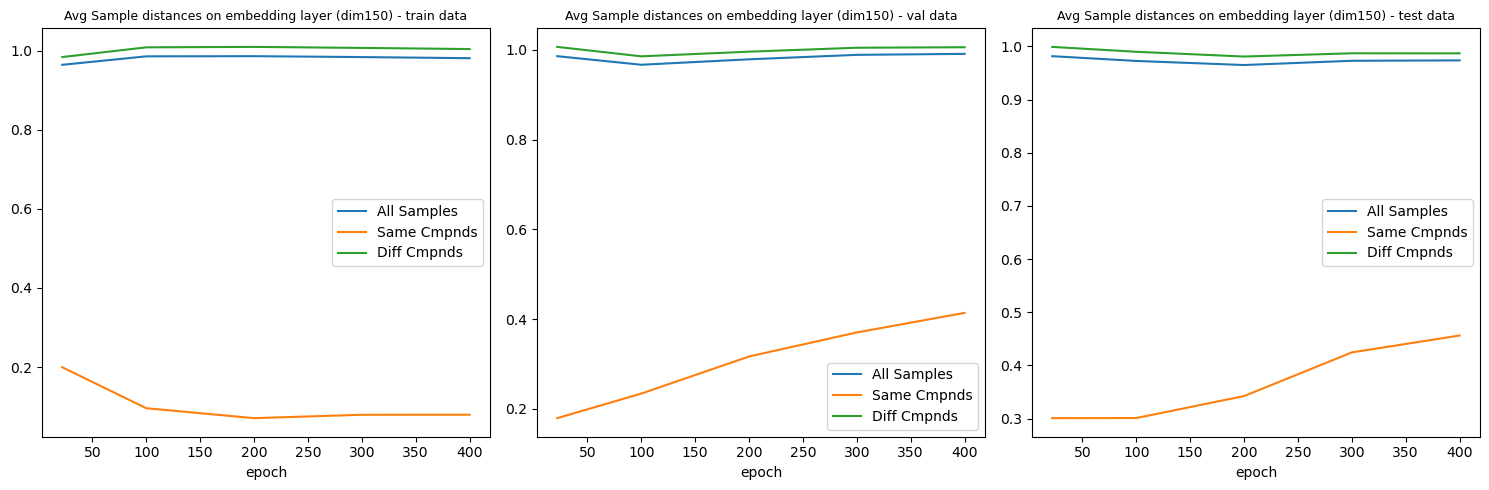

In [102]:
plot_distances(group_metrics, layer = 'emb')

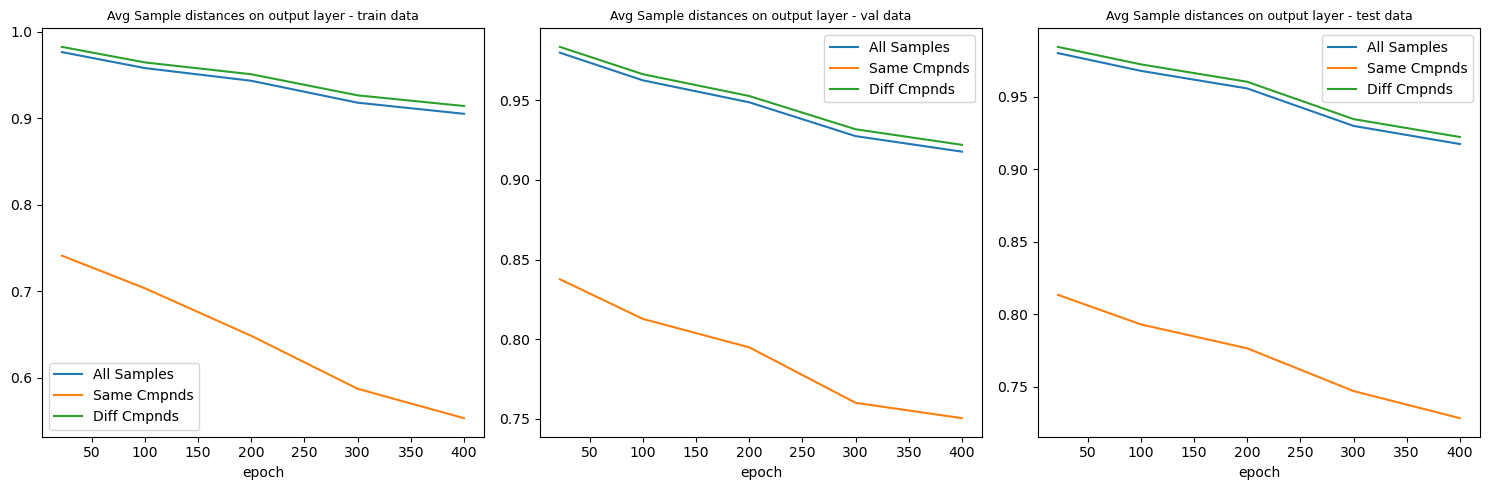

In [103]:
plot_distances(group_metrics, layer = 'out')

### SNNL  - Plot R2 and RMSE score 

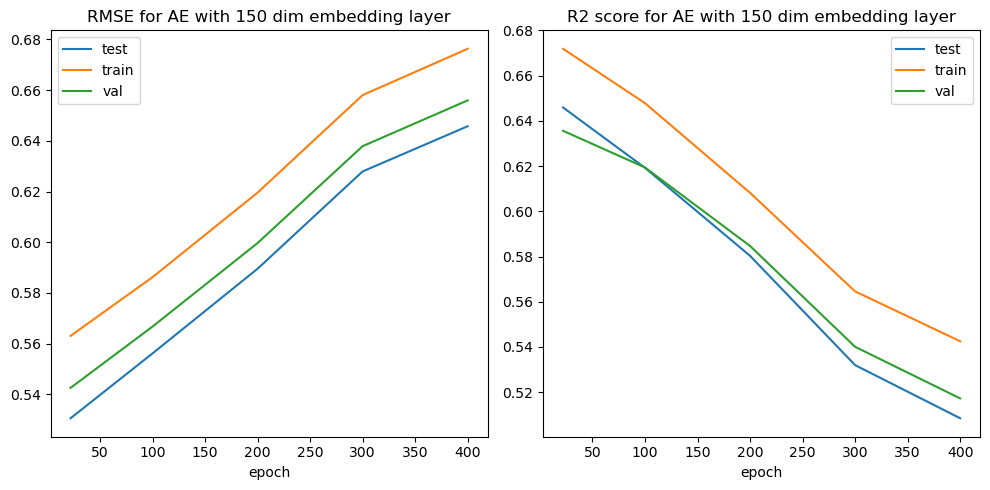

In [104]:
plot_R2_rmse_scores(reg_metrics)

### Plot Pairwise distance matrix 

<class 'numpy.ndarray'>


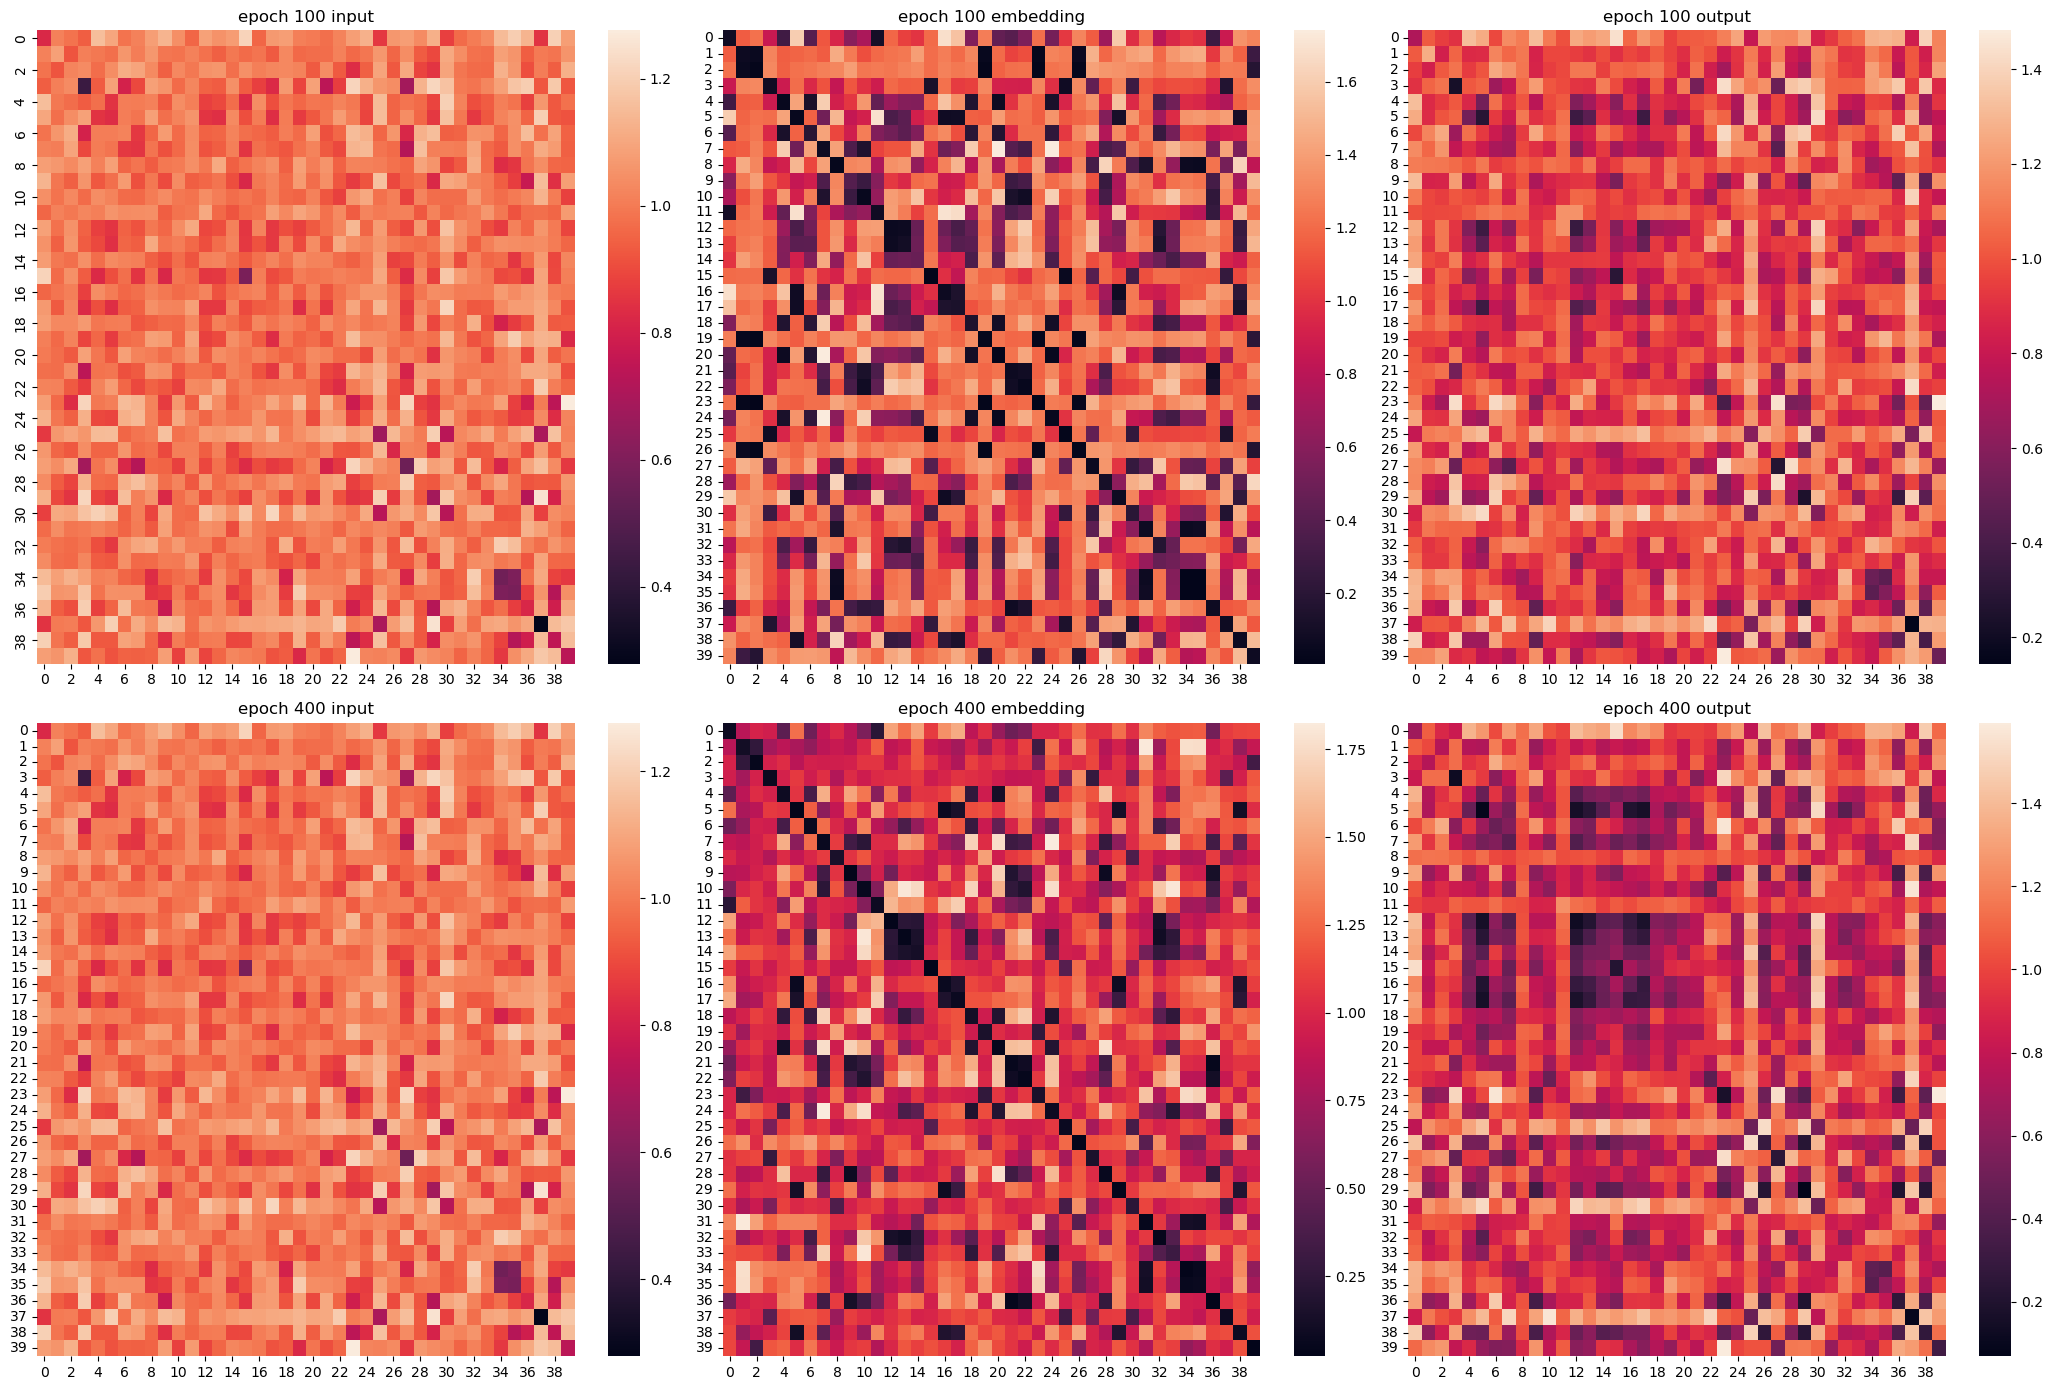

In [105]:
plot_epochs = [100, 400]
utils.plot_distance_matrices(grp_level_dict, data = 'train', epochs = plot_epochs, annot = False)

## SNNL Model with weight Decay = 0.001, SNNL Factor = 3, Latent Dim = 250

### files

In [40]:
load_filename = 'AE_base_20240917_2017_wd_0.001_distmtrcs_40_samples_20240905_2135.pkl'
loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.001'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

 load_metrics(): load  data from ./results/WD_0.001/AE_base_20240917_2017_wd_0.001_distmtrcs_40_samples_20240905_2135.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

### SNNL - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

In [78]:
# plot_distances(group_metrics, layer = 'inp')

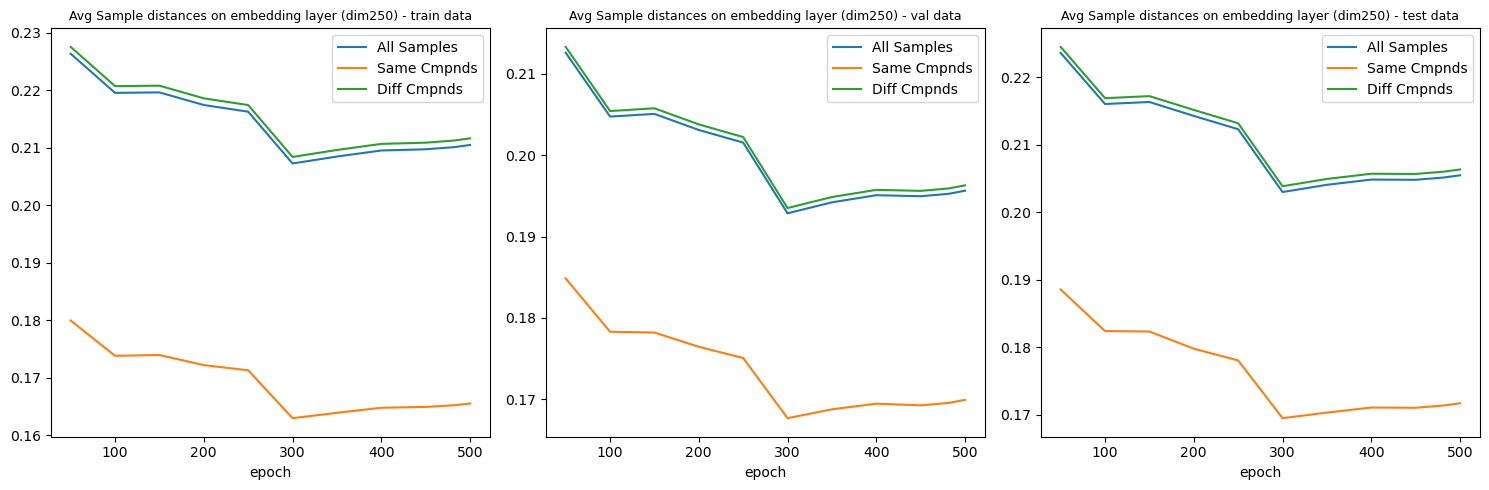

In [41]:
plot_distances(group_metrics, layer = 'emb')

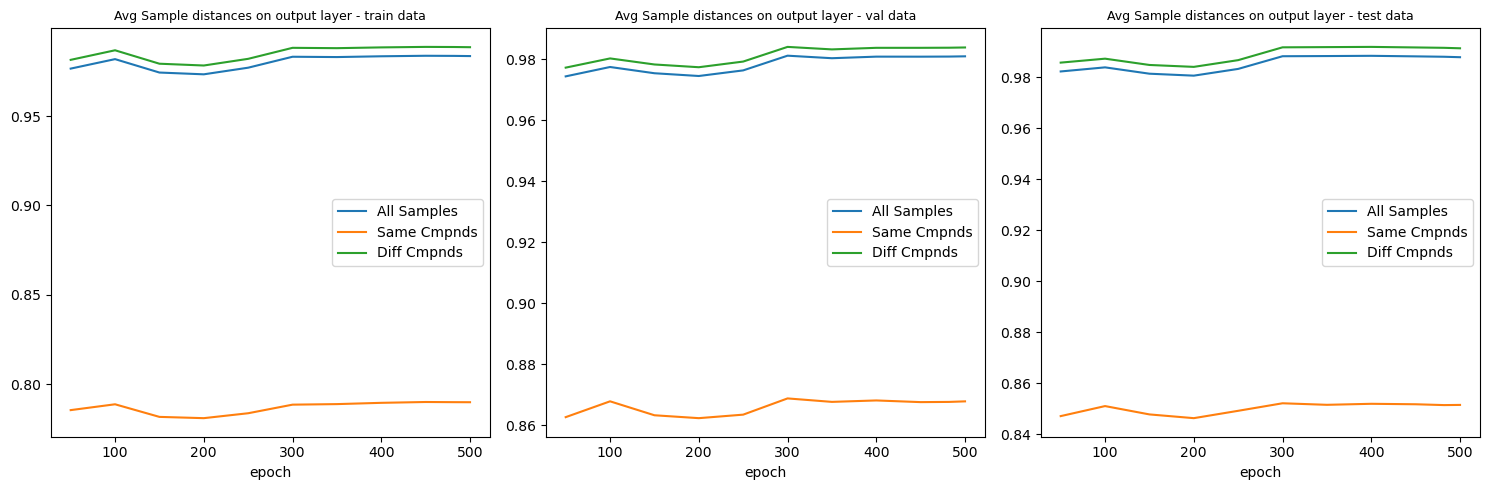

In [42]:
plot_distances(group_metrics, layer = 'out')

### SNNL  - Plot R2 and RMSE score 

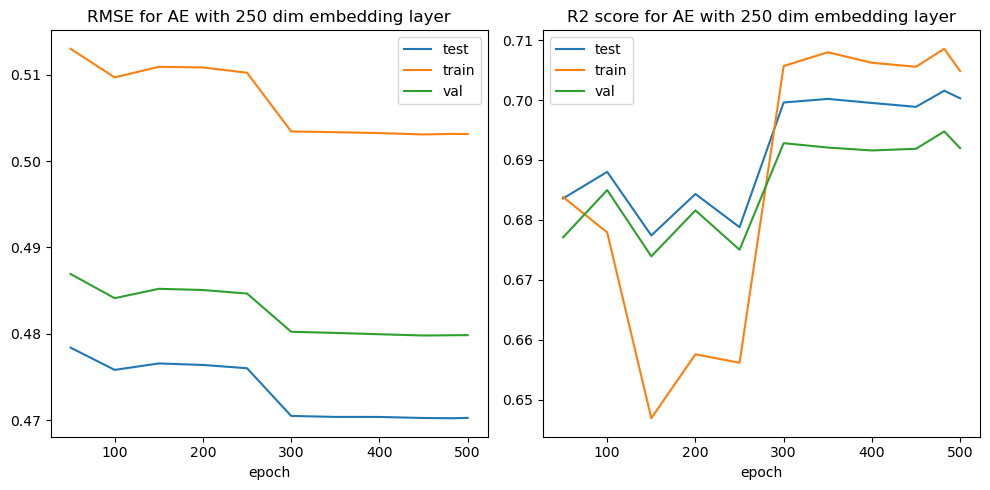

In [43]:
plot_R2_rmse_scores(reg_metrics)

### Plot Pairwise distance matrix 

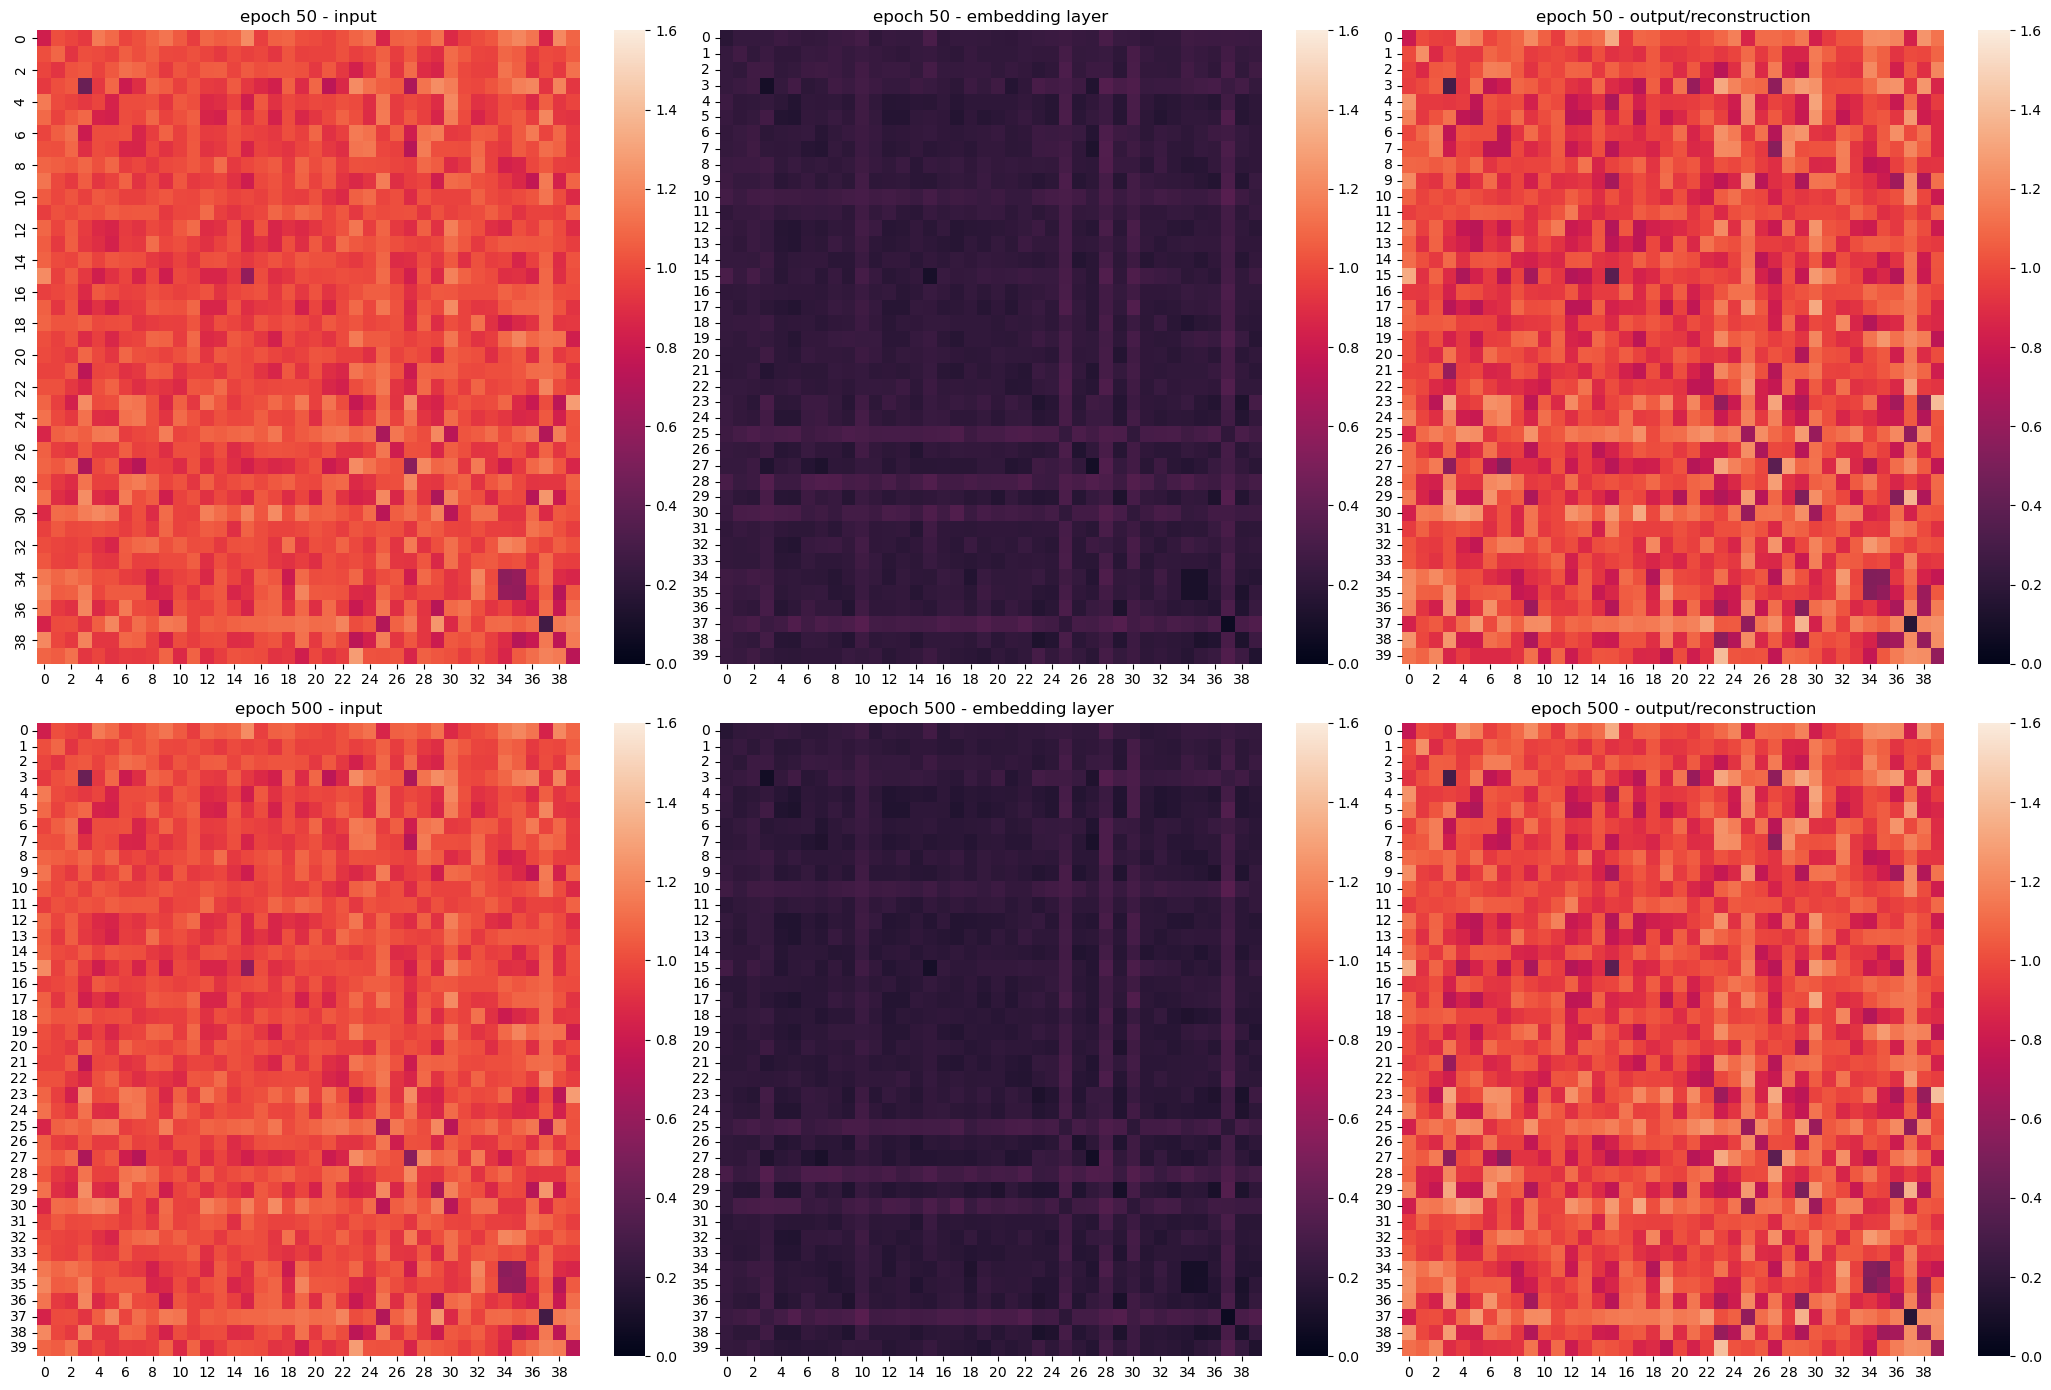

In [46]:
plot_epochs = [50, 500]
utils.plot_distance_matrices(grp_level_dict, data = 'train', epochs = plot_epochs, annot = False)

## SNNL Model with weight Decay = 0.001, SNNL Factor = 30

In [106]:
load_filename = 'AE_snnl_20240904_2356_wd_0.001_snnlfactor_30_distmtrcs_40_samples_20240905_1931.pkl'
loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.001'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

 load_metrics(): load  data from ./results/WD_0.001/AE_snnl_20240904_2356_wd_0.001_snnlfactor_30_distmtrcs_40_samples_20240905_1931.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

### SNNL - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

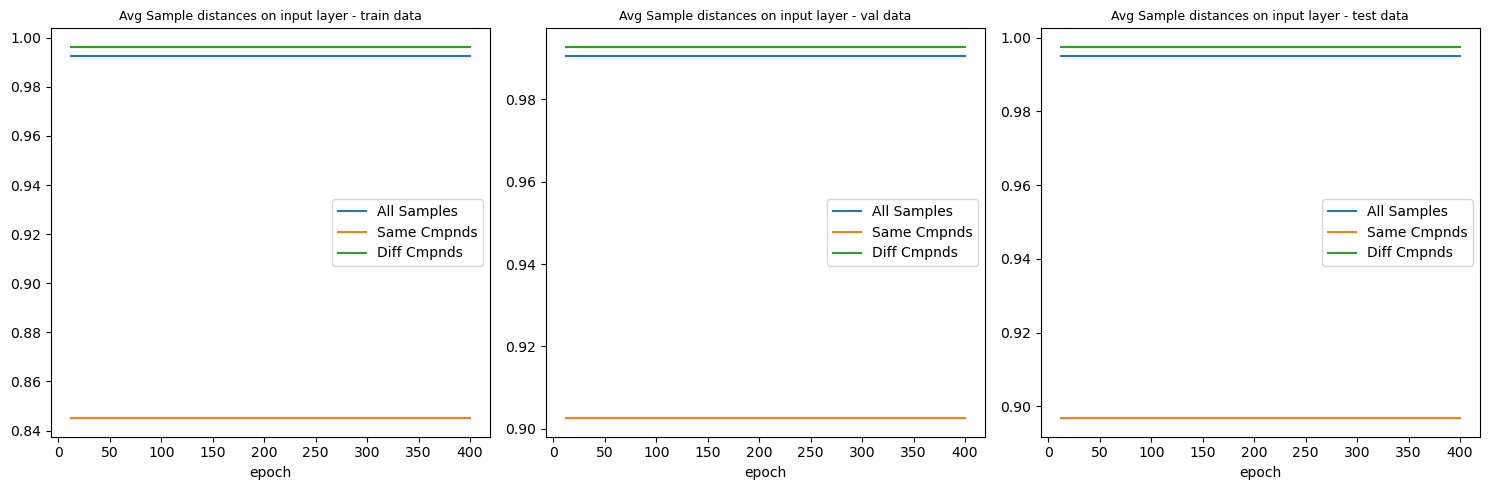

In [107]:
plot_distances(group_metrics, layer = 'inp')

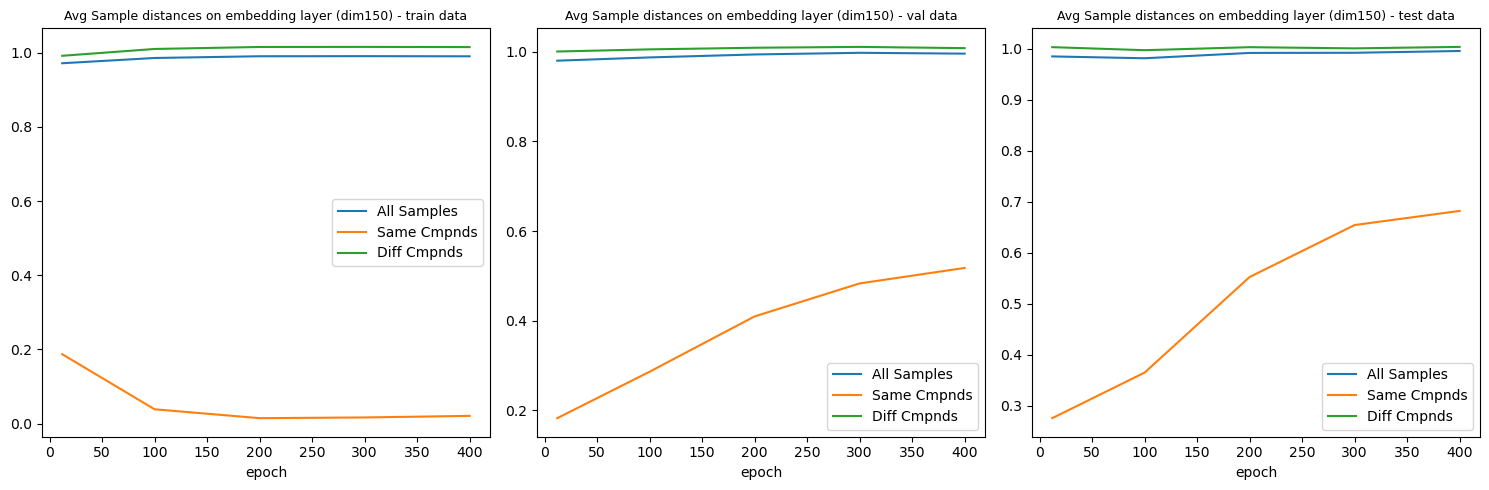

In [108]:
plot_distances(group_metrics, layer = 'emb')

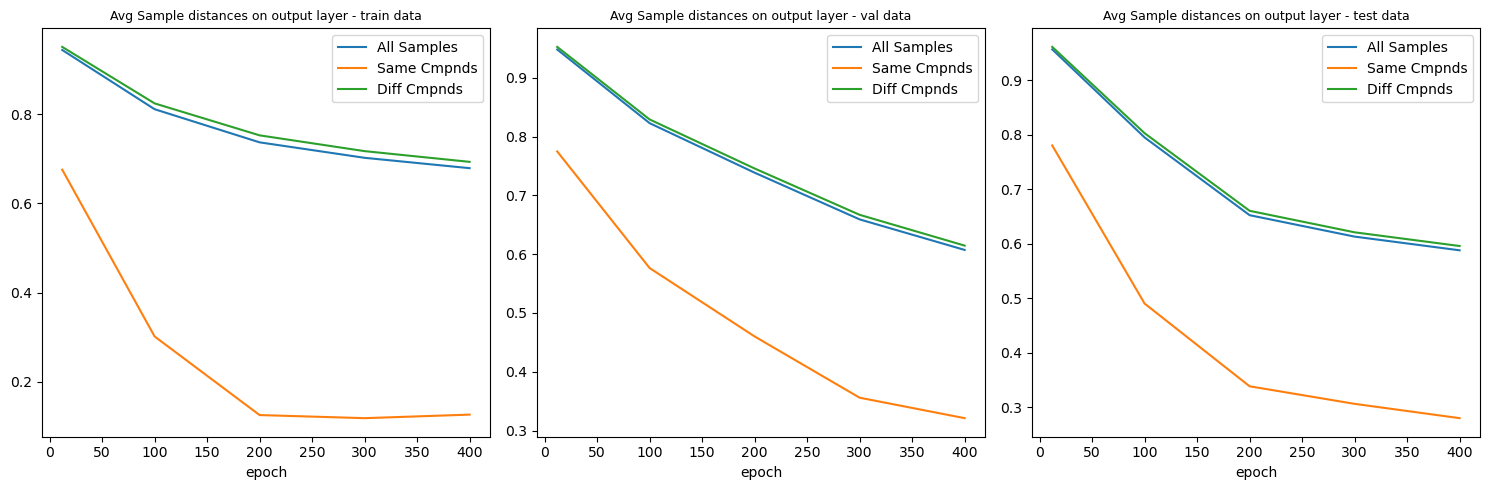

In [109]:
plot_distances(group_metrics, layer = 'out')

### SNNL  - Plot R2 and RMSE score 

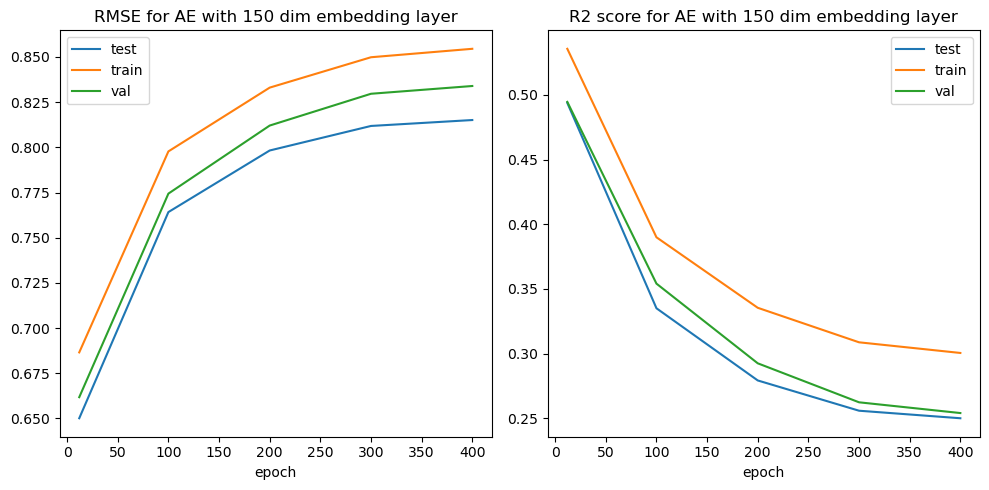

In [110]:
plot_R2_rmse_scores(reg_metrics)

### Plot Pairwise distance matrix 

<class 'numpy.ndarray'>


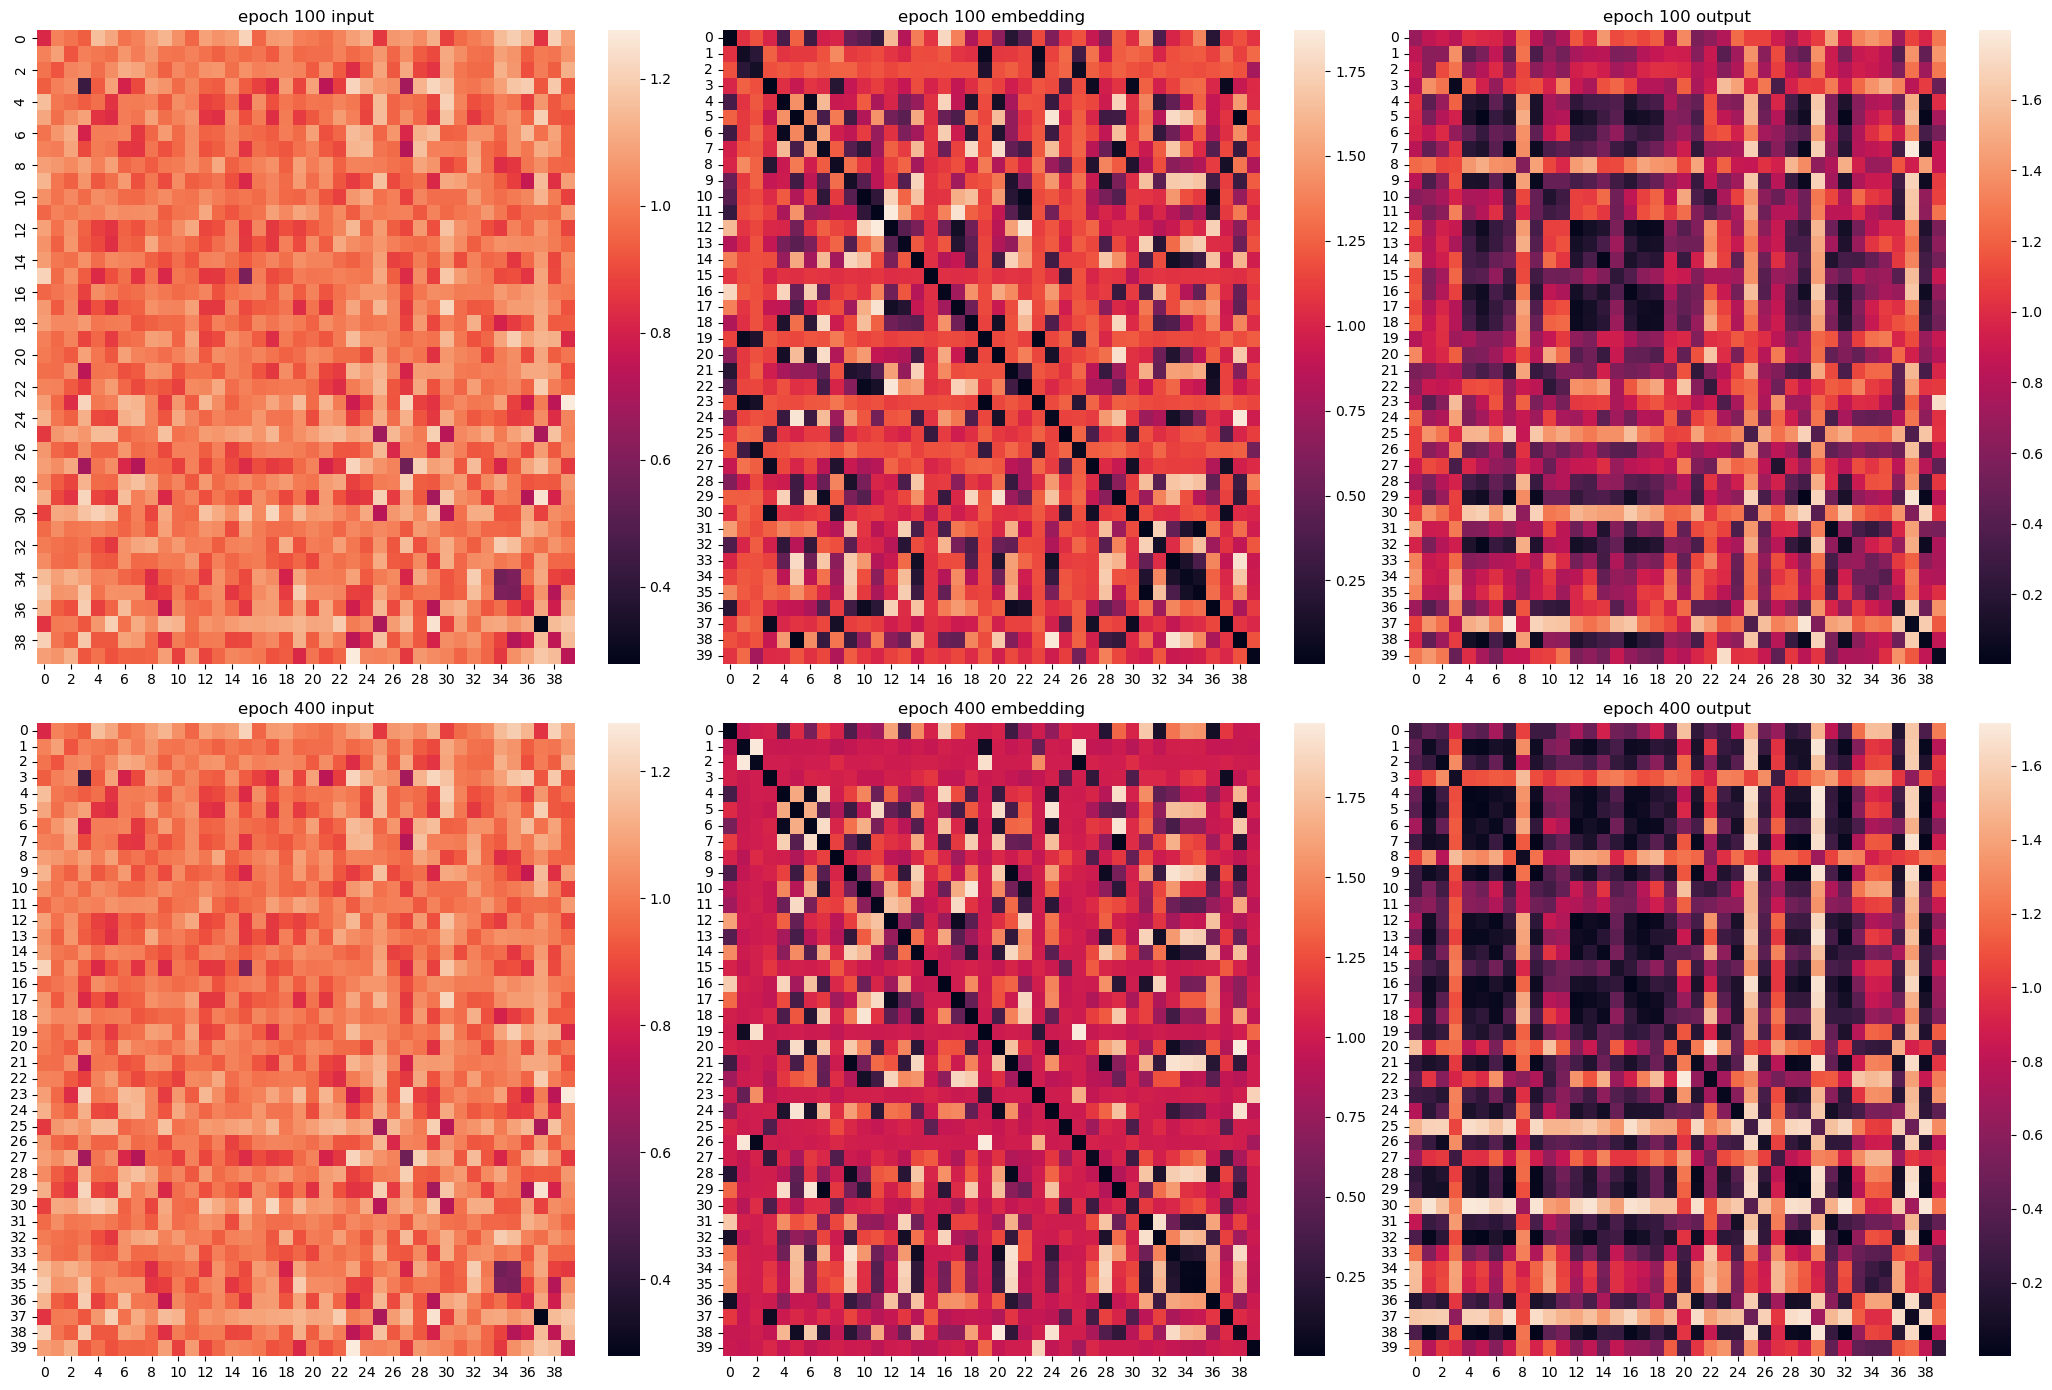

In [112]:
plot_epochs = [100, 400]
utils.plot_distance_matrices(grp_level_dict, data= 'train', epochs = plot_epochs, annot = False)

# Results for experiments with Weight Decay = 0.0 

## Baseline Model with no weight Decay 

In [30]:
# load_filename = 'AE_base_20240830_2302_wd_0.0_distmtrcs_20_samples_20240903_1930.pkl'
# load_filename = 'AE_base_20240830_2302_wd_0.0_distmtrcs_40_samples_20240903_1930.pkl'
load_filename = 'AE_base_20240830_2302_wd_0.0_distmtrcs_40_samples_20240905_2055.pkl'
# load_filename = 'AE_base_20240903_1930_wd_0.0_distmtrcs_40_samples_20240904_0010.pkl'1
load_filename

loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.0'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

'AE_base_20240830_2302_wd_0.0_distmtrcs_40_samples_20240905_2055.pkl'

 load_metrics(): load  data from ./results/WD_0.0/AE_base_20240830_2302_wd_0.0_distmtrcs_40_samples_20240905_2055.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

### Baseline - Plot R2 and RMSE score 

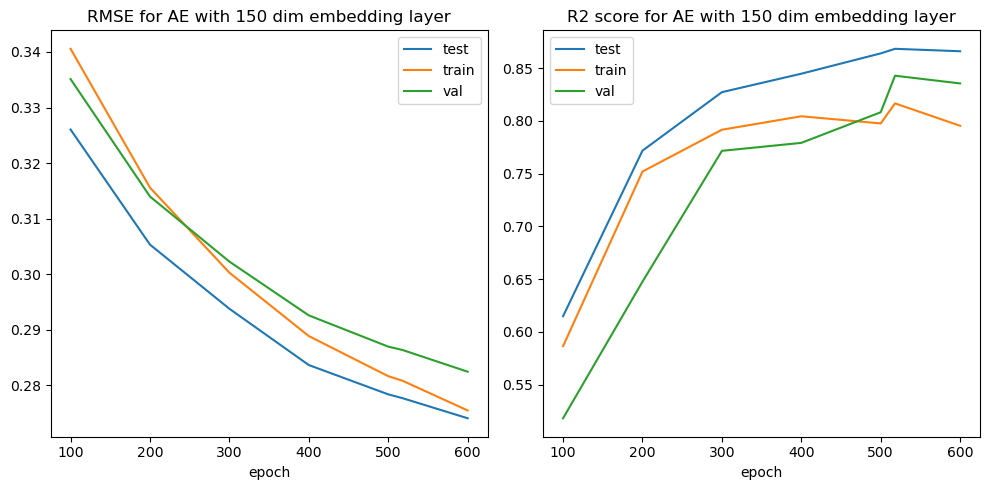

In [31]:
plot_R2_rmse_scores(reg_metrics)

### Baseline - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

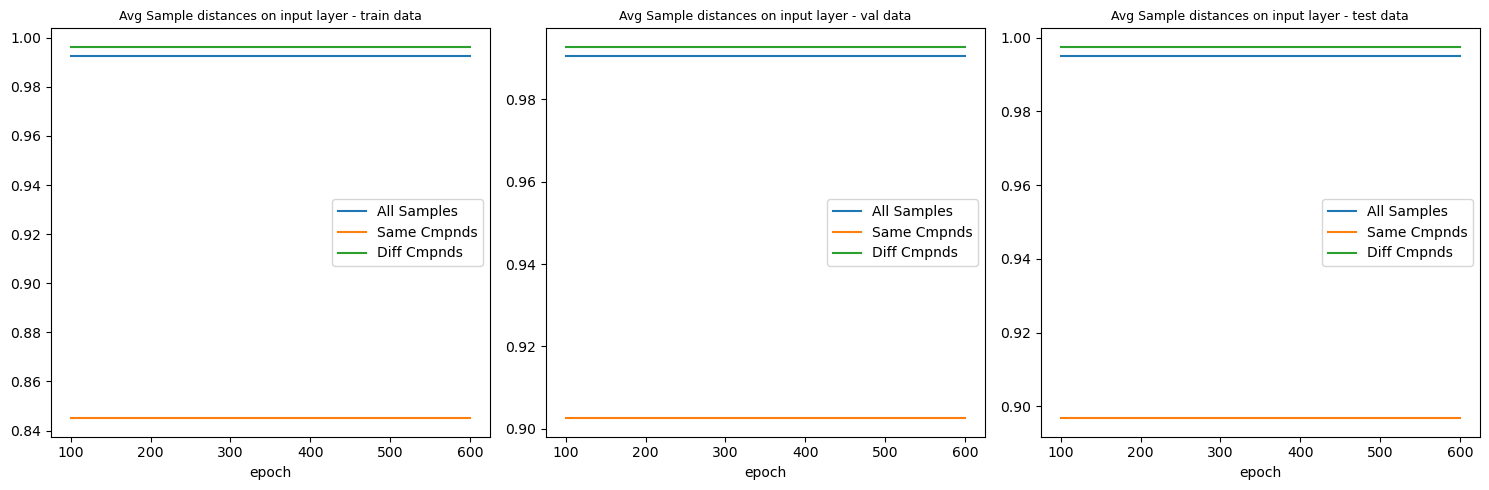

In [32]:
plot_distances(group_metrics, layer = 'inp')

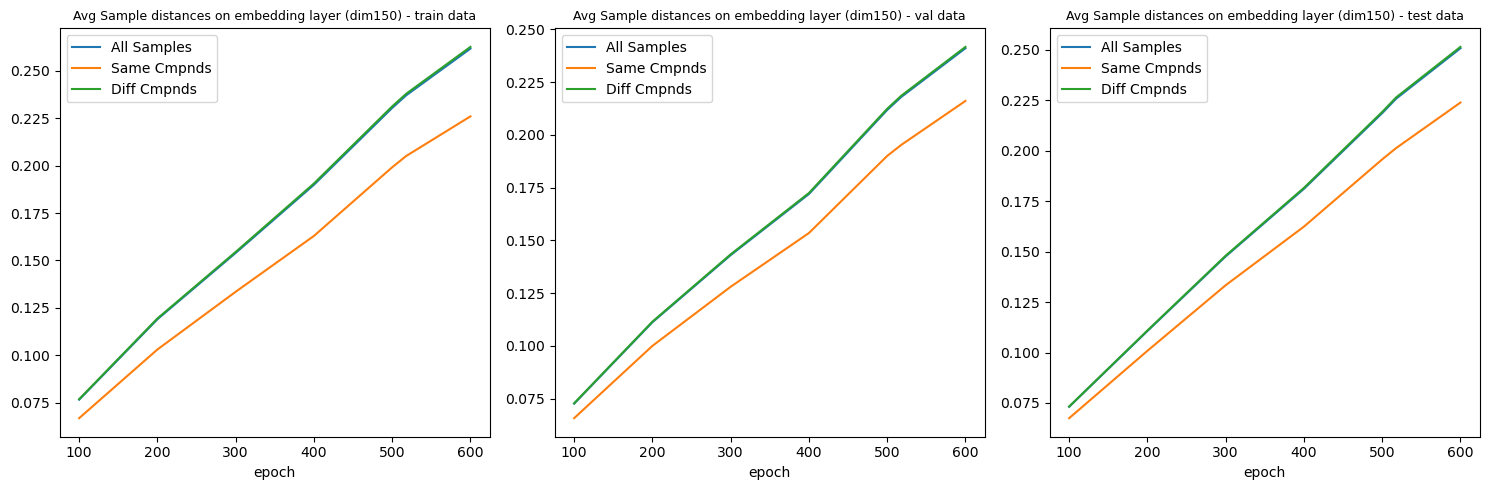

In [33]:
plot_distances(group_metrics, layer = 'emb')

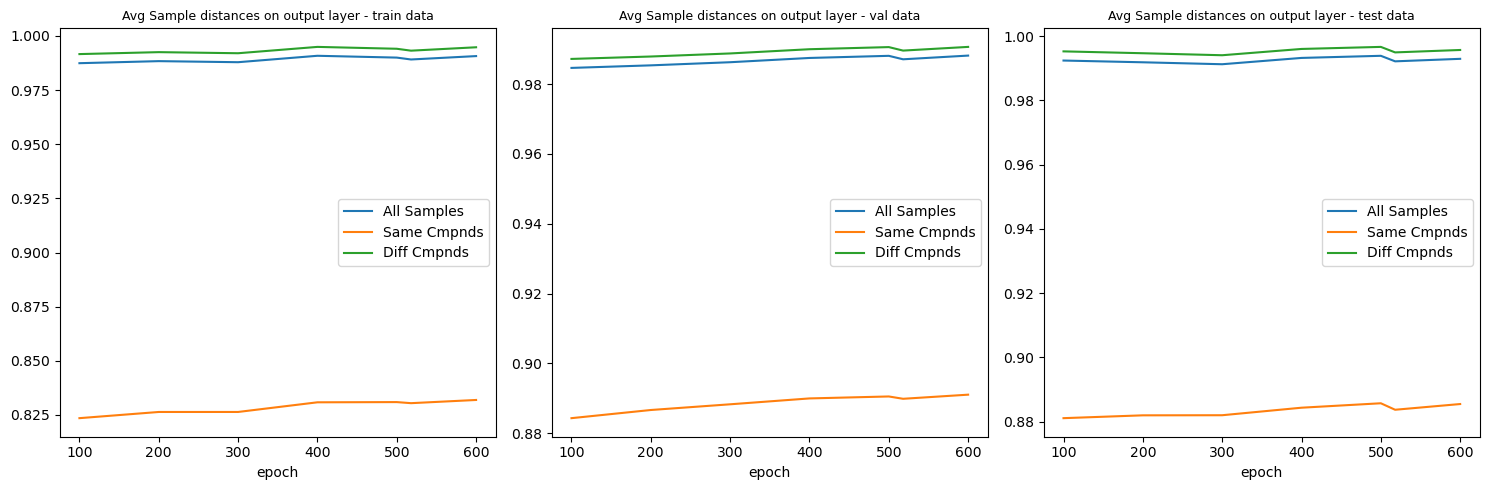

In [34]:
plot_distances(group_metrics, layer = 'out')

### Plot Pairwise distance matrix 

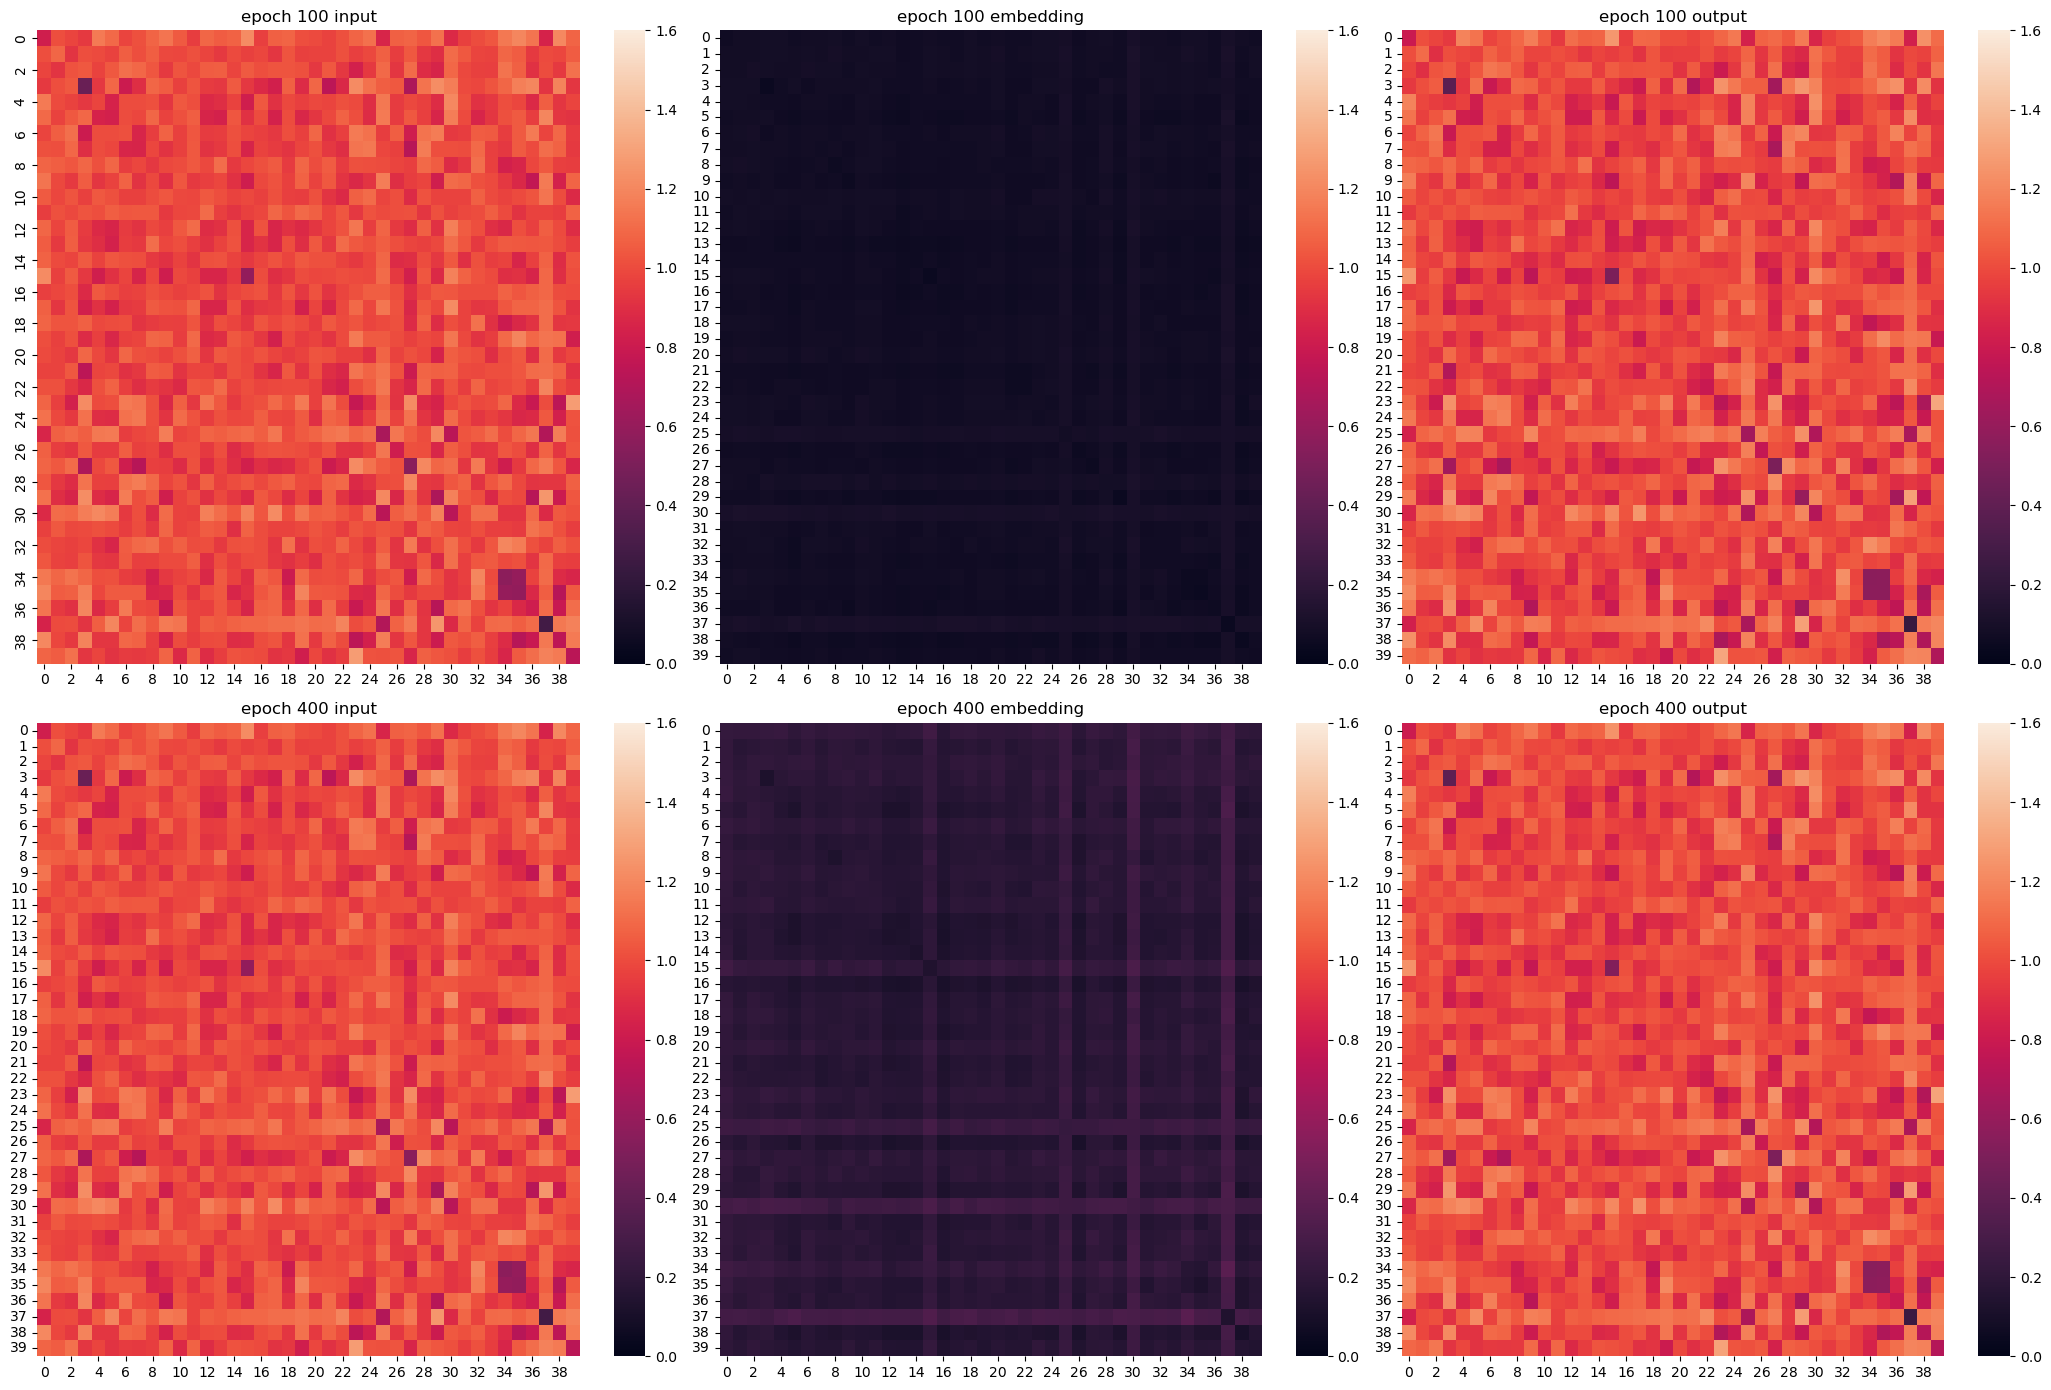

In [35]:
plot_epochs = [100, 400]
utils.plot_distance_matrices(grp_level_dict, data= 'train', epochs = plot_epochs, annot = False)

## SNNL Model - No weight decay - SNNL Factor 3.0

### SNNL - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

In [37]:
# load_filename = 'AE_snnl_20240830_2244_wd_0.0_snnlfactor_3_distmtrcs_20_samples_20240831_1908.pkl'
# load_filename = 'AE_snnl_20240830_2244_wd_0.0_snnlfactor_3_distmtrcs_40_samples_20240903_1805.pkl'
load_filename = 'AE_snnl_20240830_2244_wd_0.0_snnlfactor_3_distmtrcs_40_samples_20240905_2055.pkl'
load_filename

loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.0'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

'AE_snnl_20240830_2244_wd_0.0_snnlfactor_3_distmtrcs_40_samples_20240905_2055.pkl'

 load_metrics(): load  data from ./results/WD_0.0/AE_snnl_20240830_2244_wd_0.0_snnlfactor_3_distmtrcs_40_samples_20240905_2055.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

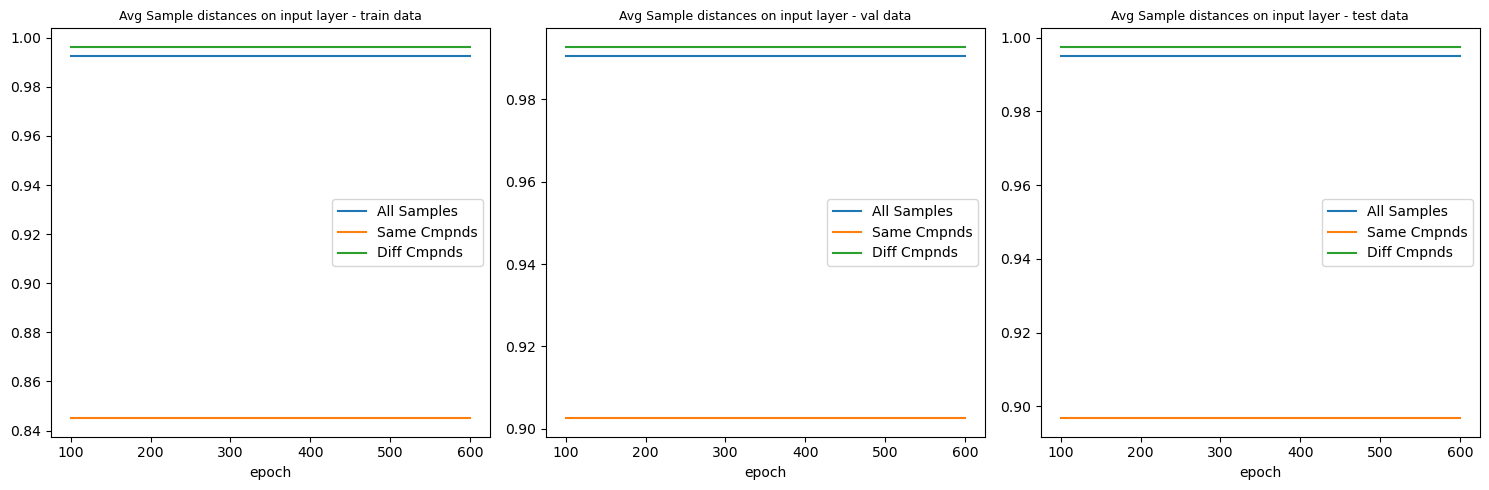

In [38]:
plot_distances(group_metrics, layer = 'inp')

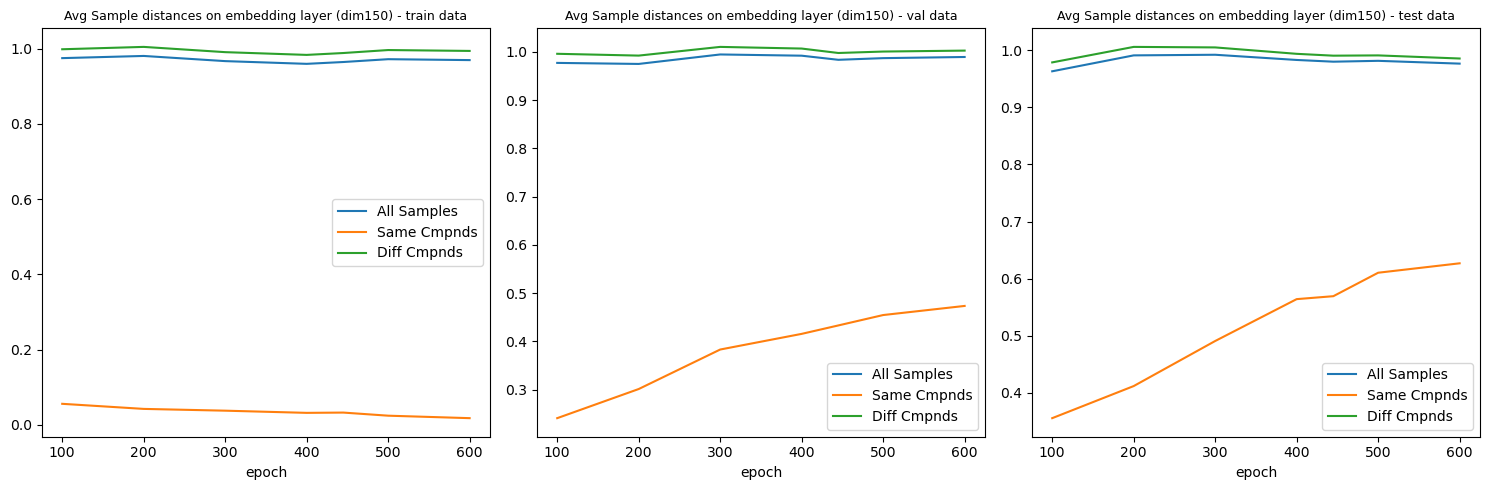

In [39]:
plot_distances(group_metrics, layer = 'emb')

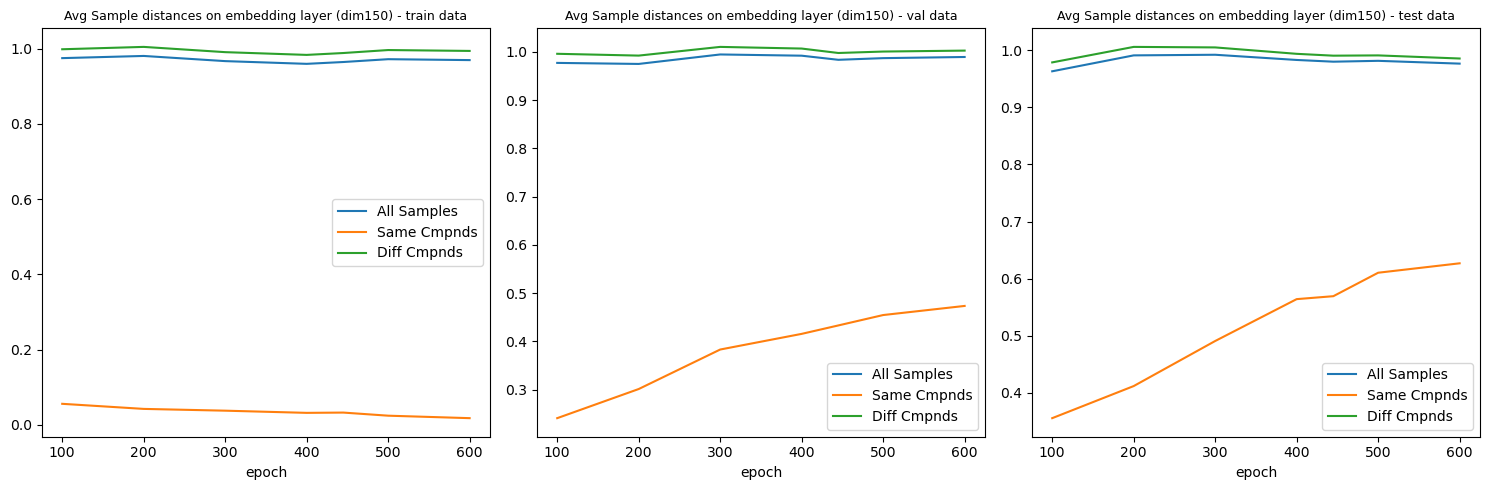

In [40]:
plot_distances(group_metrics, layer = 'emb')

### SNNL - Plot R2 and RMSE score 

Autoencoder with SNNL regularization , embedding 150 dim

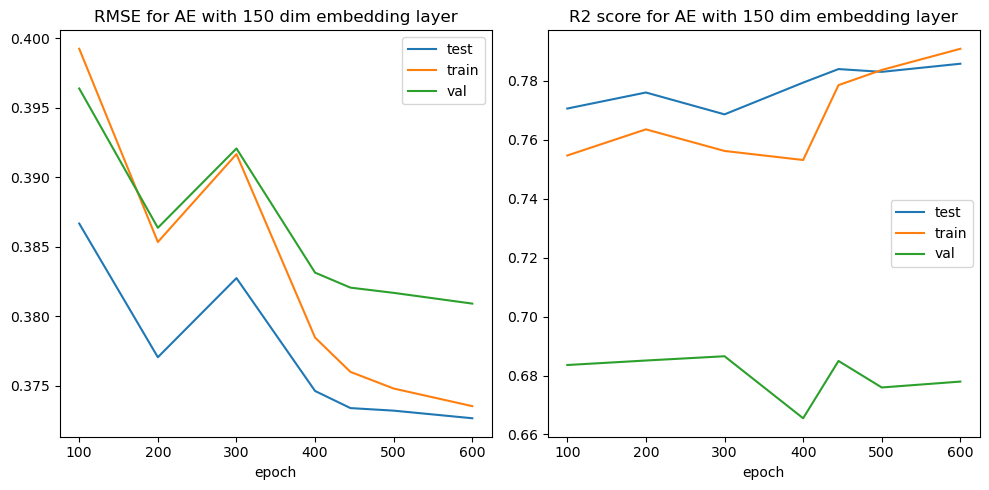

In [41]:
plot_R2_rmse_scores(reg_metrics)

### Plot Pairwise distance matrix 

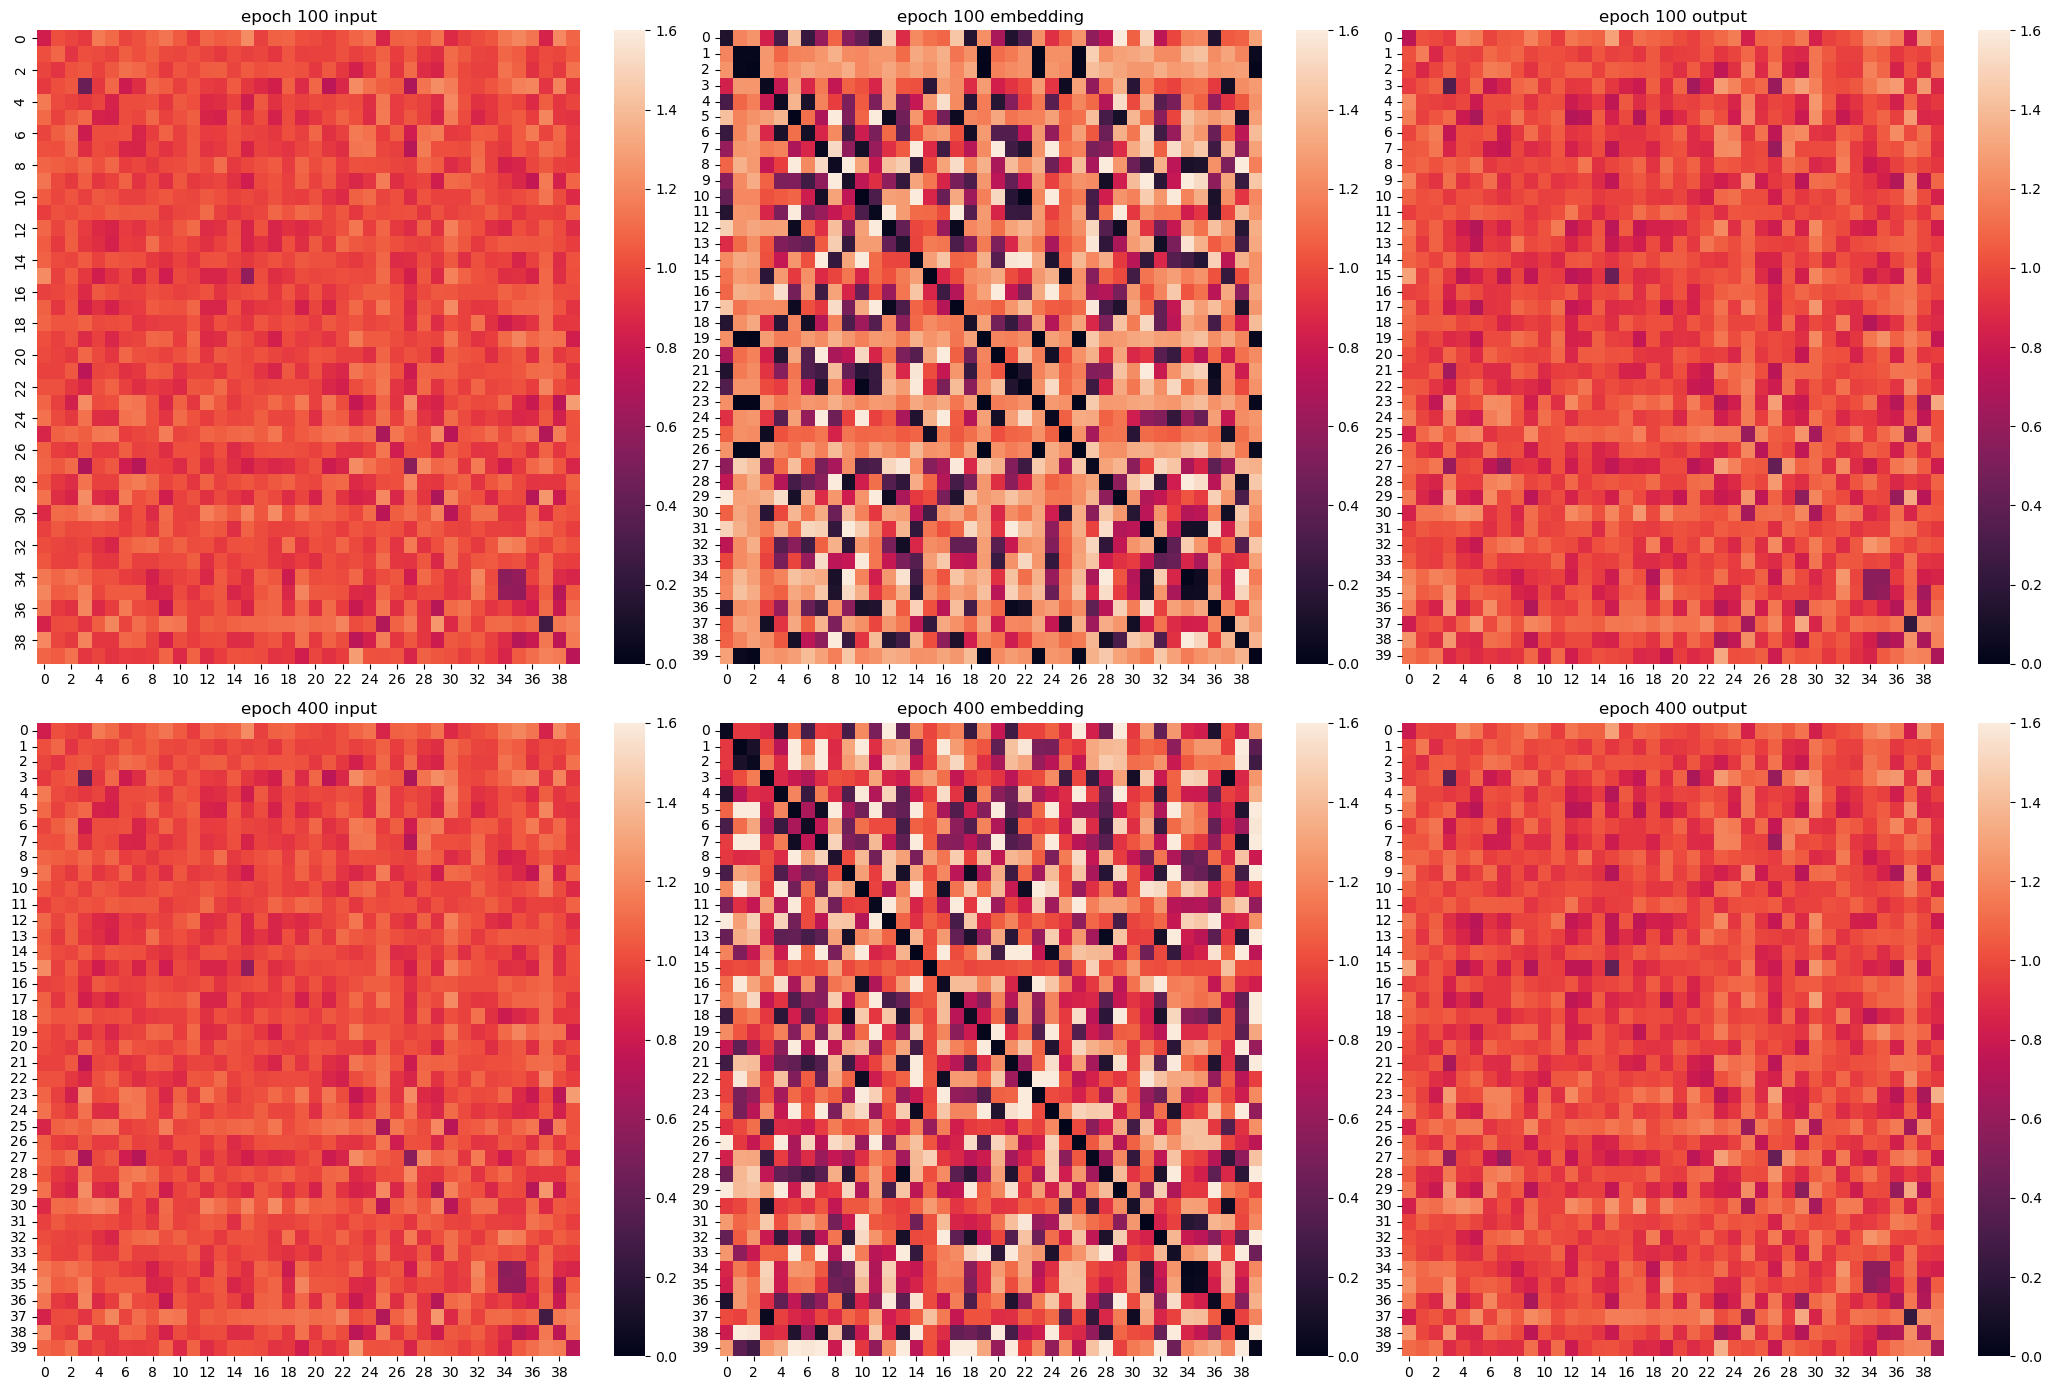

In [42]:
plot_epochs = [100, 400]
utils.plot_distance_matrices(grp_level_dict, data= 'train', epochs = plot_epochs, annot = False)

## SNNL Model - No weight decay - SNNL Factor 30.0

### SNNL - Plot Distances 

Autoencoder with SNNL regularization , embedding 150 dim

In [51]:
# load_filename = 'AE_snnl_20240830_2251_wd_0.0_snnlfactor_30_distmtrcs_20_samples_20240831_1918.pkl'
load_filename = 'AE_snnl_20240830_2251_wd_0.0_snnlfactor_30_distmtrcs_40_samples_20240905_2055.pkl'
load_filename

loaded_data = load_from_pickle(os.path.join(args.paths['result_dir'], 'WD_0.0'), load_filename, verbose = True)
loaded_data.keys()

reg_metrics = loaded_data['df_reg_metrics']
group_metrics = loaded_data['df_group_metrics']
sample_metrics = loaded_data['df_sample_metrics']
grp_level_dict = loaded_data['grp_level_dict']
del loaded_data

'AE_snnl_20240830_2251_wd_0.0_snnlfactor_30_distmtrcs_40_samples_20240905_2055.pkl'

 load_metrics(): load  data from ./results/WD_0.0/AE_snnl_20240830_2251_wd_0.0_snnlfactor_30_distmtrcs_40_samples_20240905_2055.pkl


dict_keys(['df_reg_metrics', 'df_group_metrics', 'df_sample_metrics', 'grp_level_dict'])

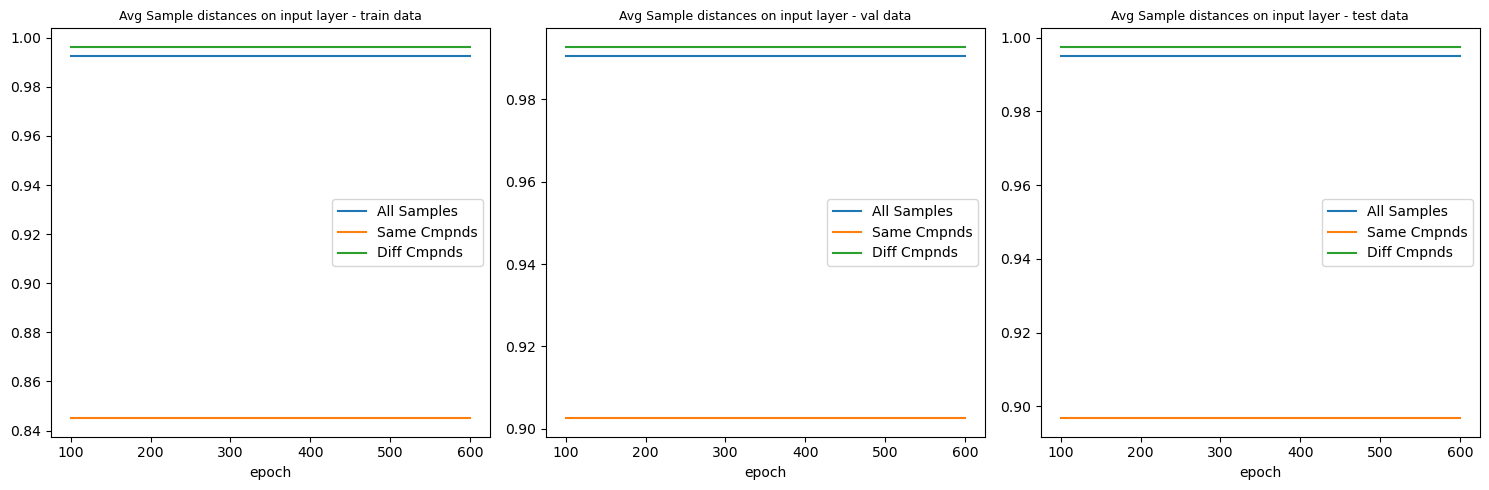

In [52]:
plot_distances(group_metrics, layer = 'inp')

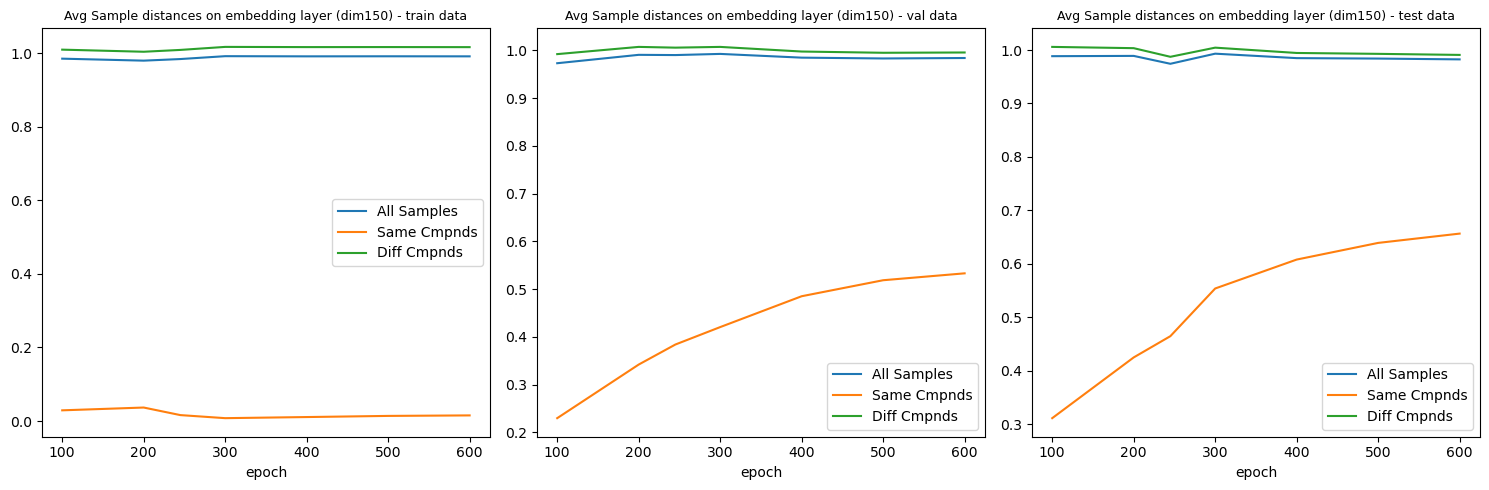

In [53]:
plot_distances(group_metrics, layer = 'emb')

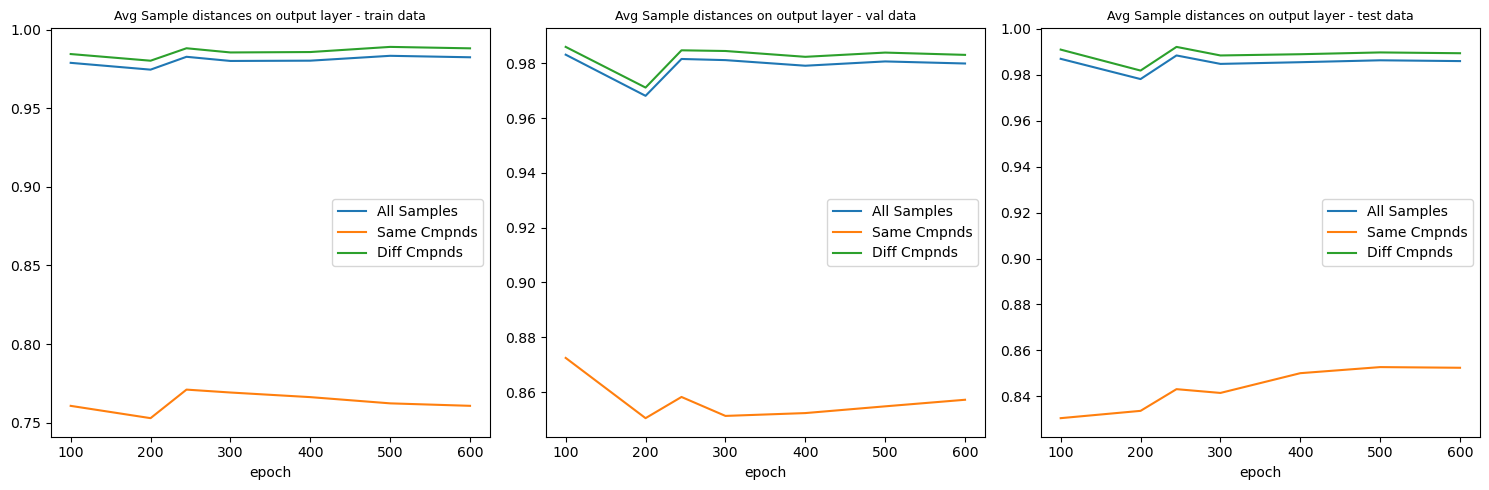

In [54]:
plot_distances(group_metrics, layer = 'out')

  ### SNNL - Plot R2 and RMSE score 


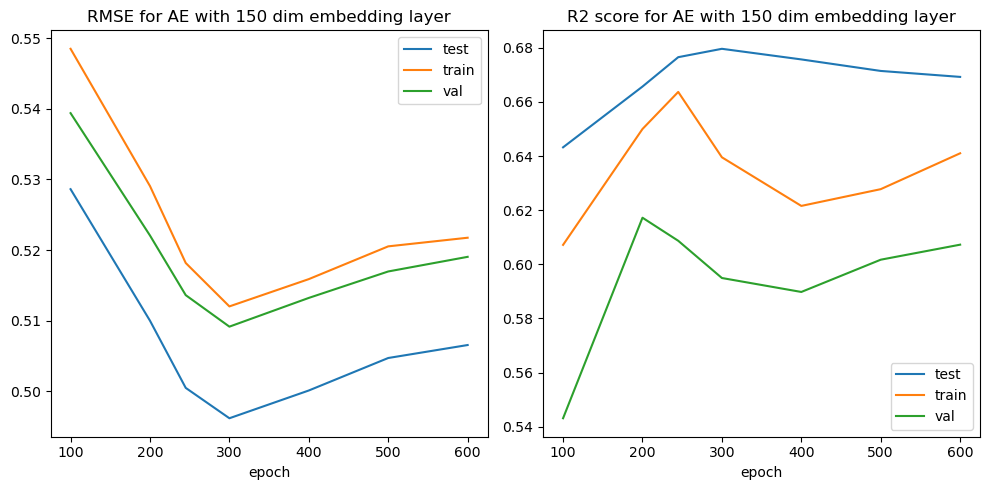

In [55]:
plot_R2_rmse_scores(reg_metrics)

### Plot Pairwise distance matrix 

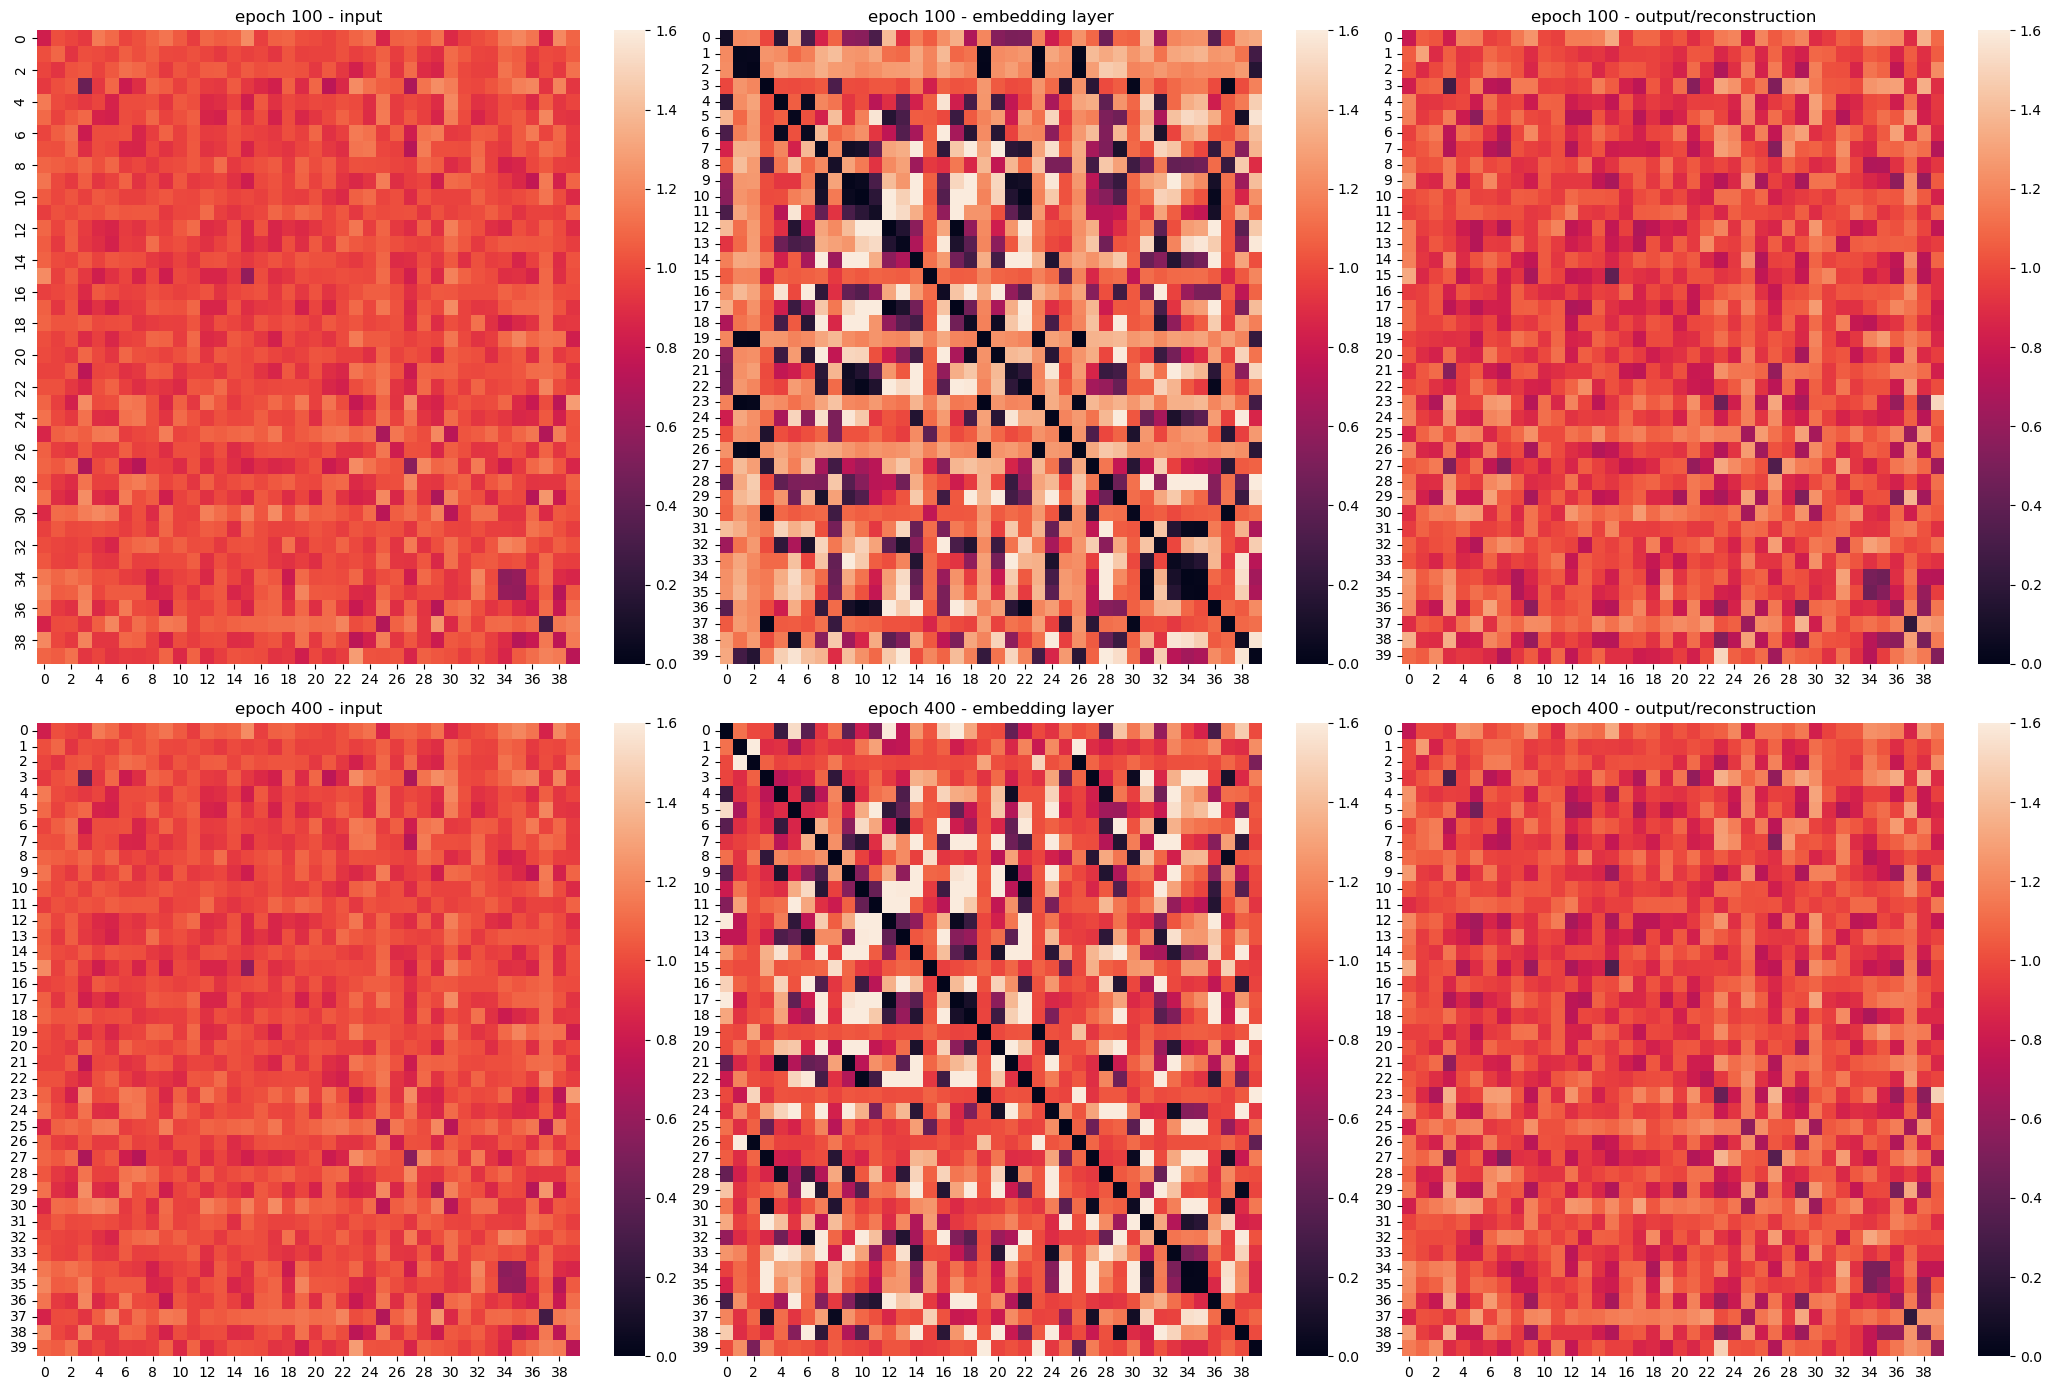

In [56]:
plot_epochs = [100, 400]
utils.plot_distance_matrices(grp_level_dict, data= 'train', epochs = plot_epochs, annot = False)

# 

# Baseline v SNNL 

## Baseline v SNNL 

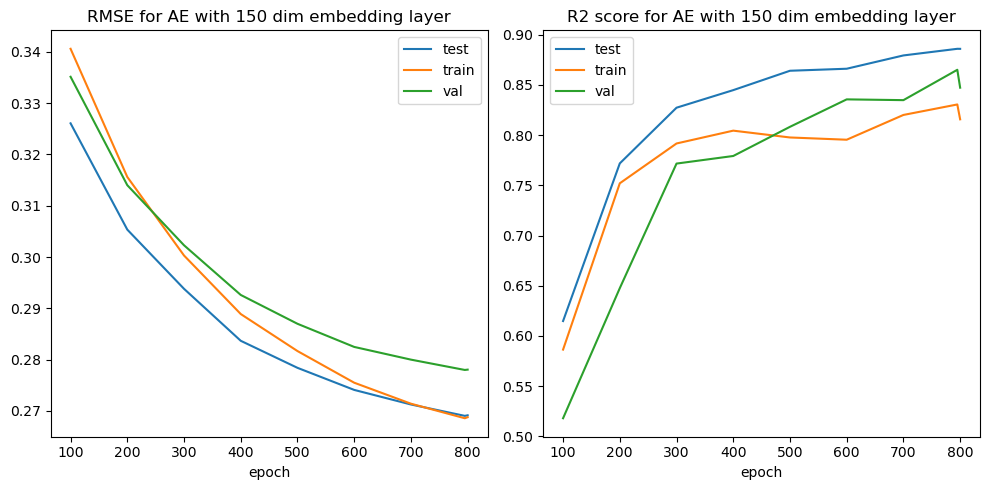

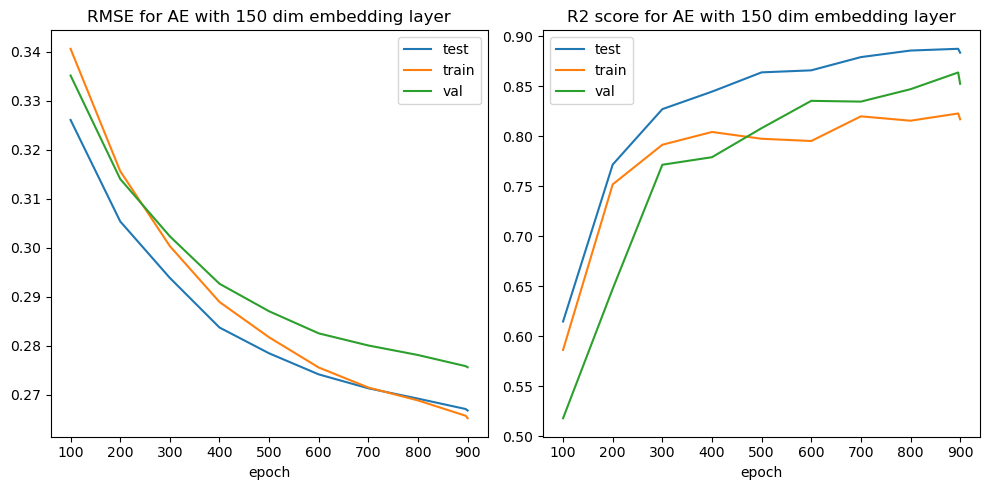

In [52]:
plot_R2_rmse_scores(baseline_reg_metrics)
plot_R2_rmse_scores(snnl_reg_metrics)

## Plot Pairwise distance matrix 

Autoencoder with SNNL regularization , embedding 50 dim

Merge train, validation, and test regression metrics 

In [ ]:
reg_metric_cols = ['epochs', 'R2_score', 'rmse_score']
reg_metric_cols

In [126]:
## Merge df_metrics['train'] and df_metrics['test']
# df_tmp = pd.merge(df_reg_metrics['train'][reg_metric_cols], df_reg_metrics['test'][reg_metric_cols], how='inner', left_on = 'epochs', right_on = 'epochs', suffixes=('_train', None), indicator = False)

## Merge df_tmp with df_metrics['val']
# df_merge_reg_metrics = pd.merge(df_tmp, df_reg_metrics['val'][reg_metric_cols], how='inner', left_on = 'epochs', right_on = 'epochs', copy = True, suffixes=('_test', '_val'), indicator = False)

## display subset of columns
# df_merge_reg_metrics

## reorder columns 
# df_merge_metrics[['epochs', 'R2_score_train','R2_score_val','R2_score_test','rmse_score_train','rmse_score_val','rmse_score_test']]

# df_merge_metrics.plot(x = 'epochs', y=['rmse_score_train','rmse_score_val','rmse_score_test',], kind='line', subplots=False, title = f"RMSE for AE with {LATENT_DIM} dim embedding layer")
# df_merge_metrics.plot(x = 'epochs', y=['R2_score_train','R2_score_val','R2_score_test',], kind='line', subplots=False, title = f"R2 score for AE with {LATENT_DIM} dim embedding layer")

# I computed the R2 against the training and test data on the model that uses the SNNL regularization, they are very similar (for example training = 0.3580, test= 0.3636) 
# This is for the latent layer size of 100. 
# Now I am running models without any regularization to with different latent layer sizes to see how the latent layer size affects the R2

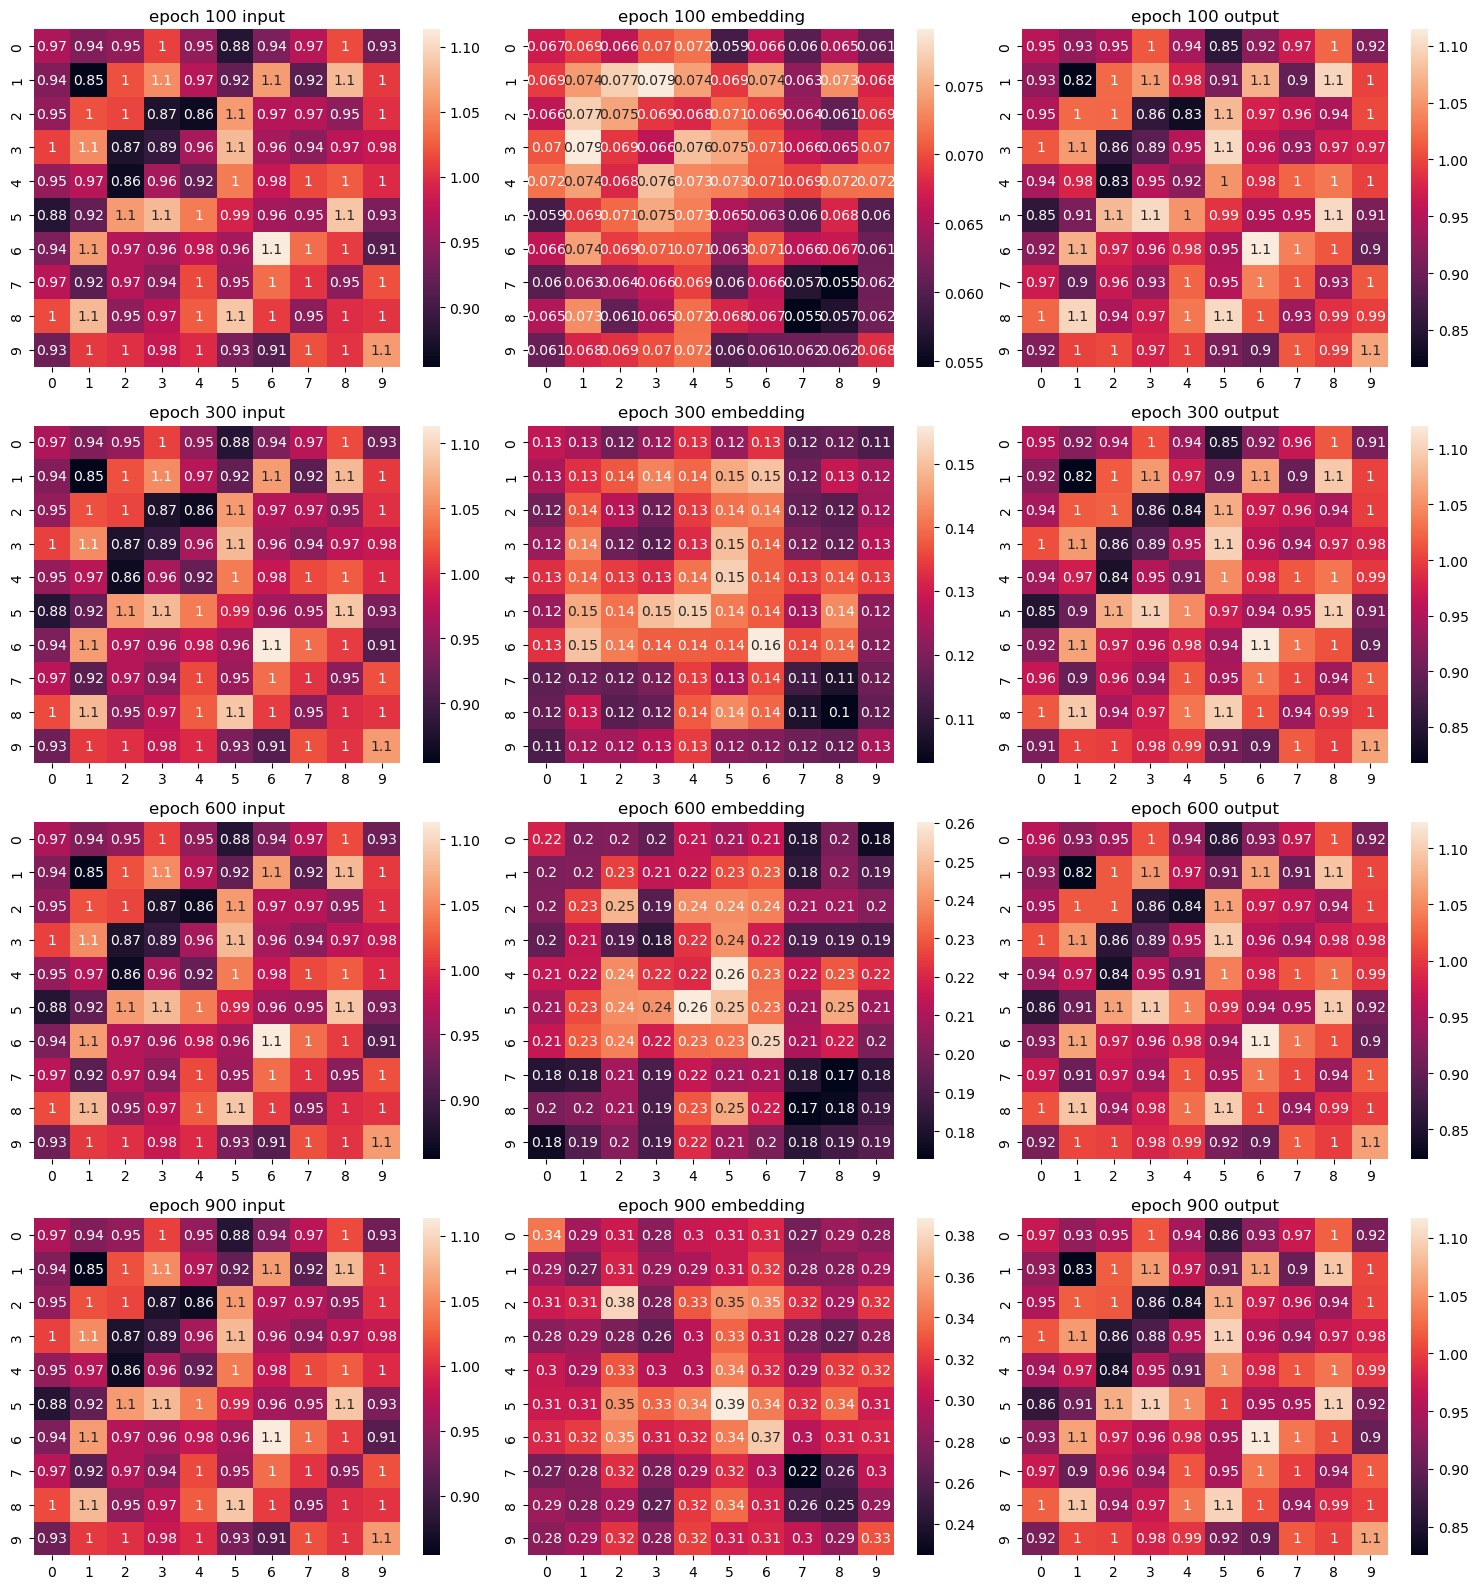

In [64]:
plot_epochs = [100, 300, 600, 900]
utils.plot_distance_matrices(grp_level_dict, epochs = plot_epochs)

## Misc

### Autoencoder with SNNL regularization , embedding 100 dim


In [ ]:
df_tmp = pd.merge(df_metrics['train'][cols0],df_metrics['test'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', suffixes=('_train', None), indicator = False)
df_merge_metrics = pd.merge(df_tmp, df_metrics['val'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', copy = True, suffixes=('_test', '_val'), indicator = False)
df_merge_metrics[['epochs', 'R2_score_train','R2_score_val','R2_score_test','rmse_score_train','rmse_score_val','rmse_score_test']]

In [ ]:
df_merge_metrics.plot(x = 'epochs', y=['R2_score_train','R2_score_val','R2_score_test',], kind='line', subplots=False, title = 'R2 score for AE with 100 dim embedding layer')

### Baseline autoencoder , embedding 150 dim


In [ ]:
df_tmp = pd.merge(df_metrics['train'][cols0],df_metrics['test'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', suffixes=('_train', None), indicator = False)
df_merge_metrics = pd.merge(df_tmp, df_metrics['val'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', copy = True, suffixes=('_test', '_val'), indicator = False)
df_merge_metrics[['epochs', 'R2_score_train','R2_score_val','R2_score_test','rmse_score_train','rmse_score_val','rmse_score_test']]
df_merge_metrics.plot(x = 'epochs', y=['R2_score_train','R2_score_val','R2_score_test',], kind='line', subplots=False, title = 'R2 score for AE with 150 dim embedding layer')

In [55]:
plot_epochs = list(grp_level_dict['train'].keys())

### Baseline autoencoder , embedding 50 dim

In [ ]:
df_tmp = pd.merge(df_metrics['train'][cols0],df_metrics['test'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', suffixes=('_train', None), indicator = False)
df_merge_metrics = pd.merge(df_tmp, df_metrics['val'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', copy = True, suffixes=('_test', '_val'), indicator = False)
df_merge_metrics[['epochs', 'R2_score_train','R2_score_val','R2_score_test','rmse_score_train','rmse_score_val','rmse_score_test']]
df_merge_metrics.plot(x = 'epochs', y=['R2_score_train','R2_score_val','R2_score_test',], kind='line', subplots=False, title = 'R2 score for AE with 50 dim embedding layer')

In [ ]:
# plot_distance_matrices(grp_level_dict, epochs = [50,100,150,200])

# Save data to csv and Excel files

In [65]:
# AE_snnl_dcpb200_150Ltnt_512_20240718_1956_ep_900.pt
filename = f"{model.name}_{ex_runmode}_{indicator}cpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}_{ex_datetime}.pt"
file_pattern = f"{model.name}_{ex_runmode}_{indicator}cpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}_{ex_datetime}*.pt"
print(f" file name   : {filename}")
print(f" file pattern: {file_pattern}")

NameError: name 'ex_datetime' is not defined

In [62]:
timestamp = datetime.now().strftime('%m%d_%H%M%S')
csv_filename = f"{model.name}_{ex_runmode}_{ex_datetime}_{ex_title}_{metric}_metrics_{timestamp}.csv"
csv_filename = os.path.join('./results', csv_filename)
csv_filename

NameError: name 'ex_title' is not defined

In [ ]:
excel_filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{metric}_metrics_{timestamp}.xlsx"
excel_filename = os.path.join('./results', excel_filename)
excel_filename

In [ ]:
excel_sheet = f"{'bl' if ex_runmode == 'baseline' else ex_runmode}_{timestamp}"
excel_sheet

In [ ]:
df_metrics.to_csv(csv_filename, index = False)
df_metrics.to_excel(excel_filename, sheet_name=excel_sheet, index_label='id')

In [ ]:
# mdl_outputs.embeddings[9].sum()
# mdl_outputs.y_pred.sum()
# mdl_outputs.compounds[:17]
df_metrics

## Read metrics CSV file

In [ ]:
input_file  = './results/AE_snnl_20240516_snglOpt-100Ltnt_euclidean_metrics_0603_130545.csv'
input_metrics = pd.read_csv(input_file)
input_metrics

In [ ]:
pattern1 = re.compile(r"(inp|emb|out)_(all|same|diff)_(avg)")
pattern2 = re.compile(r"(CL)_(inp|emb|out)_(all|same|diff)_(avg)")
cols1 = ['epochs', 'R2_score', 'rmse_score'] + [ col for col in metric_cols if pattern1.match(col) ]
cols2 = ['epochs', 'R2_score', 'rmse_score'] +[ col for col in metric_cols if pattern2.match(col) ]

In [ ]:
input_metrics[cols1]

# Metrics

## Distance Metrics

In [ ]:
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=250, nanstr='nan')

In [ ]:
# 1189.5788218820562 + 16009.773130260974 
# 2175.389955100794 / 50

In [ ]:
dmtrc = compute_distance_metrics(sample_activations, epochs, metric = 'euclid')

In [ ]:
# dmtrc.keys()

In [ ]:
dmtrc = compute_distance_metrics(sample_activations, epochs, metric = 'euclid')

In [ ]:
dmtrcs = compute_distance_metrics(sample_activations, epochs)

In [ ]:
display_distance_metrics(dmtrc, epochs)

In [ ]:
# print(f'INPUT features - Euclidean distances - {epochs} epochs')
# print('-'*20)
# dmtrc = distance_metric_1(inp_euc_distance)

# print(f'EMBEDDED features - Euclidean distances - {epochs} epochs')
# print('-'*20)
# dmtrc = distance_metric_1(emb_euc_distance)

# print(f'RECONSTURCTED features -  Euclidean distances - {epochs} epochs')
# print('-'*20)
# dmtrc = distance_metric_1(out_euc_distance)

### Cosine Distance 

In [ ]:
print(f'Input features - Cosine - {epochs} epochs')
print('-'*20)
grp_level_input = distance_metric_1(inp_cos_distance)
 
print(f'Output features - Cosine - {epochs} epochs')
print('-'*20)
grp_level_output = distance_metric_1(out_cos_distance)

In [ ]:
# inp_cos_distance[:5,:15]
# out_cos_distance[:5,:15]
# emb_cos_distance[:5,:15]

## Classification Metrics 

In [ ]:
cls_metrics = compute_classification_metrics(mdl_output)
cls_metrics.epochs = epochs
display_classification_metrics(cls_metrics)
plot_classification_metrics(cls_metrics)

### 

In [ ]:
# test_accuracy = binary_accuracy(y_true=labels, y_prob=logits)
# test_f1 = binary_f1_score(y_true=labels, y_prob=logits)
# print(f"accuracy: {test_accuracy}%      F1 Score: {test_f1:.4f}")
# cm = confusion_matrix(y_true = labels, y_pred = (logits >= 0.5))
# disp = ConfusionMatrixDisplay(cm)
# disp.plot()


In [ ]:
# filename = f"DNN-{args.model.lower()}-{args.seed}.json"
# export_results(model=model, filename=filename)

In [ ]:
# for i in range(len(logits)):
#     if labels[i] == 1:
#         print(f" y_pred: {logits[i]:.5e}   {logits[i]>=0.500}  \t  y_true: {labels[i]}")

## Regression Metrics 

In [ ]:
mdl_outputs.epoch = epoch
reg_metrics = compute_regression_metrics(mdl_output)
# reg_metrics
print()
display_regr_metrics(reg_metrics)
df_metrics

In [ ]:
try:
    df_metrics = pd.concat((df_metrics, pd.DataFrame(vars(reg_metrics), index = [epochs] )) , verify_integrity=True)
    df_metrics.sort_index(inplace = True)
except ValueError:
    print(f" {epochs} already exists - not added")

In [ ]:
df_metrics

## Results

  #### Results `20240505_autoencoder`

In [ ]:
 metrics as epoch 25     metrics as epoch 50     metrics as epoch 100   metrics as epoch 125   metrics as epoch 150  
---------------------- -----------------------  ---------------------- ---------------------- ---------------------- 
RMSE Score :  0.543655  RMSE Score :  0.539906   RMSE Score : 0.536459  RMSE Score : 0.624126  RMSE Score : 0.624126 
 MSE Score :  0.317944   MSE Score :  0.314051    MSE Score : 0.310318   MSE Score : 0.408070   MSE Score : 0.408070 
 MAE Score :  0.378762   MAE Score :  0.373654    MAE Score : 0.371468   MAE Score : 0.434099   MAE Score : 0.434099 
  R2 Score :  0.611225    R2 Score :  0.615898     R2 Score : 0.632036    R2 Score : 0.518840    R2 Score : 0.518840 

  #### Results ` baseline 20240505_dropout04`

In [ ]:
 metrics at epoch  25   metrics at epoch  50   metrics at epoch  75   metrics at epoch 100   metrics at epoch 125   metrics at epoch 150   metrics at epoch 175   metrics at epoch 200   metrics at epoch 225   metrics at epoch 250   metrics at epoch 300   
---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ----------------------  
RMSE Score :  0.539952 RMSE Score :  0.522212 RMSE Score :  0.516986 RMSE Score :  0.510535 RMSE Score :  0.512396 RMSE Score :  0.507615 RMSE Score :  0.501631 RMSE Score :  0.504048 RMSE Score :  0.505369 RMSE Score :  0.504147 RMSE Score :  0.503990  
 MSE Score :  0.313584  MSE Score :  0.295068  MSE Score :  0.289945  MSE Score :  0.283578  MSE Score :  0.285415  MSE Score :  0.280749  MSE Score :  0.275116  MSE Score :  0.277431  MSE Score :  0.278716  MSE Score :  0.277734  MSE Score :  0.277629  
 MAE Score :  0.372594  MAE Score :  0.361990  MAE Score :  0.357078  MAE Score :  0.353107  MAE Score :  0.353546  MAE Score :  0.350261  MAE Score :  0.345679  MAE Score :  0.346366  MAE Score :  0.347385  MAE Score :  0.346365  MAE Score :  0.345845  
  R2 Score :  0.610749   R2 Score :  0.630615   R2 Score :  0.648668   R2 Score :  0.661354   R2 Score :  0.658380   R2 Score :  0.622958   R2 Score :  0.670584   R2 Score :  0.674873   R2 Score :  0.670612   R2 Score :  0.670147   R2 Score :  0.670171   

  #### Results `snnl 20240507_secondTry`

In [ ]:
  metrics as epoch  25   metrics as epoch  50    metrics as epoch  75   metrics as epoch 100    metrics as epoch 125    metrics at epoch 150   metrics at epoch 175   metrics at epoch 200         
----------------------  ----------------------  ---------------------- ----------------------  ----------------------  ---------------------- ---------------------- ----------------------       
RMSE Score : 0.550294   RMSE Score :  0.536259  RMSE Score :  0.516979 RMSE Score :  0.513265  RMSE Score :  0.511261  RMSE Score :  0.506228 RMSE Score :  0.508196 RMSE Score :  0.508642       
 MSE Score : 0.324991    MSE Score :  0.310259   MSE Score :  0.290345  MSE Score :  0.286497   MSE Score :  0.284502   MSE Score :  0.279736  MSE Score :  0.281590  MSE Score :  0.282127       
 MAE Score : 0.382500    MAE Score :  0.372185   MAE Score :  0.358323  MAE Score :  0.353431   MAE Score :  0.351594   MAE Score :  0.347926  MAE Score :  0.348469  MAE Score :  0.348470       
  R2 Score : 0.588431     R2 Score :  0.625873    R2 Score :  0.652229   R2 Score :  0.657811    R2 Score :  0.656971    R2 Score :  0.667756   R2 Score :  0.665126   R2 Score :  0.661970        

### metrics per epoc

#### 25 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 50 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 75 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 100 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 125 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 150 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 175 epochs

In [ ]:
display_regr_metrics(epochs, rm)

#### 200 epochs

In [ ]:
display_regr_metrics(reg_metrics)

# Plot TSNE embeddings

### Apply TSNe

In [ ]:
tsne = TSNE(2)
mdl_projection = dict()
num_layers = len(mdl_outputs.embeddings)
for k in range(num_layers):
    mdl_projection[k] = tsne.fit_transform(mdl_outputs.embeddings[k])
    print(f" layer {k+1} of {num_layers}: projection shape: {mld_projection[k].shape}")
    

In [109]:
tsne = TSNE(2)
mdl_projection = dict()

sorted_keys = sorted(mdl_embeddings.keys())
sorted_keys


11

[100, 200, 237, 300, 400, 500, 600, 700, 800, 896, 900]

In [ ]:
del num_iterations

In [111]:
for k in sorted_keys:
    mdl_projection[k] = tsne.fit_transform(mdl_embeddings[k])
    print(f" Epoch {k} : projection shape: {mdl_projection[k].shape}")
    

 Epoch 100 : projection shape: (4542, 2)
 Epoch 200 : projection shape: (4542, 2)
 Epoch 237 : projection shape: (4542, 2)
 Epoch 300 : projection shape: (4542, 2)
 Epoch 400 : projection shape: (4542, 2)
 Epoch 500 : projection shape: (4542, 2)
 Epoch 600 : projection shape: (4542, 2)
 Epoch 700 : projection shape: (4542, 2)
 Epoch 800 : projection shape: (4542, 2)
 Epoch 896 : projection shape: (4542, 2)
 Epoch 900 : projection shape: (4542, 2)


In [ ]:
# projection_subset = {x: projection[x] for x in range(6)}

In [114]:
mdl_outputs.labels
mdl_outputs.comp_labels
mdl_outputs.epochs

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

array([   0,    0,    0, ..., 1513, 1513, 1513])

900

### 100 Epochs  

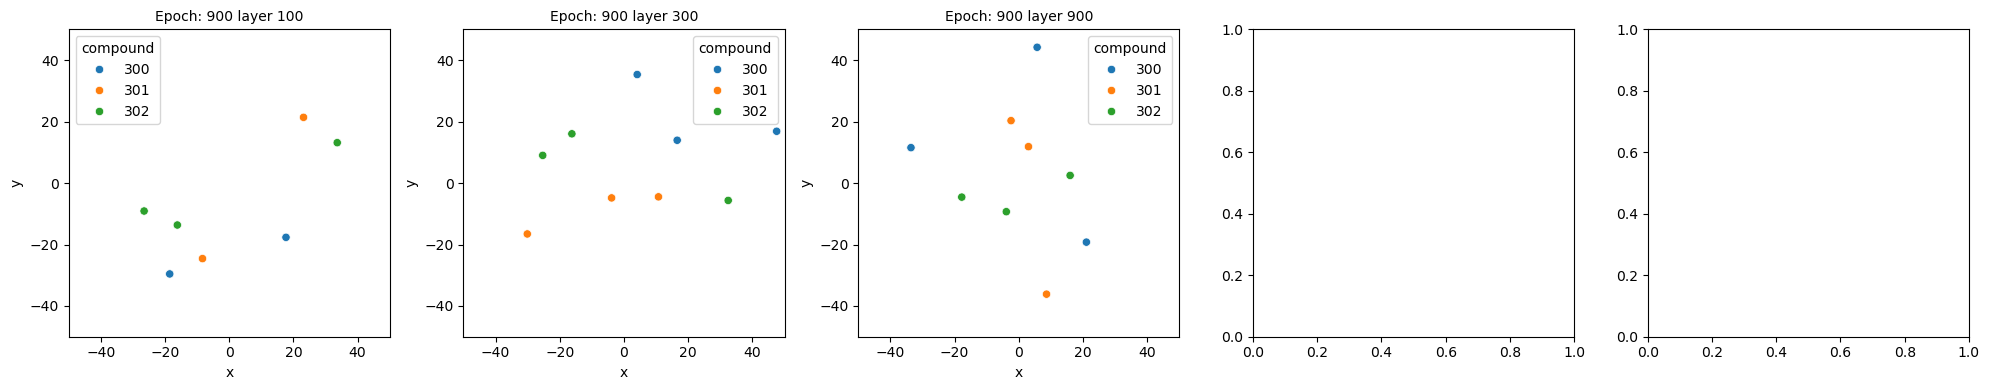

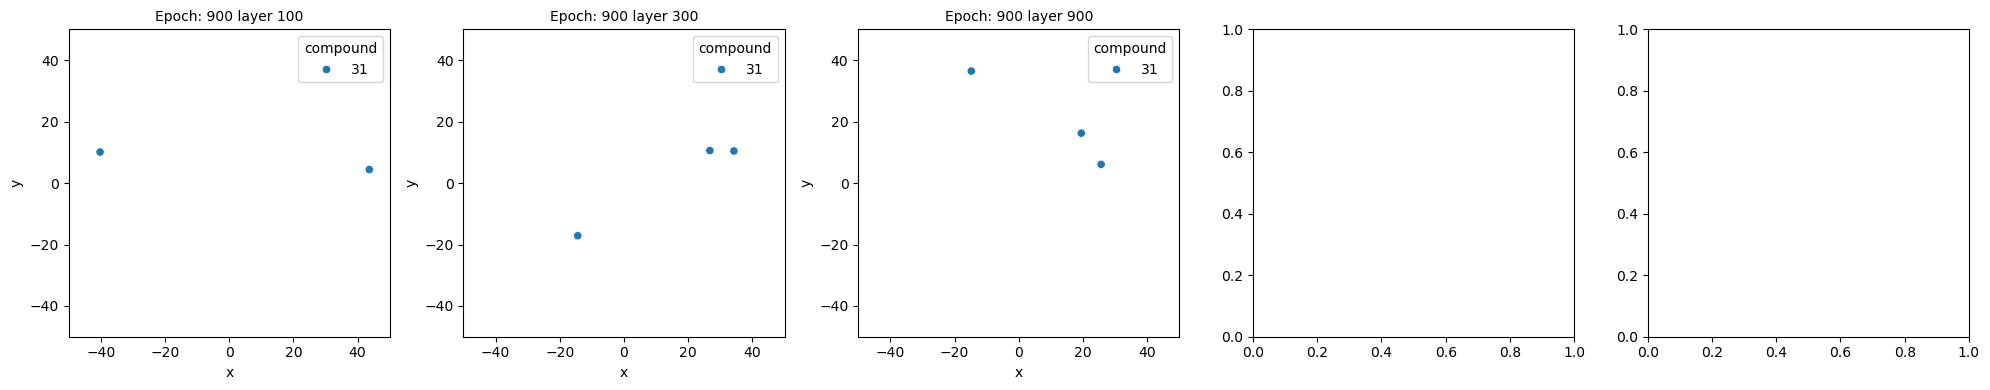

In [131]:
utils.plot_TSNE(mdl_projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [100 ,300, 900], start= 900,end = 909, epoch = mdl_outputs.epochs, limits= (-50,50))
utils.plot_TSNE(mdl_projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [100 ,300, 900], start= 93,end = 96, epoch = mdl_outputs.epochs, limits= (-50,50))
# plot_TSNE_2(mld_projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [0,1,2,3,4], epoch = mdl_outputs.epochs)
# plot_TSNE_2(mld_projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [5,6,7,8,9], epoch = mdl_outputs.epochs)
# print('\n')
# plot_TSNE_2(mdl_projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,8,9],  items = list(range(9)), epoch = mdl_outputs.epochs, limits=(-50,50))
# plot_TSNE_2(mdl_projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,8,9],  items = [3,4,5], epoch = mdl_outputs.epochs, limits=(-50,50))
# print('\n')
# plot_TSNE_2(mdl_projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [0,1,2,3,4],epoch = mdl_outputs.epochs)
# plot_TSNE_2(mdl_projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [5,6,7,8,9],epoch = mdl_outputs.epochs)

### 200 Epochs  

In [ ]:
# plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [0,1,2,3,4], epoch = mdl_outputs.epochs)
# plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [5,6,7,8,9], epoch = mdl_outputs.epochs)
# print('\n')
# plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,8,9],  items = list(range(9)), epoch = mdl_outputs.epochs, limits=(-50,50))
# plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,8,9],  items = [3,4,5], epoch = mdl_outputs.epochs, limits=(-50,50))

print('\n')
fig1 = plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [0,1,2,3,4],epoch = mdl_outputs.epochs)
fig2 = plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [5,6,7,8,9],epoch = mdl_outputs.epochs)

In [ ]:
filename1 = f"./images/{model.name}_{ex_mode}_{timestamp}_{title}_{epochs:03d}_allcmpds_tpsa_1.jpg"
filename2 = f"./images/{model.name}_{ex_mode}_{timestamp}_{title}_{epochs:03d}_allcmpds_tpsa_2.jpg"
fig1.savefig(filename1)
fig2.savefig(filename2)

In [ ]:
Image('test.png')

### 225 Epochs  

In [ ]:
# plot_TSNE(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', end = 21, epoch = mdl_outputs.epochs)
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [0,1,2,3,4], epoch = mdl_outputs.epochs)
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [5,6,7,8,9], epoch = mdl_outputs.epochs)

In [ ]:
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,4,8,9],  items = list(range(9)), epoch = mdl_outputs.epochs, limits=(-50,50))
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,4,8,9],  items = [3,4,5], epoch = mdl_outputs.epochs, limits=(-50,50))

In [ ]:
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [0,1,2,3,4],epoch = mdl_outputs.epochs)
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [5,6,7,8,9],epoch = mdl_outputs.epochs)

### 300 Epochs  

In [ ]:
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [1,3,4,6,8,9],epoch = mdl_outputs.epochs)

In [ ]:
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,4,9],  items = list(range(9)), epoch = mdl_outputs.epochs)

# Older plots

### Based on Compound 

In [ ]:
for layer in [0,1,2,3,4]:
    end = 15
    df = pd.DataFrame(dict(
        x=projection[layer][:end,0],
        y=projection[layer][:end,1],
        label=labels[0:end],
        comp_label = comp_labels[0:end]
    ))
    # _=plt.figure()
    lp=sb.lmplot( data=df, x ="x", y = "y", hue='comp_label', fit_reg=False, palette="hls") #, size=6)
    _=lp.fig.suptitle(f'layer {layer}')

plt.show()

### Based on TPSA Indicator 

In [ ]:
end = 1200
for layer in [0,1,2,3,4]:
    df = pd.DataFrame(dict(
        x=projection[layer][:end,0],
        y=projection[layer][:end,1],
        label=labels[0:end]
    ))
    lp= sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)
    _=lp.fig.suptitle(f'layer {layer}')
plt.show()

### 3D ? 

In [ ]:
from matplotlib import cm
x=projection[4][:,0]
y=projection[4][:,1]
# z=projection[4][:,2]
label=np.expand_dims(labels,-1)
z = np.expand_dims(z,-1)
z.shape

ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
# Plot the 3D surface
# ax.plot_surface(x, y, z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
# ax.plot_trisurf(x, y, z, linewidth=0 , )
# surf = ax.plot_surface(x, y, label, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(x, y, label)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
ax.view_init(elev=45.)

plt.show()

# PCA and TSNE

## define PCA model

In [ ]:
loader_iter = iter(train_loader)

In [ ]:
(batch_features, batch_labels, batch_plates, batch_compounds, batch_hash) = next(loader_iter)

In [ ]:
type(batch_features), batch_features.shape, batch_labels.numpy().shape

In [ ]:
pca = PCA(n_components=200, copy=False, whiten=False, 
          svd_solver='auto', tol=0.0, iterated_power='auto', 
          n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

In [ ]:
pca.fit(batch_features)
X = pca.transform(batch_features)

## define TSNE 

In [ ]:
tsne = TSNE()
projection = tsne.fit_transform(X)
projection.shape

In [ ]:
rows = 1000
df = pd.DataFrame(dict(
    x=projection[:rows,0],
    y=projection[:rows,1],
    label=batch_labels.numpy()[:rows]
    # moa=pd.concat([treated_wells["MOA"], treatments["MOA"]]),
    # batch=pd.concat([treated_wells["Plate"].apply(lambda x: x.split("_")[0]), treatments["Batch"]]),
    # compound=pd.concat([treated_wells["Compound"], treatments["Compound"]]),
    # correct=pd.concat([treated_wells["nsc"],treatments["nsc"]]),
    # level=pd.concat([treated_wells["level"],treatments["level"]])
))

df.info()
df.head()

In [ ]:
plt.figure()
# sb.lmplot('x', 'y', data=df, hue='label', fit_reg=False, palette="hls", size=6)
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)


## Apply TSNE on embeddings

In [ ]:
tsne = TSNE(2)
projection = dict()
for k,v in embeddings.items():
    projection[k] = tsne.fit_transform(v)
    projection[k].shape

#### Layer 0 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[0][:,0],
    y=projection[0][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 1 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[1][:,0],
    y=projection[1][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 2 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[2][:,0],
    y=projection[2][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 3 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[3][:,0],
    y=projection[3][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 4 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[4][:,0],
    y=projection[4][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

In [ ]:
np.bincount(labels.astype(np.int64))

In [ ]:
from matplotlib import cm
x=projection[4][:,0]
y=projection[4][:,1]
# z=projection[4][:,2]
label=np.expand_dims(labels,-1)
z = np.expand_dims(z,-1)
z.shape

ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
# Plot the 3D surface
# ax.plot_surface(x, y, z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
# ax.plot_trisurf(x, y, z, linewidth=0 , )
# surf = ax.plot_surface(x, y, label, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(x, y, label)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
ax.view_init(elev=45.)

plt.show()

# Run data through model - step by step

    train - AE_snnl_dcpb200_150Ltnt_512_20240718_1956_LAST_ep_800.pt 
    
     metrics at epoch 800 
    ----------------------
    RMSE Score :  0.268790
     MSE Score :  0.079164
     MAE Score :  0.185764
      R2 Score :  0.815672 
    
    INPUT features - cosine distances - 800 epochs
    ----------------------------------------------
      ALL group distances                   :    min,max:  [  0.5892,   1.1550]  | Indv/sample level distances   mean:   0.9821   std:   0.1539  | Compound level avg. distances - mean:   0.9770   std:   0.0759 
      INTRA-group (same compound) distances :    min,max:  [  0.5892,   1.0311]  | Indv/sample level distances   mean:   0.9062   std:   0.1741  | Compound level avg. distances - mean:   0.9062   std:   0.1409 
      INTER-group (diff compound) distances :    min,max:  [  0.8533,   1.1550]  | Indv/sample level distances   mean:   0.9849   std:   0.1524  | Compound level avg. distances - mean:   0.9849   std:   0.0598 
    
    EMBEDDED features - cosine distances - 800 epochs
    -------------------------------------------------
      ALL group distances                   :    min,max:  [  0.1749,   0.4389]  | Indv/sample level distances   mean:   0.3138   std:   0.0743  | Compound level avg. distances - mean:   0.3119   std:   0.0536 
      INTRA-group (same compound) distances :    min,max:  [  0.1749,   0.3557]  | Indv/sample level distances   mean:   0.2847   std:   0.0679  | Compound level avg. distances - mean:   0.2847   std:   0.0569 
      INTER-group (diff compound) distances :    min,max:  [  0.2061,   0.4389]  | Indv/sample level distances   mean:   0.3149   std:   0.0743  | Compound level avg. distances - mean:   0.3149   std:   0.0523 
    
    RECONSTURCTED features -  cosine distances - 800 epochs
    -------------------------------------------------------
      ALL group distances                   :    min,max:  [  0.5586,   1.1728]  | Indv/sample level distances   mean:   0.9831   std:   0.1743  | Compound level avg. distances - mean:   0.9776   std:   0.0839 
      INTRA-group (same compound) distances :    min,max:  [  0.5586,   1.0333]  | Indv/sample level distances   mean:   0.8999   std:   0.1897  | Compound level avg. distances - mean:   0.8999   std:   0.1522 
      INTER-group (diff compound) distances :    min,max:  [  0.8302,   1.1728]  | Indv/sample level distances   mean:   0.9862   std:   0.1730  | Compound level avg. distances - mean:   0.9862   std:   0.0670 
    
    
    
    val - AE_snnl_dcpb200_150Ltnt_512_20240718_1956_LAST_ep_800.pt 
    
     metrics at epoch 800 
    ----------------------
    RMSE Score :  0.278058
     MSE Score :  0.084643
     MAE Score :  0.186900
      R2 Score :  0.847175 
    
    INPUT features - cosine distances - 800 epochs
    ----------------------------------------------
      ALL group distances                   :    min,max:  [  0.7587,   1.1032]  | Indv/sample level distances   mean:   0.9695   std:   0.1815  | Compound level avg. distances - mean:   0.9662   std:   0.0680 
      INTRA-group (same compound) distances :    min,max:  [  0.7587,   1.0705]  | Indv/sample level distances   mean:   0.9198   std:   0.2065  | Compound level avg. distances - mean:   0.9198   std:   0.1026 
      INTER-group (diff compound) distances :    min,max:  [  0.8523,   1.1032]  | Indv/sample level distances   mean:   0.9713   std:   0.1802  | Compound level avg. distances - mean:   0.9713   std:   0.0608 
    
    EMBEDDED features - cosine distances - 800 epochs
    -------------------------------------------------
      ALL group distances                   :    min,max:  [  0.2131,   0.4374]  | Indv/sample level distances   mean:   0.3066   std:   0.0858  | Compound level avg. distances - mean:   0.3038   std:   0.0511 
      INTRA-group (same compound) distances :    min,max:  [  0.2131,   0.3018]  | Indv/sample level distances   mean:   0.2656   std:   0.0581  | Compound level avg. distances - mean:   0.2656   std:   0.0254 
      INTER-group (diff compound) distances :    min,max:  [  0.2225,   0.4374]  | Indv/sample level distances   mean:   0.3081   std:   0.0863  | Compound level avg. distances - mean:   0.3081   std:   0.0515 
    
    RECONSTURCTED features -  cosine distances - 800 epochs
    -------------------------------------------------------
      ALL group distances                   :    min,max:  [  0.7219,   1.1159]  | Indv/sample level distances   mean:   0.9677   std:   0.2041  | Compound level avg. distances - mean:   0.9641   std:   0.0757 
      INTRA-group (same compound) distances :    min,max:  [  0.7219,   1.0759]  | Indv/sample level distances   mean:   0.9137   std:   0.2306  | Compound level avg. distances - mean:   0.9137   std:   0.1140 
      INTER-group (diff compound) distances :    min,max:  [  0.8365,   1.1159]  | Indv/sample level distances   mean:   0.9697   std:   0.2028  | Compound level avg. distances - mean:   0.9697   std:   0.0679 
    
    
    test - AE_snnl_dcpb200_150Ltnt_512_20240718_1956_LAST_ep_800.pt 
    
     metrics at epoch 800 
    ----------------------
    RMSE Score :  0.269158
     MSE Score :  0.079579
     MAE Score :  0.185088
      R2 Score :  0.885838 
    
    INPUT features - cosine distances - 800 epochs
    ----------------------------------------------
      ALL group distances                   :    min,max:  [  0.8543,   1.1134]  | Indv/sample level distances   mean:   0.9802   std:   0.1945  | Compound level avg. distances - mean:   0.9803   std:   0.0560 
      INTRA-group (same compound) distances :    min,max:  [  0.8543,   1.1134]  | Indv/sample level distances   mean:   0.9813   std:   0.1929  | Compound level avg. distances - mean:   0.9813   std:   0.0732 
      INTER-group (diff compound) distances :    min,max:  [  0.8629,   1.0877]  | Indv/sample level distances   mean:   0.9802   std:   0.1946  | Compound level avg. distances - mean:   0.9802   std:   0.0538 
    
    EMBEDDED features - cosine distances - 800 epochs
    -------------------------------------------------
      ALL group distances                   :    min,max:  [  0.2117,   0.3462]  | Indv/sample level distances   mean:   0.2743   std:   0.0659  | Compound level avg. distances - mean:   0.2746   std:   0.0267 
      INTRA-group (same compound) distances :    min,max:  [  0.2117,   0.3462]  | Indv/sample level distances   mean:   0.2801   std:   0.0743  | Compound level avg. distances - mean:   0.2801   std:   0.0486 
      INTER-group (diff compound) distances :    min,max:  [  0.2238,   0.3239]  | Indv/sample level distances   mean:   0.2740   std:   0.0656  | Compound level avg. distances - mean:   0.2740   std:   0.0230 
    
    RECONSTURCTED features -  cosine distances - 800 epochs
    -------------------------------------------------------
      ALL group distances                   :    min,max:  [  0.8238,   1.1231]  | Indv/sample level distances   mean:   0.9797   std:   0.2190  | Compound level avg. distances - mean:   0.9797   std:   0.0640 
      INTRA-group (same compound) distances :    min,max:  [  0.8238,   1.1231]  | Indv/sample level distances   mean:   0.9797   std:   0.2190  | Compound level avg. distances - mean:   0.9797   std:   0.0836 
      INTER-group (diff compound) distances :    min,max:  [  0.8463,   1.0986]  | Indv/sample level distances   mean:   0.9797   std:   0.2190  | Compound level avg. distances - mean:   0.9797   std:   0.0614 

In [483]:
filename = filelist[0]
filename

'AE_snnl_dcpb200_150Ltnt_512_20240718_1956_BEST.pt'

In [484]:
model, epochs = utils.load_model_from_ckpt(model, args, filename = filename, cuda_device = model.device, verbose = False)

## Select the data we need to work with 
ds = 'test'
mdl_outputs = utils.run_model_on_test_data(model, data_loaders[ds], embedding_layer = 4, verbose = False)

# mdl_outputs
mdl_outputs.epochs = epochs
mdl_embeddings[epochs] = mdl_outputs.latent_embedding

print(f" {ds} : Compute Regression metrics for epoch {epochs}")
tmp_reg_metrics = utils.compute_regression_metrics(mdl_outputs)
display_regr_metrics(tmp_reg_metrics)

print(f" {ds} : Compute Distance {metric} distance metrics for epoch {epochs}") 
data_samples = get_data_samples(mdl_outputs, sample_compounds[ds], spc = 3)

tmp_group_metrics, tmp_sample_metrics, tmp_grp_dist_raw = utils.compute_distance_metrics(data_samples, epochs = epochs, metric = metric, display = False, verbose = True )
# dist_metrics, sample_metrics, grp_level_dict[ds][epochs] = utils.compute_distance_metrics(data_samples, epochs = epochs, metric = metric, display = True, verbose = True )

2024-08-24 19:10:22,379 - root - INFO: -  Load model checkpoint from  AE_snnl_dcpb200_150Ltnt_512_20240718_1956_BEST.pt
2024-08-24 19:10:22,419 - snnl.utils.utils_ptsnnl - INFO: -  ==> Loading from checkpoint AE_snnl_dcpb200_150Ltnt_512_20240718_1956_BEST.pt successfully. last epoch on checkpoint: 896
2024-08-24 19:10:22,419 - snnl.utils.utils_ptsnnl - INFO: -  ==> Loaded from checkpoint AE_snnl_dcpb200_150Ltnt_512_20240718_1956_BEST.pt successfully. last epoch on checkpoint: 896
2024-08-24 19:10:22,420 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.848428 - epoch: 866
2024-08-24 19:10:22,420 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.856036 - epoch: 895
2024-08-24 19:10:22,421 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model device: cuda:0
2024-08-24 19:10:22,422 - snnl.utils.utils_ptsnnl - INFO: -  Loaded model temperature: 0.11629646271467209


 test : Compute Regression metrics for epoch 896
 metrics at epoch 896 
----------------------
RMSE Score :  0.267037
 MSE Score :  0.078335
 MAE Score :  0.183450
  R2 Score :  0.887578 
 test : Compute Distance cosine distance metrics for epoch 896

 k0: inp  row: 0  col: 0 - Row: JCP2022_080966  Col: JCP2022_080966 
 ----------------------------------------------------------------------
 [[0.         0.92419611 0.80558773]
 [0.92419611 0.         1.16559426]
 [0.80558773 1.16559426 0.        ]] 

 Whole Tile     :  mean: 0.643417
 Upper Triangle :  mean: 0.965126 [0.92419611 0.80558773 1.16559426]
 Stack          :  mean: 0.965126 [0.92419611 0.80558773 1.16559426] . . . 

 k0: inp  row: 3  col: 3 - Row: JCP2022_067959  Col: JCP2022_067959 
 ----------------------------------------------------------------------
 [[0.         0.78465633 0.86520274]
 [0.78465633 0.         0.91299524]
 [0.86520274 0.91299524 0.        ]] 

 Whole Tile     :  mean: 0.569523
 Upper Triangle :  mean: 0.8

In [485]:
display_dist_metrics(tmp_group_metrics, tmp_sample_metrics, epochs, metric)

  cosine distances - 896 epochs
                                                             Compound Grp Lvl Averages                          All Samples    
                                                        min      max          mean       std      |    min       max         mean       std
  INPUT features                                     -------------------------------------------------------------------------------------
  inp_all    ALL compounds                            0.8543 -  1.1134       0.9803     0.0560    |   0.4556 -  1.5247      0.9802     0.1945
  inp_same   INTRA-group (same compound) distances    0.8543 -  1.1134       0.9813     0.0732    |   0.6041 -  1.3071      0.9813     0.1929
  inp_diff   INTER-group (diff compound) distances    0.8629 -  1.0877       0.9802     0.0538    |   0.4556 -  1.5247      0.9802     0.1946

  EMBEDDED features                                  
  emb_all    ALL compounds                            0.2245 -  0.3870       0.3

In [486]:
print(f" {ds} : Add data for epoch {epochs} to dataframes")

ix = f"{ds}_{epochs:04d}"
try:
    df_reg_metrics[ds] = pd.concat((df_reg_metrics[ds], pd.DataFrame([{'ds' : ds, 'epoch' : epochs} | vars(tmp_reg_metrics)], index = [ix]) ), verify_integrity=True)
    df_group_metrics[ds] = pd.concat((df_group_metrics[ds], pd.DataFrame([{'ds' : ds, 'epoch' : epochs} | tmp_group_metrics ], index = [ix]) ), verify_integrity=True)
    df_sample_metrics[ds] = pd.concat((df_sample_metrics[ds], pd.DataFrame([{'ds' : ds, 'epoch' : epochs} | tmp_sample_metrics ], index = [ix]) ), verify_integrity=True)
except ValueError:
    print(f" {epochs} already exists in df_reg_metrics - not added")



 test : Add data for epoch 896 to dataframes


In [468]:
# df_reg_metrics[ds]= pd.DataFrame()

In [487]:
df_reg_metrics[ds]
df_group_metrics[ds]
df_sample_metrics[ds]
# pd.DataFrame([{'ds' : ds, 'epoch': epochs} | vars(tmp_reg_metrics) ])
# pd.DataFrame([ {'ds' : ds} | vars(tmp_reg_metrics)], index =[ ix ])

ds  epoch  epochs  R2_score  mse_score  rmse_score  mae_score
test_0896  test    896     896  0.887578   0.078335    0.267037    0.18345

ds  epoch  inp_all_min  inp_all_max  inp_all_avg  inp_all_std  inp_same_min  inp_same_max  inp_same_avg  \
test_0896  test    896     0.854285      1.11344     0.980299     0.056047      0.854285       1.11344      0.981277   

           inp_same_std  ...  out_all_avg  out_all_std  out_same_min  out_same_max  out_same_avg  out_same_std  out_diff_min  \
test_0896      0.073206  ...      0.97631     0.063703       0.82435       1.11175      0.975582      0.080522      0.842604   

           out_diff_max  out_diff_avg  out_diff_std  
test_0896      1.100468      0.976391      0.061551  

[1 rows x 38 columns]

ds  epoch  inp_all_min  inp_all_max  inp_all_avg  inp_all_std  inp_same_min  inp_same_max  inp_same_avg  \
test_0896  test    896     0.455574     1.524666     0.980229     0.194519      0.604077      1.307081      0.981277   

           inp_same_std  ...  out_all_avg  out_all_std  out_same_min  out_same_max  out_same_avg  out_same_std  out_diff_min  \
test_0896      0.192945  ...     0.976362     0.218784      0.578924      1.333385      0.975582      0.217161      0.420567   

           out_diff_max  out_diff_avg  out_diff_std  
test_0896      1.554184      0.976391      0.218844  

[1 rows x 38 columns]

In [488]:
print(f" {ds} : Add data for epoch {epochs} to dictionaries ")
try:
    reg_metrics[ds][epochs] = tmp_reg_metrics
    group_metrics[ds][epochs]  = tmp_group_metrics
    sample_metrics[ds][epochs] = tmp_sample_metrics
    grp_level_dict[ds][epochs] = tmp_grp_dist_raw
except ValueError:
    print(f" {epochs} already exists - not added")

 test : Add data for epoch 896 to dictionaries 


In [489]:
print(f"{ds} - {filename} \n")
for ds in ['train', 'val', 'test']:
    for ep in reg_metrics[ds].keys():
        display_regr_metrics(reg_metrics[ds][ep])
        display_dist_metrics(group_metrics[ds][ep], sample_metrics[ds][ep], ep, metric)

test - AE_snnl_dcpb200_150Ltnt_512_20240718_1956_BEST.pt 

 metrics at epoch 896 
----------------------
RMSE Score :  0.267037
 MSE Score :  0.078335
 MAE Score :  0.183450
  R2 Score :  0.887578 
  cosine distances - 896 epochs
                                                             Compound Grp Lvl Averages                          All Samples    
                                                        min      max          mean       std      |    min       max         mean       std
  INPUT features                                     -------------------------------------------------------------------------------------
  inp_all    ALL compounds                            0.8543 -  1.1134       0.9803     0.0560    |   0.4556 -  1.5247      0.9802     0.1945
  inp_same   INTRA-group (same compound) distances    0.8543 -  1.1134       0.9813     0.0732    |   0.6041 -  1.3071      0.9813     0.1929
  inp_diff   INTER-group (diff compound) distances    0.8629 -  1.0877       0.